# **Lab 4.2 NN MLP and CNN**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime
import os


Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [2]:
def get_base_dataset(ds):
    # ไล่ลึก dataset จริง (ไม่ใช่ Subset)
    while hasattr(ds, 'dataset'):
        ds = ds.dataset
    return ds

def show_subset_detail(subset, data_name):
    base_ds = get_base_dataset(subset)

    # ดึง mapping class_to_idx (ถ้ามี)
    if hasattr(base_ds, 'class_to_idx'):
        class_map = base_ds.class_to_idx
    else:
        class_map = {}

    # ดึง labels ของ subset ตาม indices
    if hasattr(subset, 'indices') and hasattr(base_ds, 'targets'):
        targets = [base_ds.targets[i] for i in subset.indices]
    elif hasattr(base_ds, 'targets'):
        targets = base_ds.targets
    elif hasattr(base_ds, 'labels'):
        targets = base_ds.labels
    else:
        targets = []

    class_counts = Counter(targets)

    print(f"{data_name} Dataset:")
    for label in sorted(class_counts.keys()):
        print(f"\tNumber of images in class {label}: {class_counts[label]}")

    print(f"\tNumber of {data_name.lower()} samples: {len(subset)}")

In [3]:
def show_img(data_loader):
      
      images, labels = next(iter(data_loader))

      fig = plt.figure(figsize=(10, 10))
      plt.style.use('dark_background')

      grid = ImageGrid(fig, 111,
                        nrows_ncols=(4, 4),  
                        axes_pad=0.5,  
                        )

      for ax, im, lb in zip(grid, images, labels):
            im_np = im.permute(1, 2, 0).numpy()
            ax.axis('off')
            ax.set_title(str(lb.item()))
            ax.imshow(im_np, cmap='gray')

      plt.show()

In [4]:
def load_data(path,class_names):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(20, padding_mode='edge'),
        transforms.Resize(32),
        transforms.RandomRotation(25, fill=255),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = ImageFolder(root=path, transform=transform)

    class_to_idx = dataset.class_to_idx  
    selected_class_idxs = [class_to_idx[name] for name in class_names]

    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_class_idxs]

    filtered_dataset = Subset(dataset, indices)     # สร้าง Subset ของ dataset เฉพาะ 2 คลาสนี้
    labels = [dataset.targets[i] for i in indices]  # ดึง label ของ subset สำหรับการแบ่ง train/test

    train_idx, test_idx = train_test_split(list(range(len(filtered_dataset))), test_size=0.2, stratify=labels, random_state=42) # แบ่ง train/test โดยใช้ sklearn

    train_dataset = Subset(filtered_dataset, train_idx)
    test_dataset = Subset(filtered_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

    show_subset_detail(train_dataset,"Train")
    show_subset_detail(test_dataset,"Test")
    show_img(train_loader)
    ### END CODE HERE ###
    
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


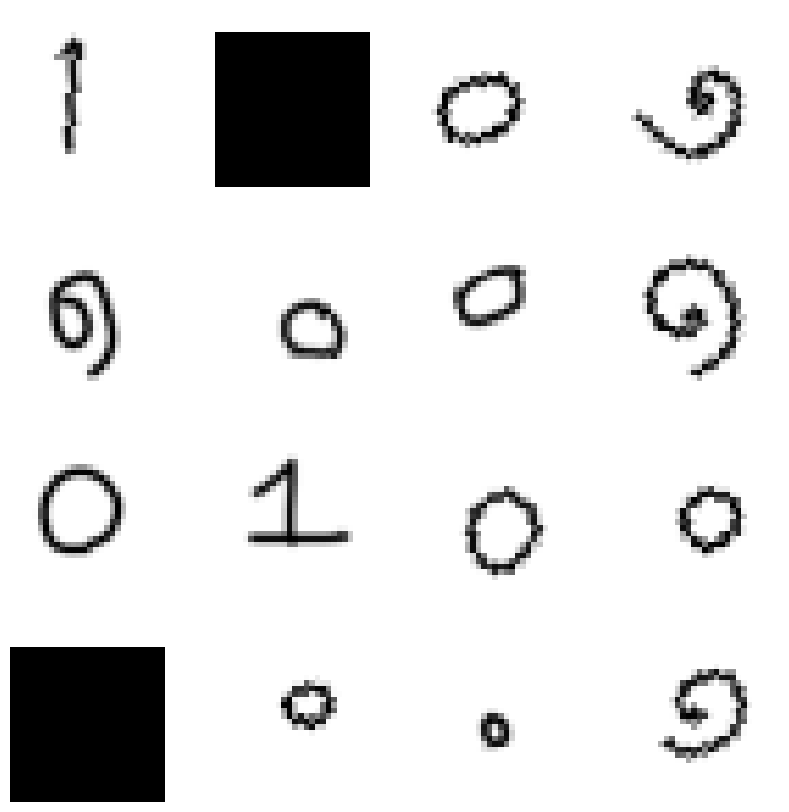

In [5]:
### START CODE HERE ###
class_names = [f'{x}' for x in range(2)]
train_loader, test_loader = load_data('thai-handwriting-number.appspot.com',class_names)

### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

# **The Model**

In [6]:
### START CODE HERE ###

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28*28,1)
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):

        features = {}

        print(x.shape)
        features['ori'] = x.detach().cpu()

        x = self.flatten(x)
        print(x.shape)
        features['flatten'] = x.detach().cpu()
        
        x = self.fc(x)
        print(x.shape)
        features['fc'] = x.detach().cpu()
        print(f"FC values: min={x.detach().cpu().min():.3f}, max={x.detach().cpu().max():.3f}")

        x = self.sigmoid(x)
        print(x.shape)
        features['sigmoid'] = x.detach().cpu()
        print(f"sigmoid values: min={x.detach().cpu().min():.3f}, max={x.detach().cpu().max():.3f}")

        return features

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 48)      # ชั้นที่ 1
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(48, 1)            # ชั้นที่ 2 (output)
        self.sigmoid2 = nn.Sigmoid()
        
    def get_features(self, x):
        features = {}
        
        features['input'] = x.detach().cpu()
        
        x = self.flatten(x)
        features['flatten'] = x.detach().cpu()
        
        x = self.fc1(x)
        features['fc1'] = x.detach().cpu()
        
        x = self.sigmoid1(x)
        features['sigmoid1'] = x.detach().cpu()
        
        x = self.fc2(x)
        features['fc2'] = x.detach().cpu()
        
        x = self.sigmoid2(x)
        features['sigmoid2'] = x.detach().cpu()
        
        return features

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        return x
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (1 input channel → 16 filters)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (16 → 32 filters)

        self.pool = nn.MaxPool2d(2, 2)  # reduce spatial size

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flattened after pooling
        self.fc2 = nn.Linear(128, 1)

        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        features = {}

        features['input'] = x.detach().cpu()

        x = self.conv1(x)
        features['conv1'] = x.detach().cpu()
        x = F.relu(x)

        x = self.pool(x)
        features['pool1'] = x.detach().cpu()

        x = self.conv2(x)
        features['conv2'] = x.detach().cpu()
        x = F.relu(x)

        x = self.pool(x)
        features['pool2'] = x.detach().cpu()

        x = x.view(x.size(0), -1)  # Flatten
        features['flatten'] = x.detach().cpu()

        x = self.fc1(x)
        features['fc1'] = x.detach().cpu()
        x = F.relu(x)

        x = self.fc2(x)
        features['fc2'] = x.detach().cpu()

        x = self.sigmoid(x)
        features['output'] = x.detach().cpu()

        return features

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

In [7]:
def show_featuremaps(features):
    ### START CODE HERE ###
    fig, axs = plt.subplots(1, len(features), figsize=(len(features)*3, 4))
    plt.style.use('dark_background')

    for ax, (name, feat) in zip(axs, features.items()):
        f = feat[0].cpu().numpy()  # ใช้ sample แรก
        print(f.ndim, f.shape[0])

        if f.ndim == 3:
            # รูปภาพต้นฉบับ (C, H, W)
            if f.shape[0] == 1:
                f = f[0]  # ถ้าเป็น grayscale
                ax.imshow(f)
            else:
                channels = []
                for i in range(f.shape[0]):  # วนลูป 16 channels
                    channels.append(f[i])  # เอาแต่ละ channel (28, 28)
                # ต่อกันแนวตั้ง (stack vertically)
                f_stacked = np.vstack(channels)  # (16*28, 28) = (448, 28)
                ax.imshow(f_stacked)

        elif f.ndim == 1:
            if f.shape[0] > 1:
                ax.imshow(f.reshape(-1, 1), aspect='auto')
            else:
                f_display = np.array([[f.item()]])
                ax.imshow(f_display, aspect='auto', vmin=0, vmax=1)

        ax.set_title(name)
        ax.axis('off')
    return fig

torch.Size([16, 1, 28, 28])
torch.Size([16, 784])
torch.Size([16, 1])
FC values: min=-1.021, max=-0.133
torch.Size([16, 1])
sigmoid values: min=0.265, max=0.467
3 1
1 784
1 1
1 1


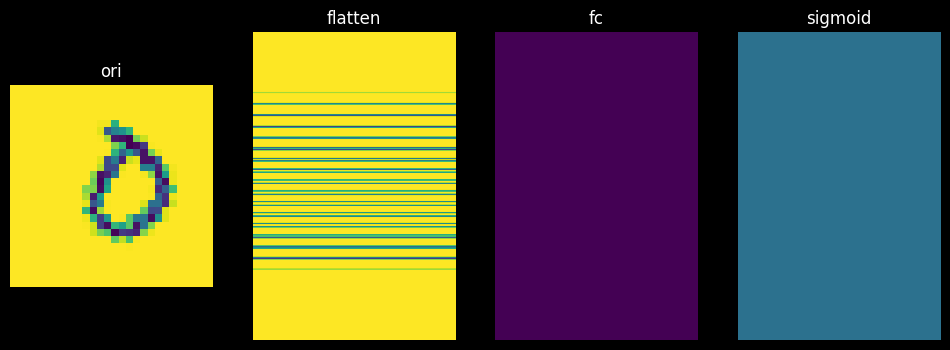

In [8]:
nn_model = NN()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= nn_model(input_tensor)
features = nn_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

3 1
1 784
1 48
1 48
1 1
1 1


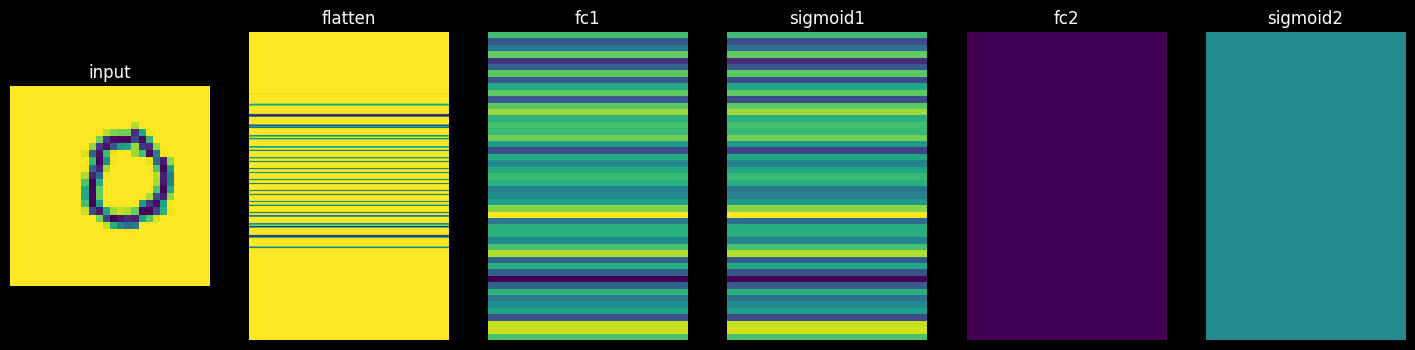

In [9]:
mlp_model = MLP()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= mlp_model(input_tensor)
features = mlp_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

3 1
3 16
3 16
3 32
3 32
1 1568
1 128
1 1
1 1


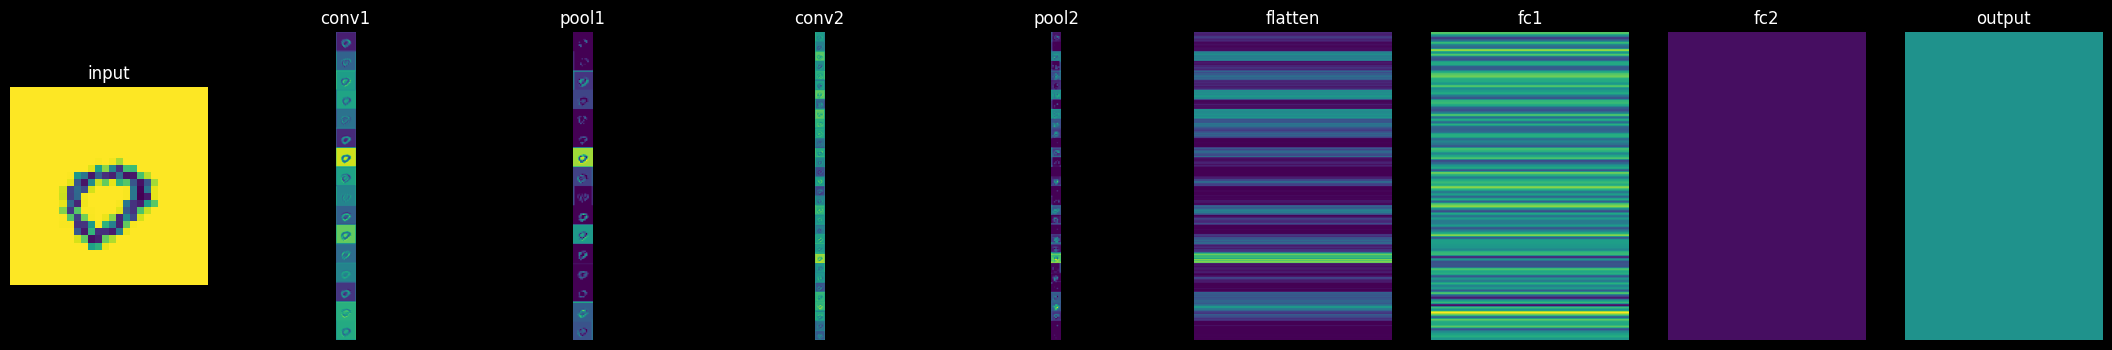

In [10]:
cnn_model = CNN()
data_iter = iter(train_loader)
input_tensor, _ = next(data_iter)
output= cnn_model(input_tensor)
features = cnn_model.get_features(input_tensor) 
fig = show_featuremaps(features)
plt.show() 

TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [112]:
import os

def train(class_names,model,opt,loss_fn,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###
    
    model = model.to(device)
    class_map = {int(class_names[0]): 0, int(class_names[1]): 1}
    history = {
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[]
    }

    for epoch in range(epochs):
        model.train()
        train_bar = tqdm(train_loader, desc=f'Training Epoch [{epoch+1}/{epochs}]', unit='batch')

        total_train_loss = 0
        total_train_correct = 0

        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.cpu().numpy()
            labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)

            opt.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            opt.step()
            
            total_train_loss += loss.item()
            predicted = (output > 0.6).long()  # output เป็น sigmoid -> 0~1
            total_train_correct += (predicted == labels).sum().item()

            train_bar.set_postfix(loss=loss.item())
            
        # print("output: ",output.squeeze().tolist())
        # print("Predicted: ", predicted.squeeze().tolist())
        # print("Label:     ", labels.squeeze().long().tolist())
        
        avg_train_loss = total_train_loss/len(train_loader)
        avg_train_acc = total_train_correct/len(train_loader.dataset)
        
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)


        #testing-----------------------------------------------------------------------------------
        model.eval()
        test_bar = tqdm(test_loader, desc='Testing 🧐🧐', unit='batch')

        total_test_loss = 0
        total_test_correct = 0

        with torch.no_grad():
            for images, labels in test_bar:
                images = images.to(device)
                labels = labels.cpu().numpy()
                labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)

                
                # labels = labels.to(device)
                # labels = labels.float().unsqueeze(1)

                output = model(images)
                loss = loss_fn(output, labels)

                total_test_loss += loss.item()
                predicted = (output > 0.6).long()
                total_test_correct += (predicted == labels).sum().item()

                test_bar.set_postfix(loss=loss.item())
        
        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_correct / len(test_loader.dataset)

        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(avg_test_acc)

        if epoch == epochs-1:
            print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}\n")

        if writer:
            writer.add_scalar("Loss/train", avg_train_loss, epoch)
            writer.add_scalar("Accuracy/train", avg_train_acc, epoch)
            writer.add_scalar("Loss/test", avg_test_loss, epoch)
            writer.add_scalar("Accuracy/test", avg_test_acc, epoch)
            writer.flush() 

        if checkpoint_path and epoch == epochs-1:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            model_path = checkpoint_path
            torch.save(model.state_dict(), model_path)
        
    writer.close()
    return history

    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


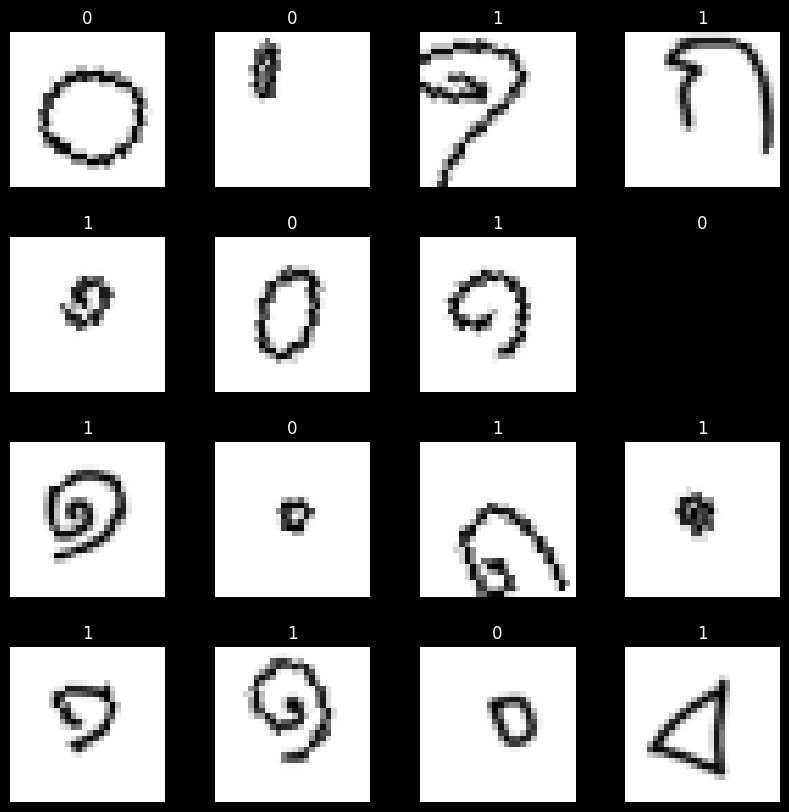

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


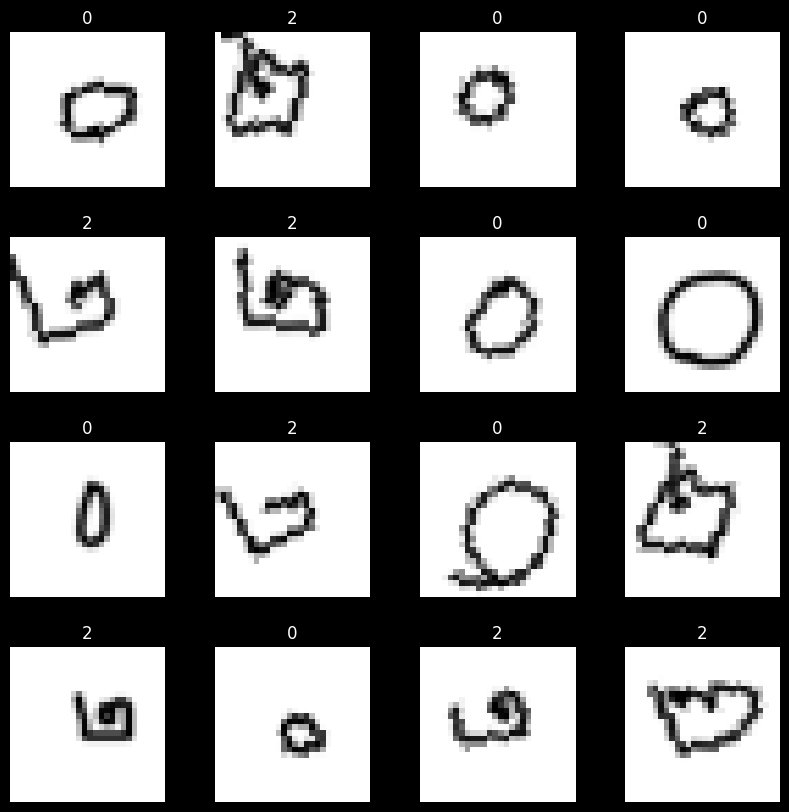

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


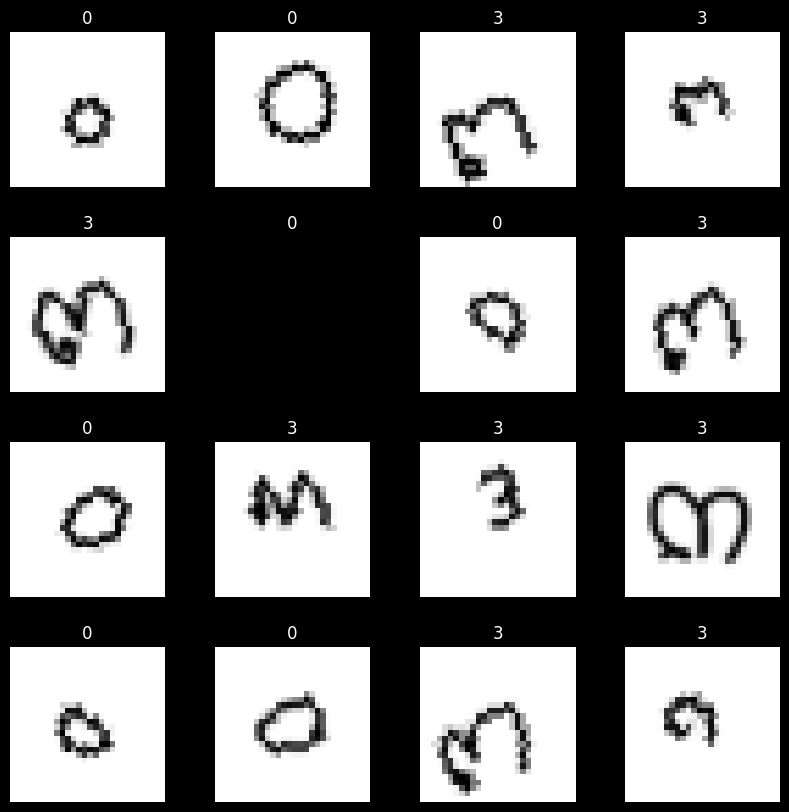

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


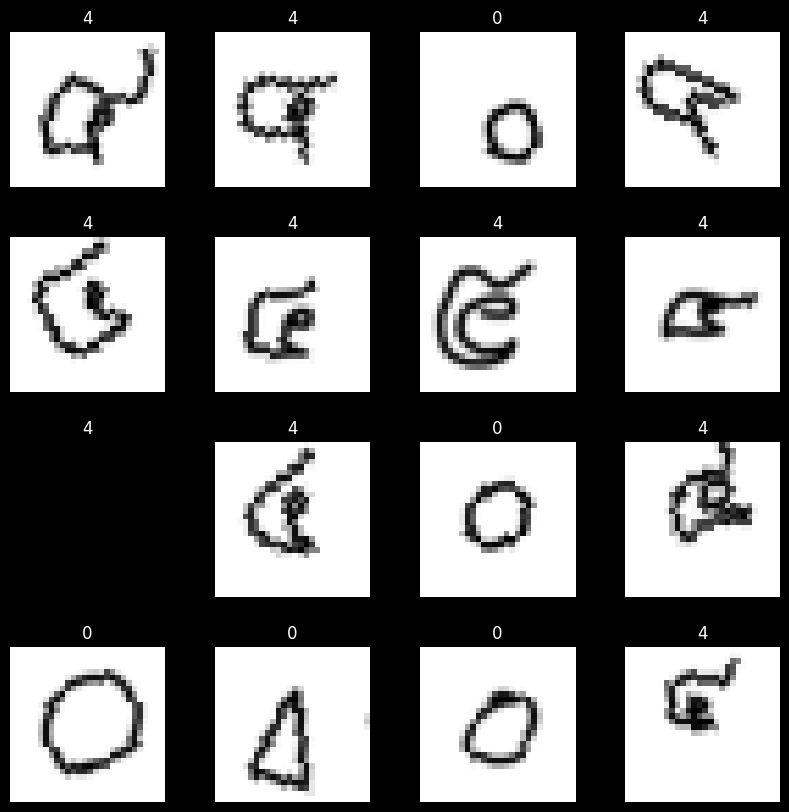

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


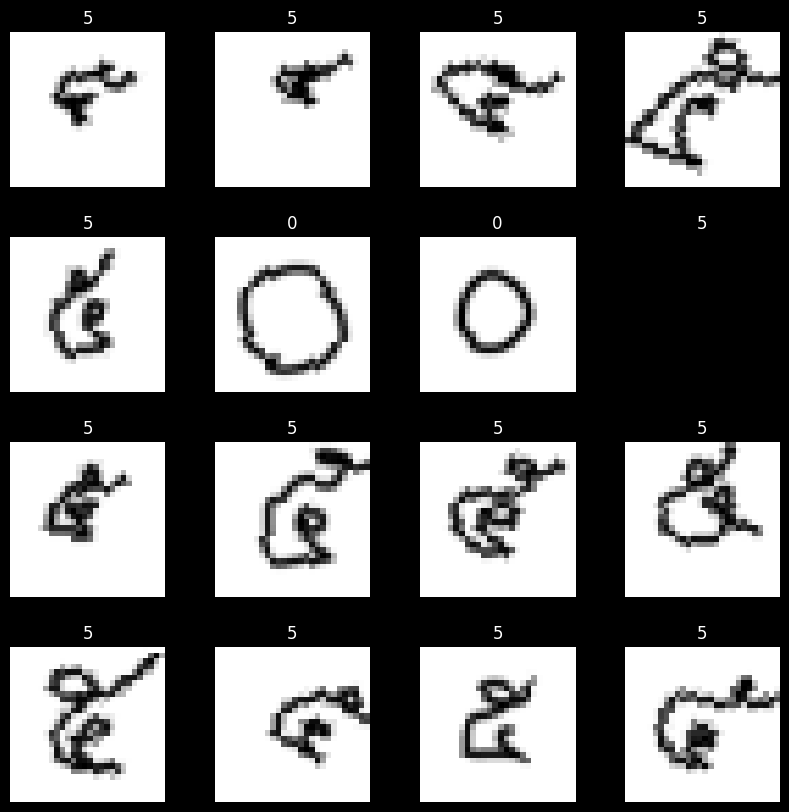

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


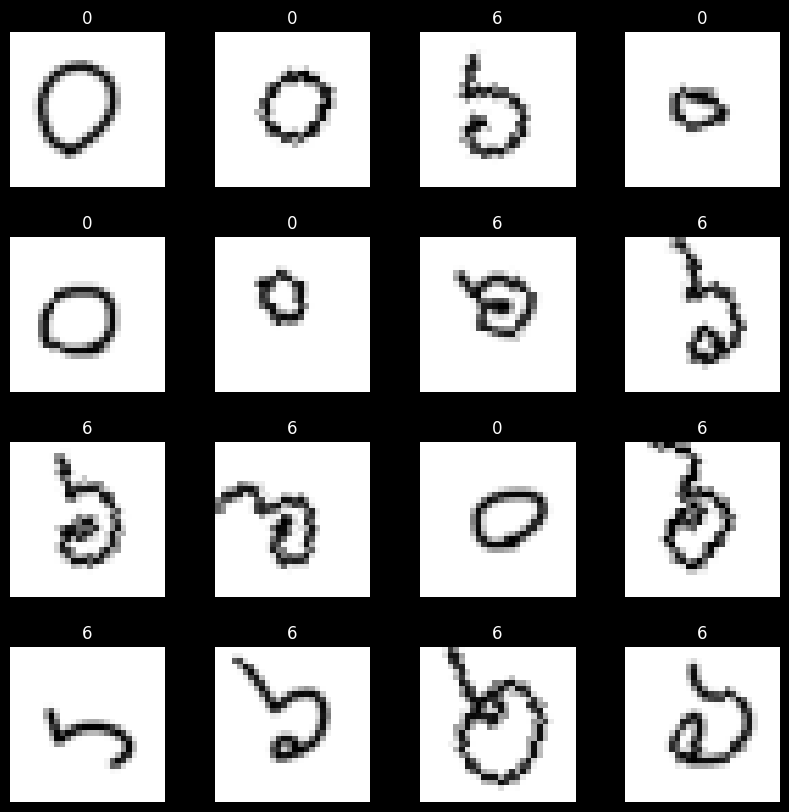

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


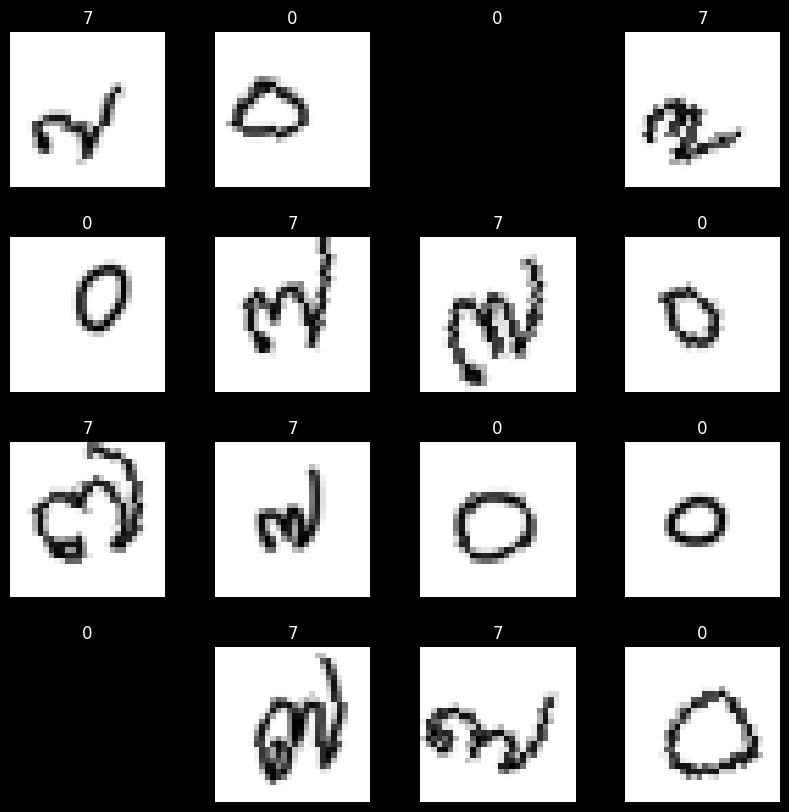

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


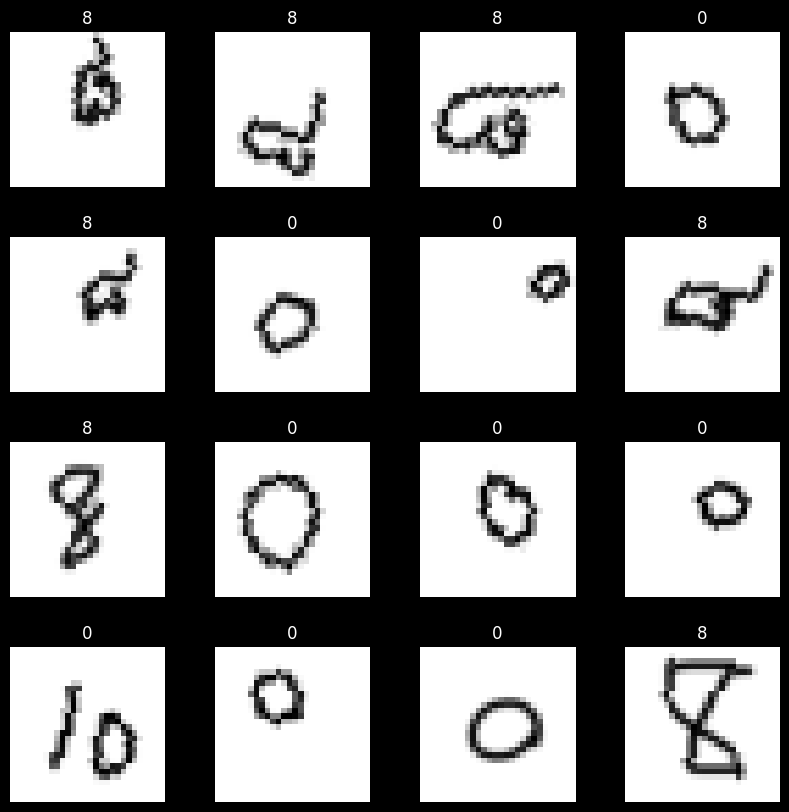

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


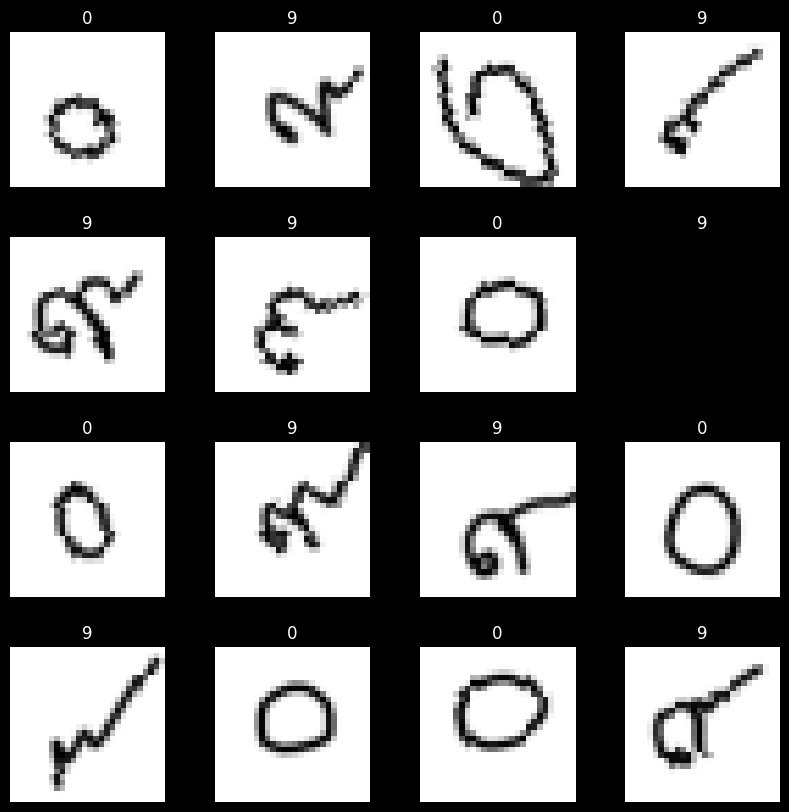

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of images in class 2: 1
	Number of train samples: 622
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


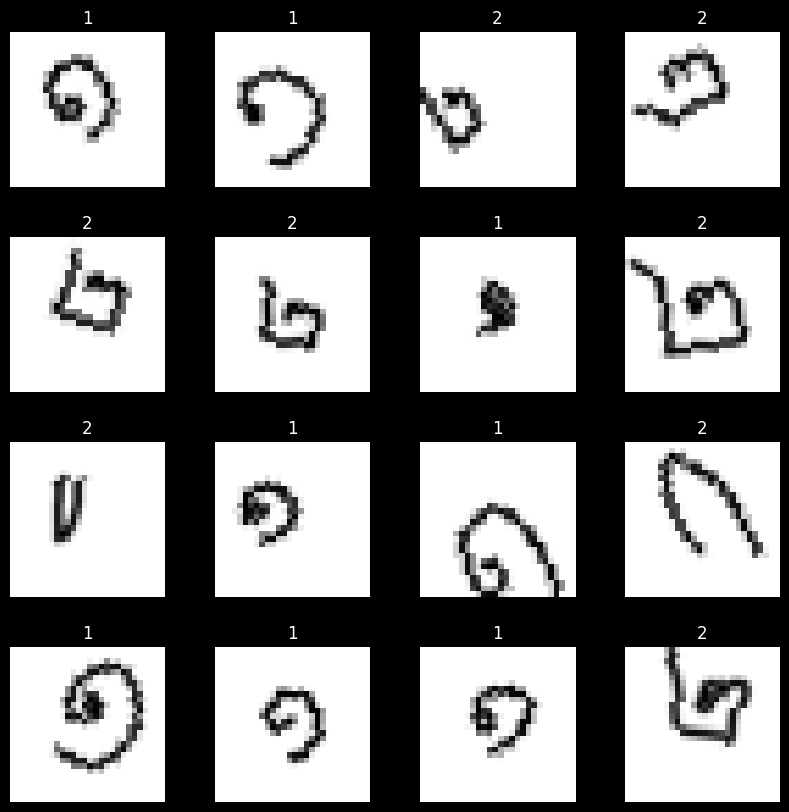

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


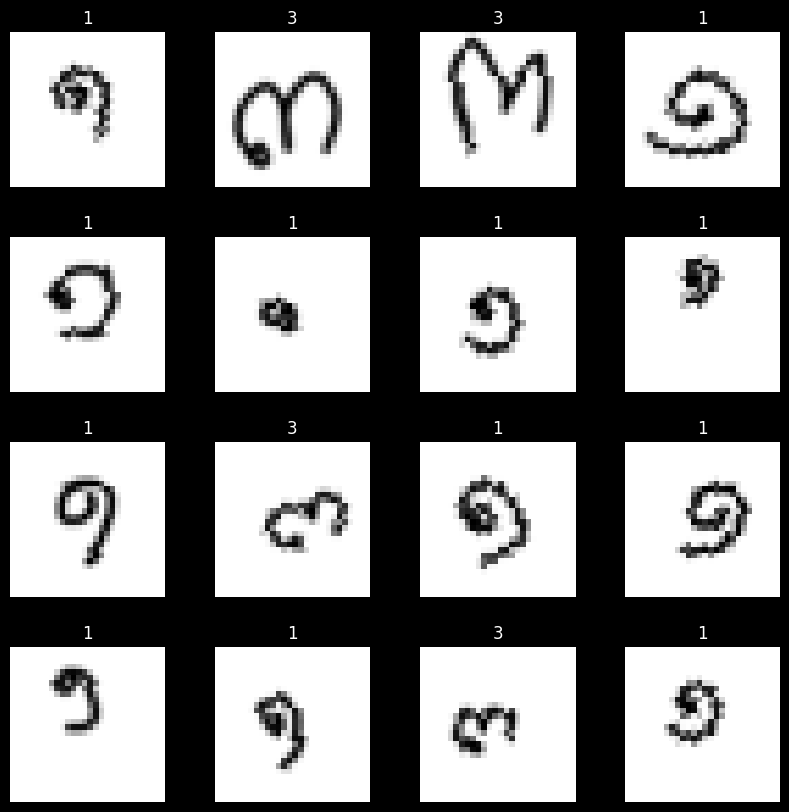

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


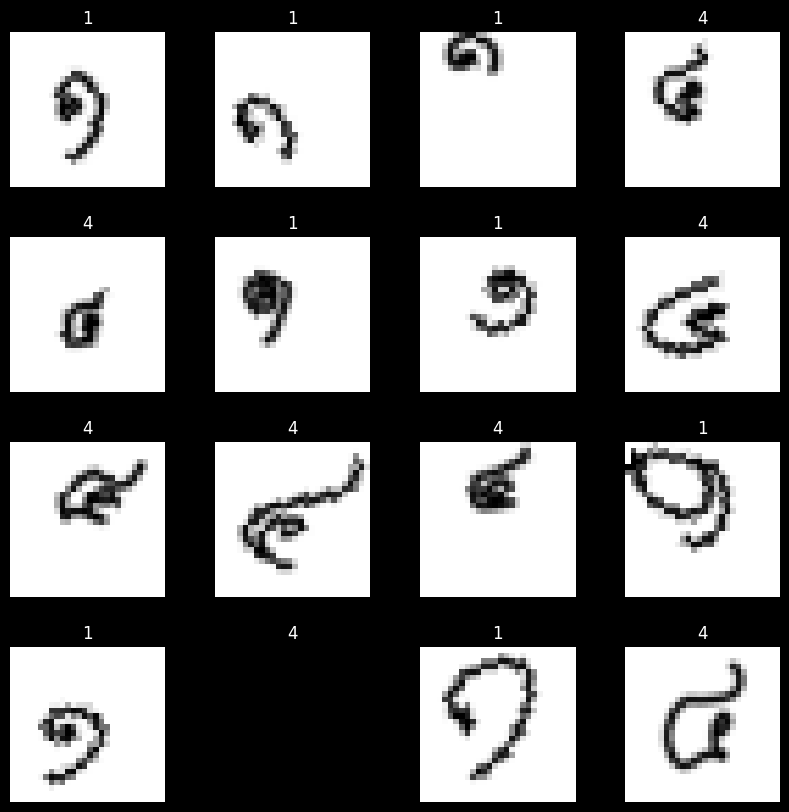

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


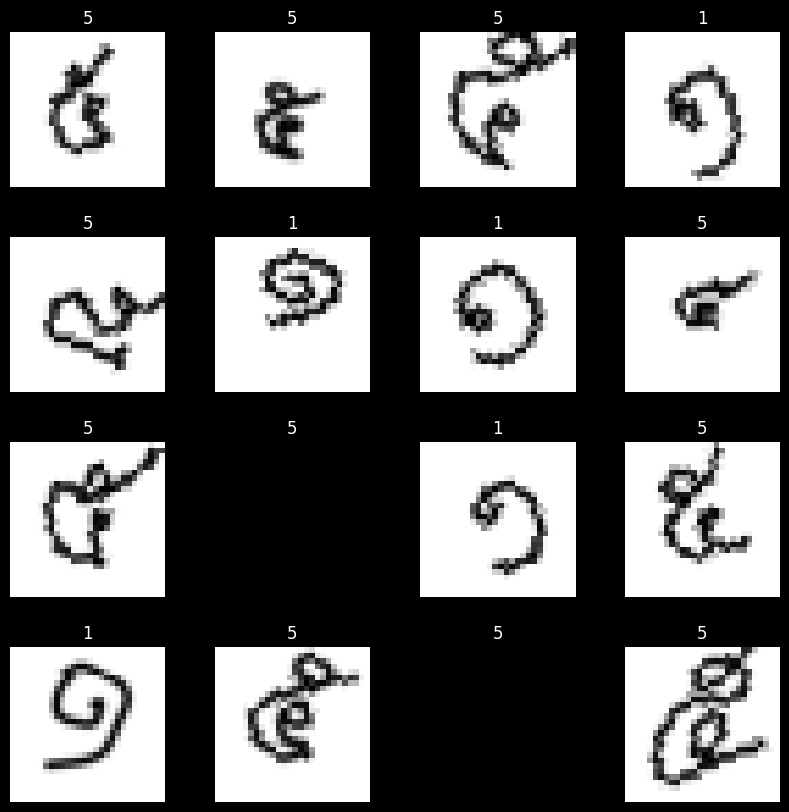

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 256
	Number of train samples: 567
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 65
	Number of test samples: 142


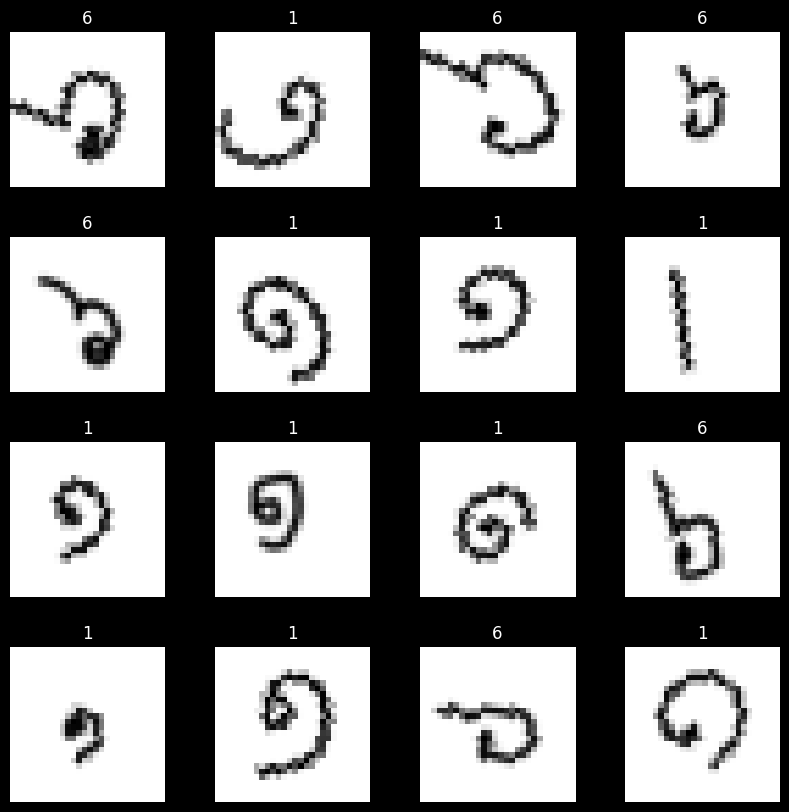

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


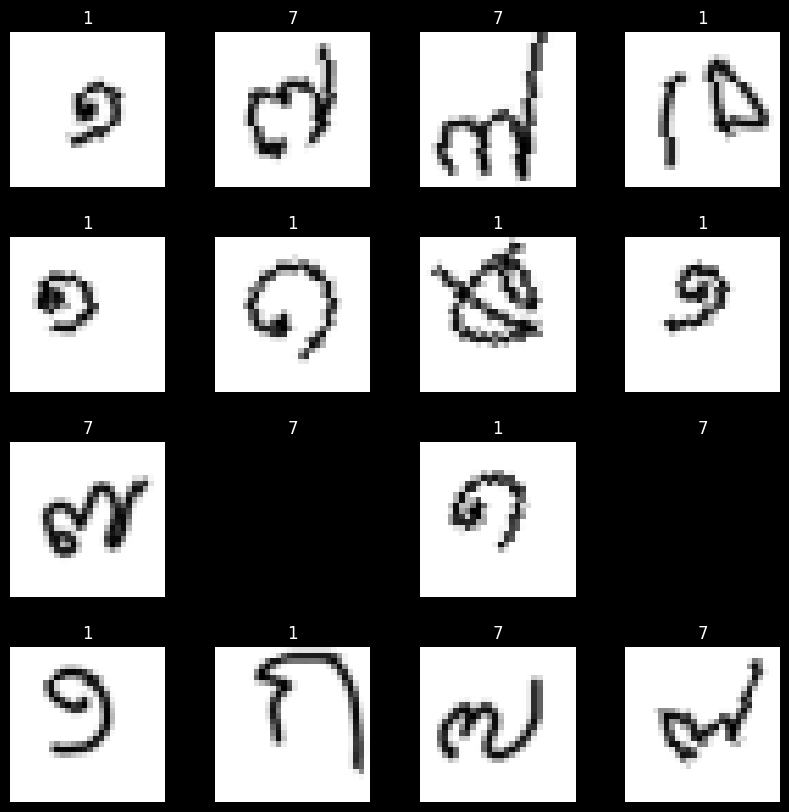

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


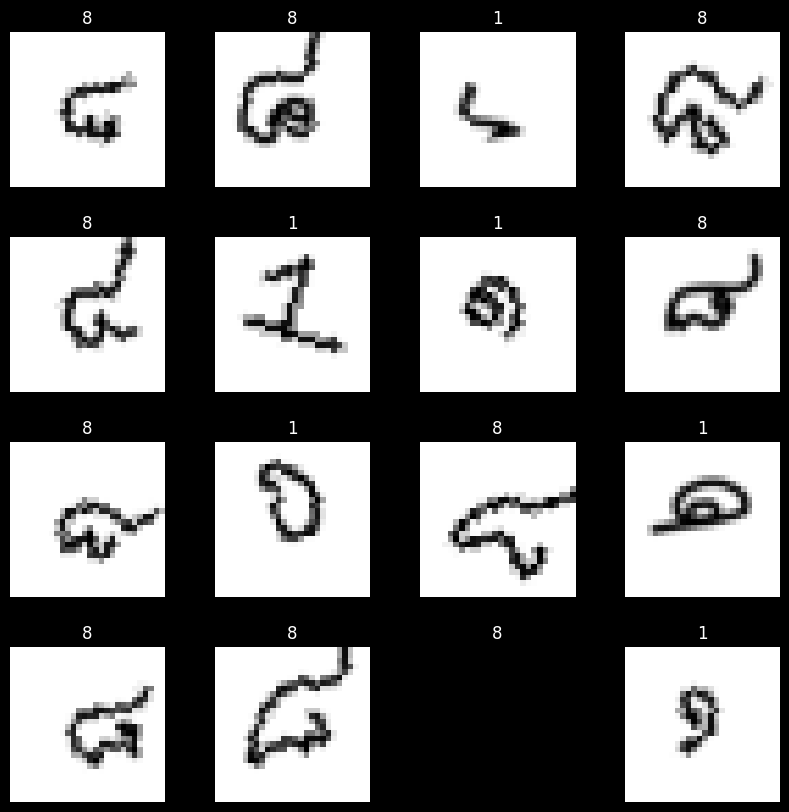

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


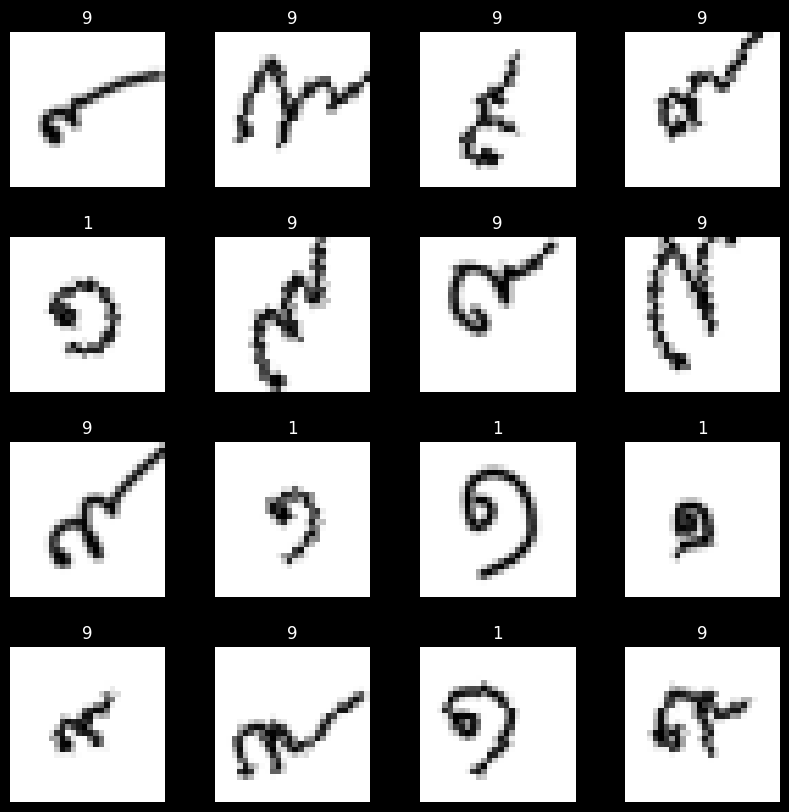

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


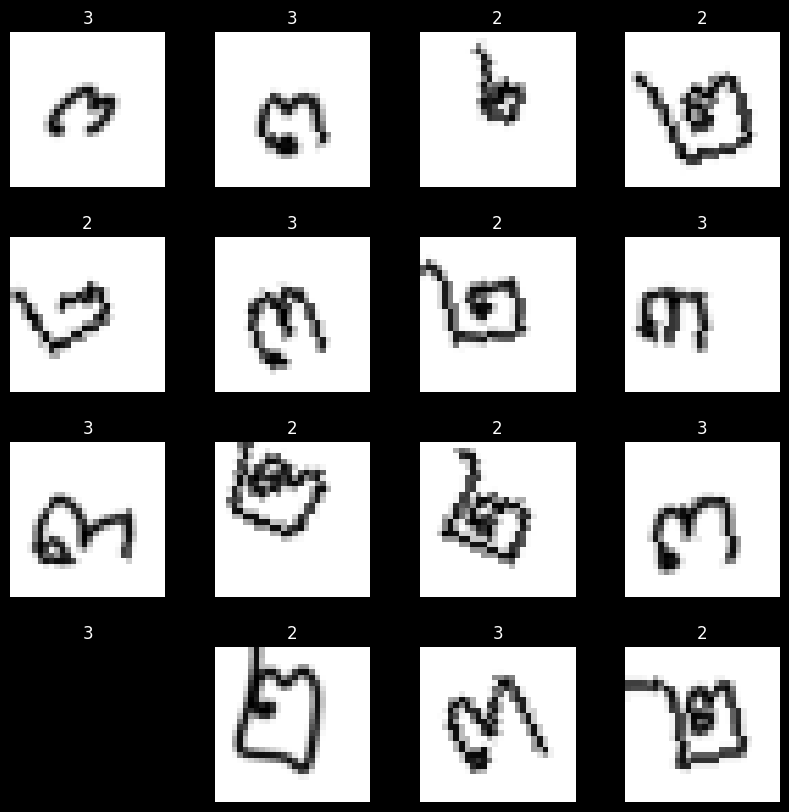

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


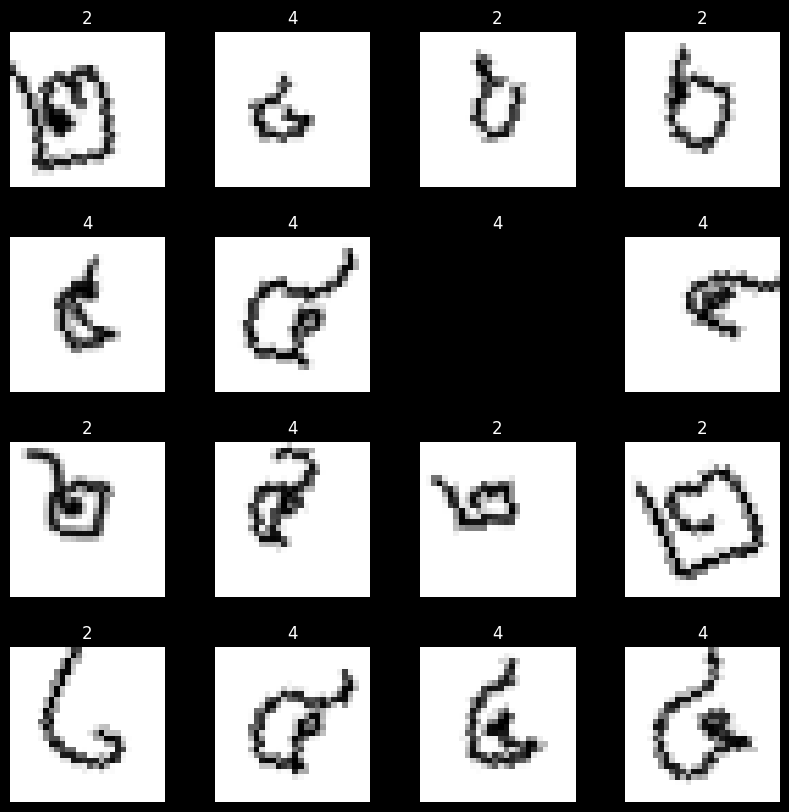

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


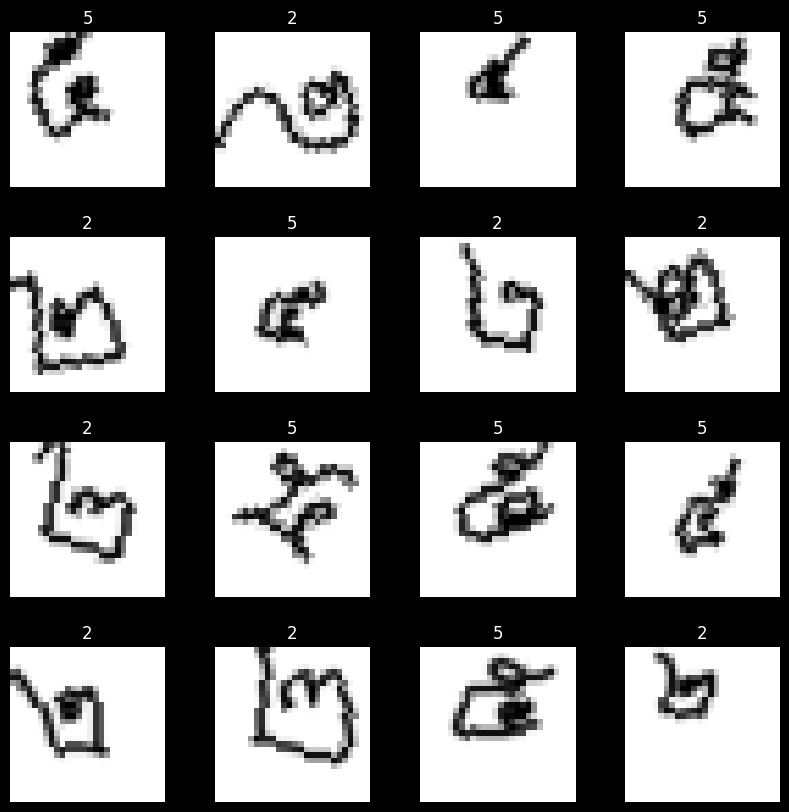

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 256
	Number of train samples: 567
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 65
	Number of test samples: 142


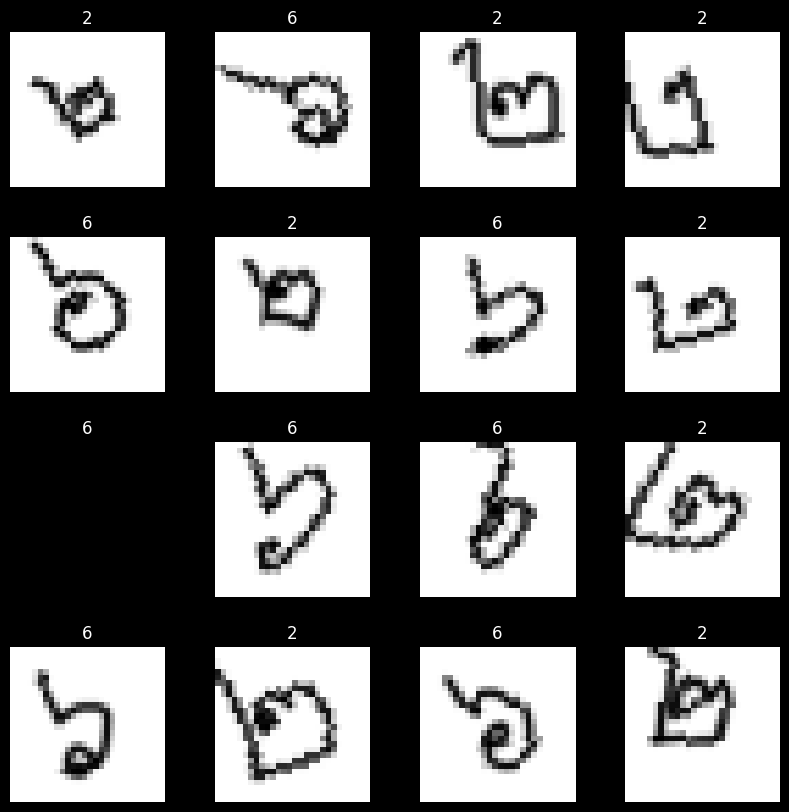

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


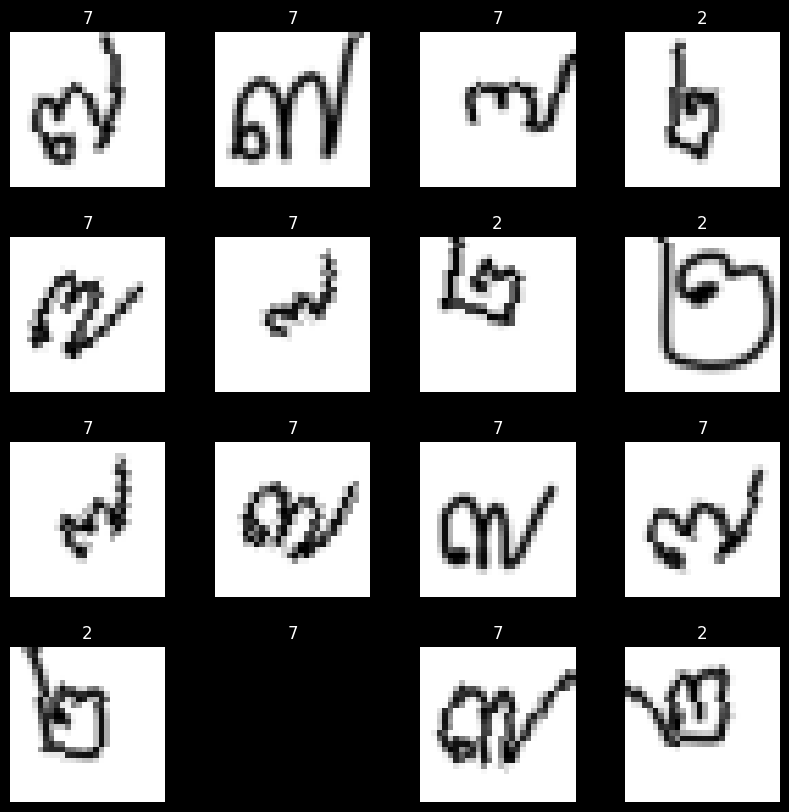

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


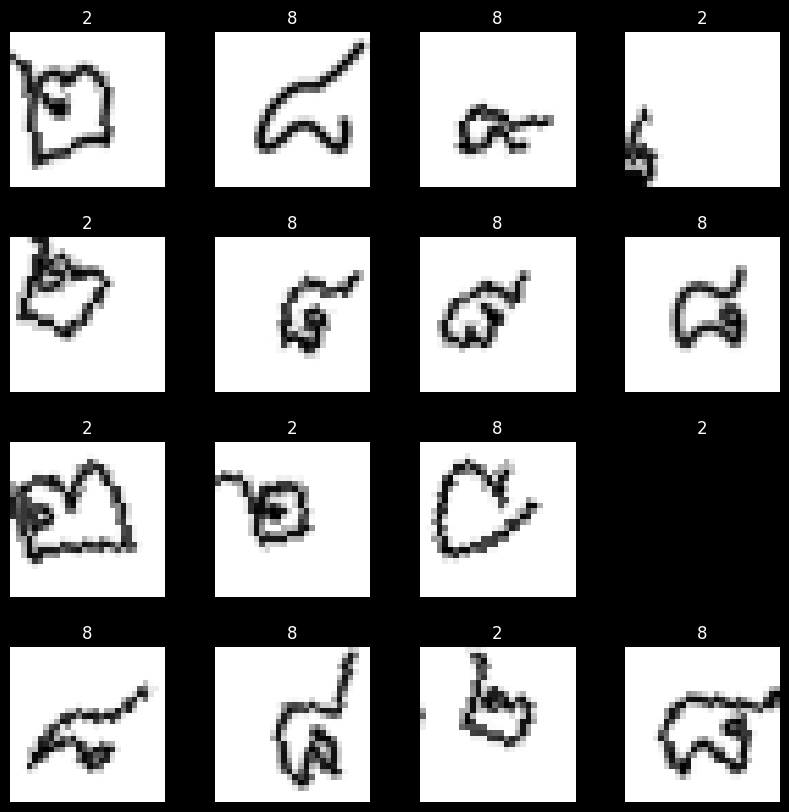

Train Dataset:
	Number of images in class 0: 311
	Number of images in class 1: 310
	Number of train samples: 621
Test Dataset:
	Number of images in class 0: 77
	Number of images in class 1: 79
	Number of test samples: 156


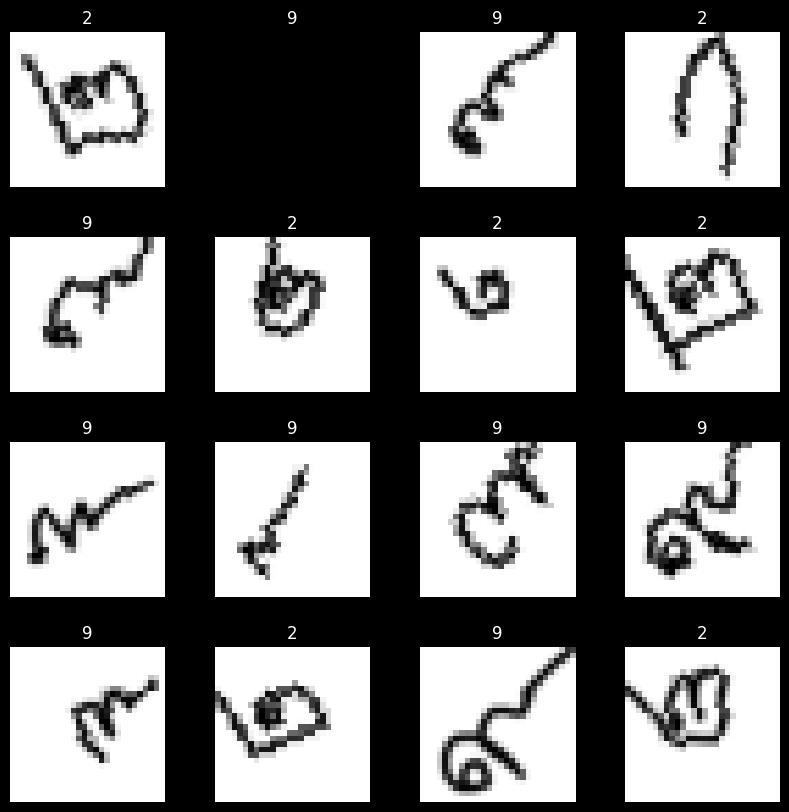

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


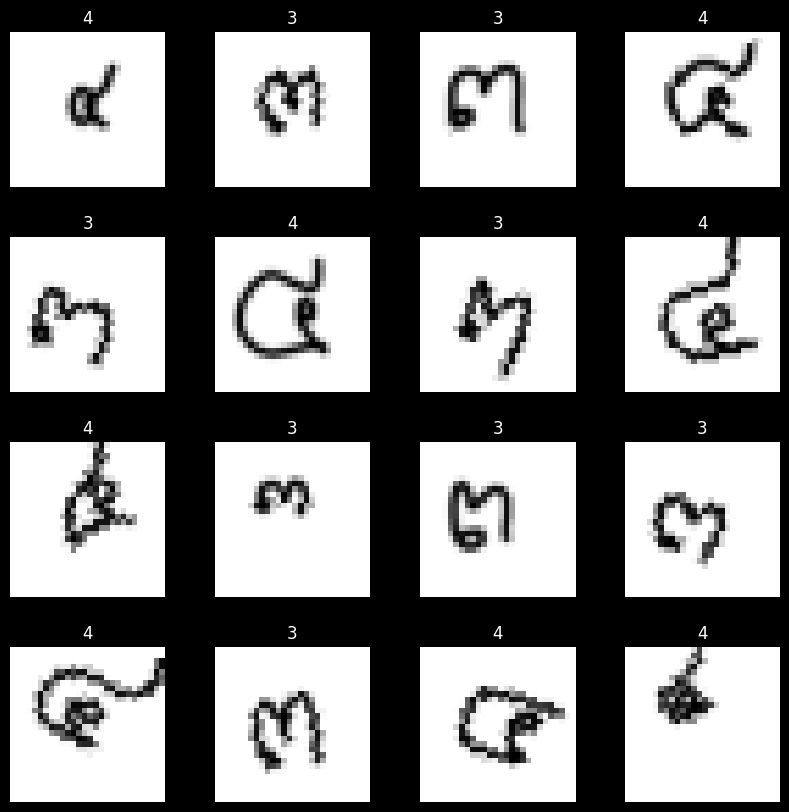

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


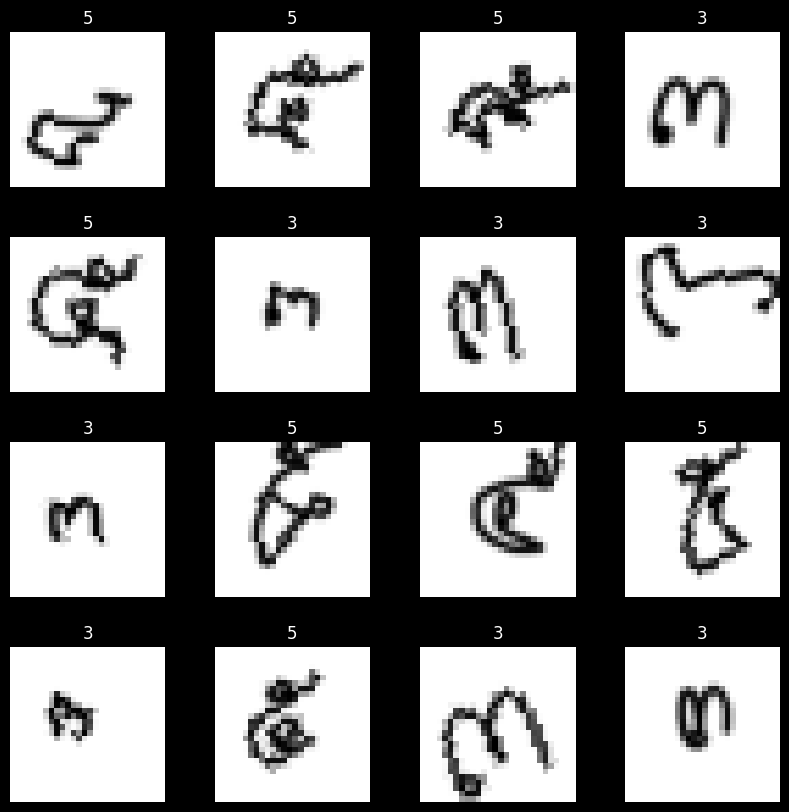

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


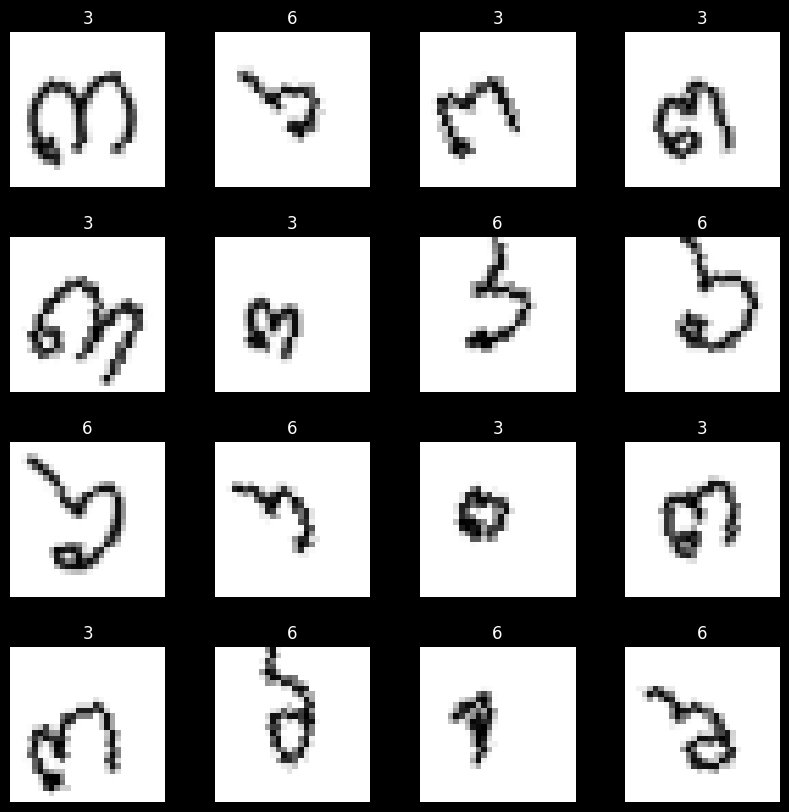

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


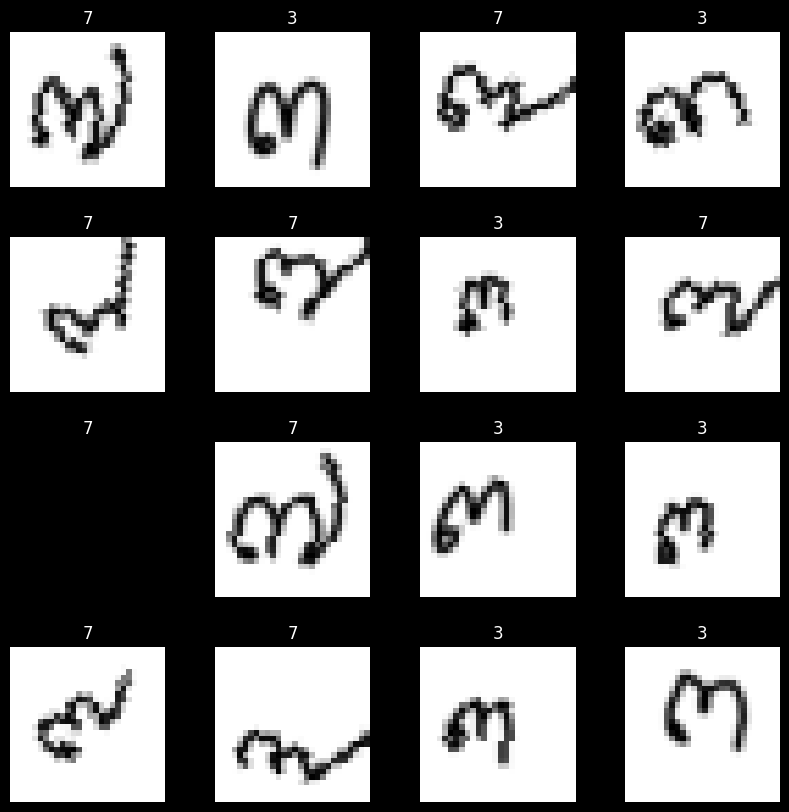

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


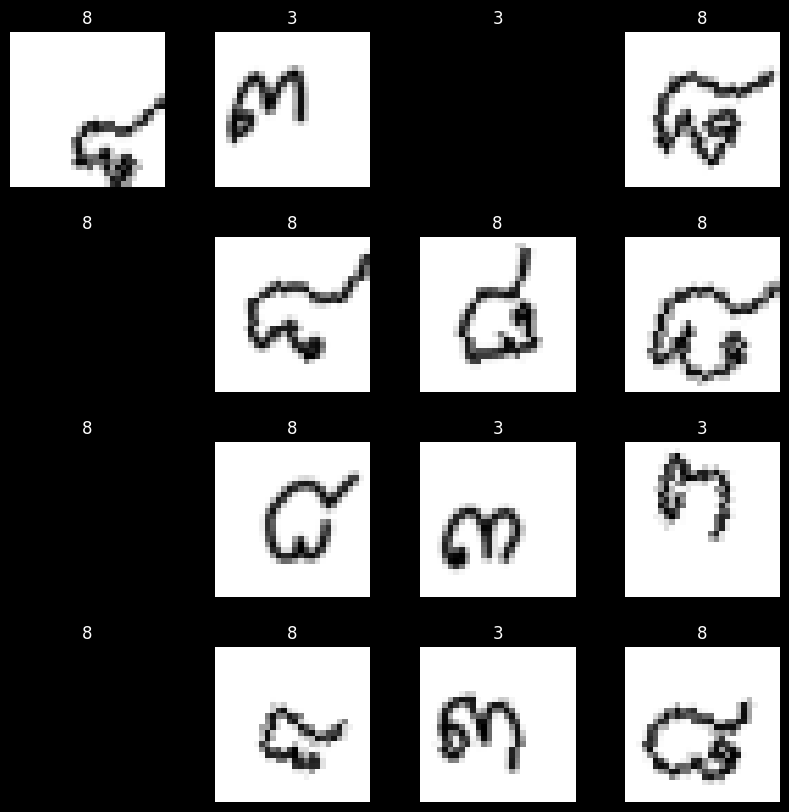

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


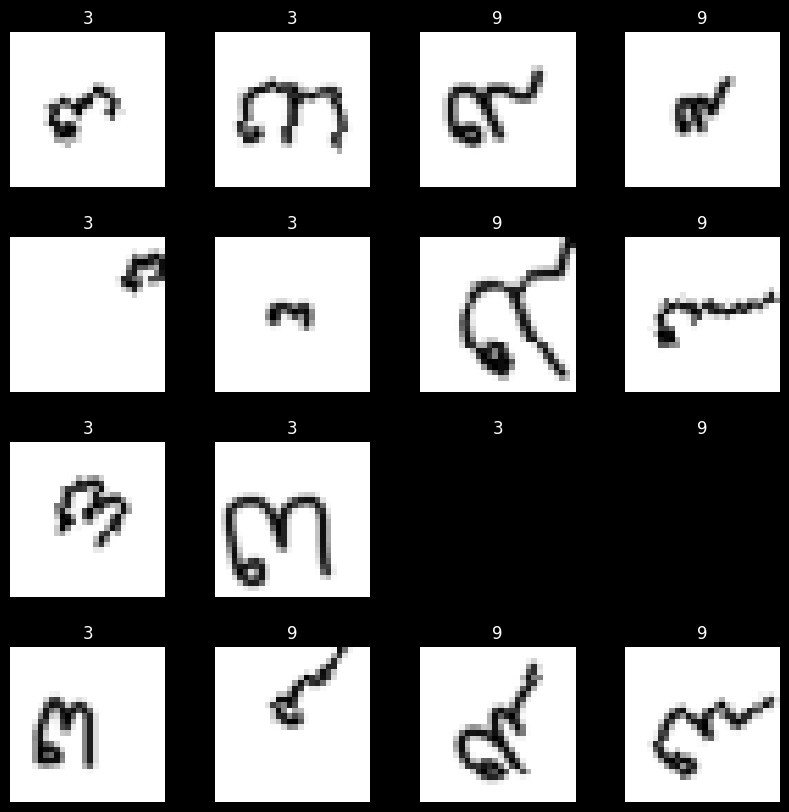

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


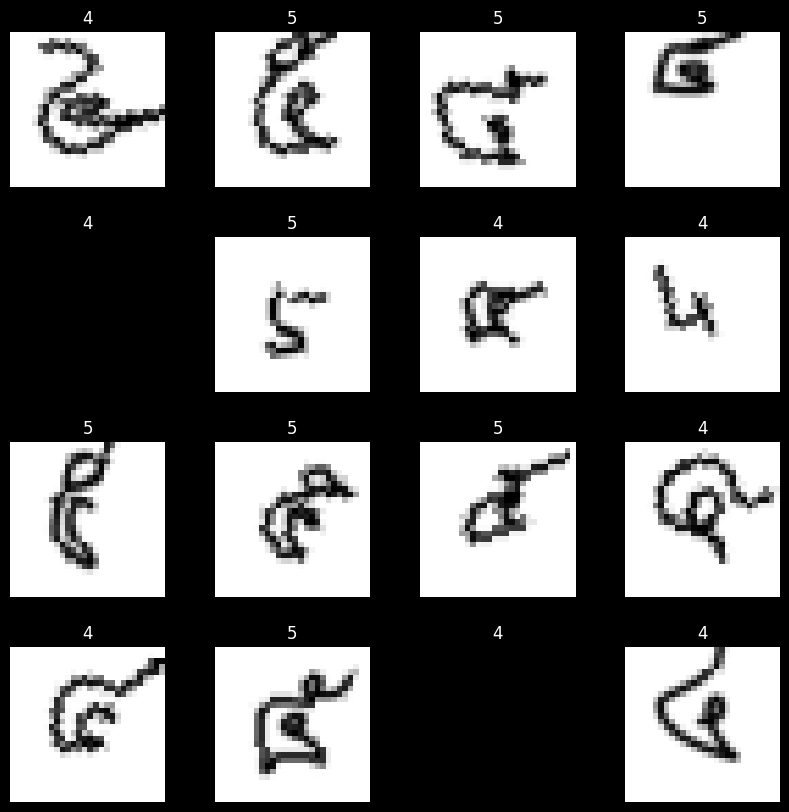

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


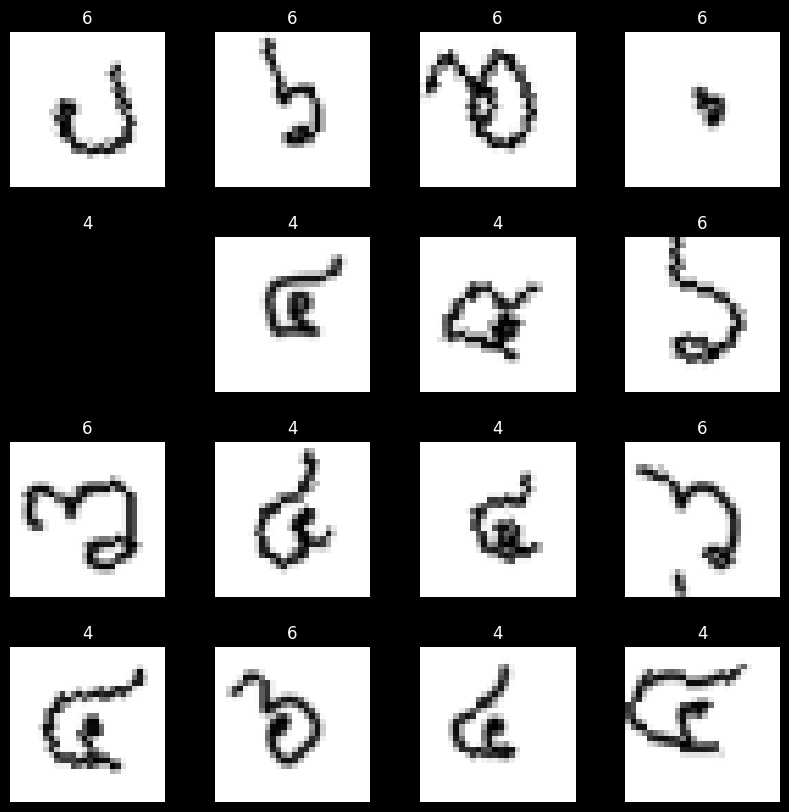

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


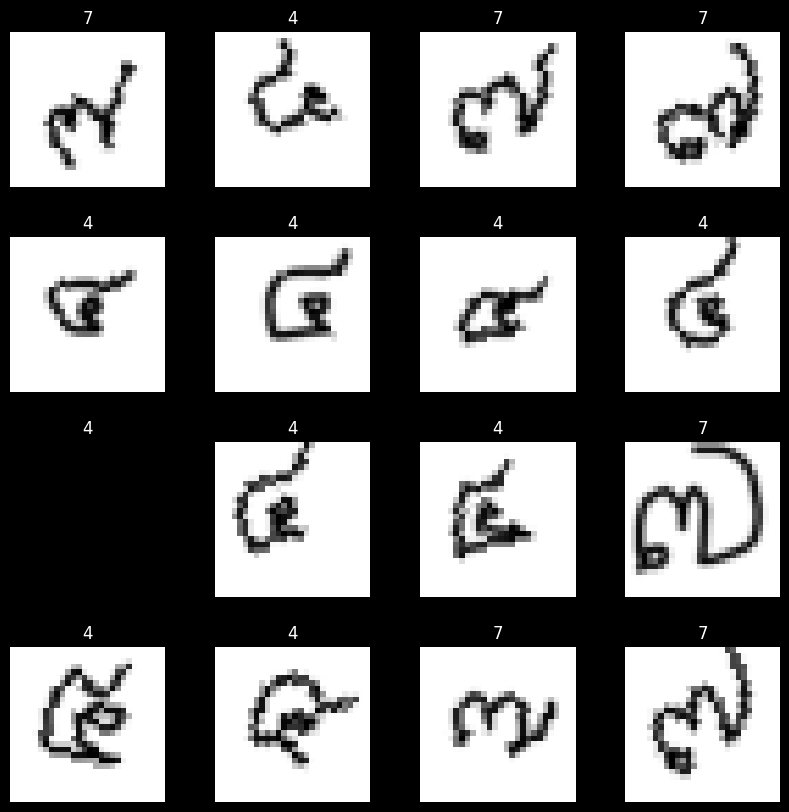

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


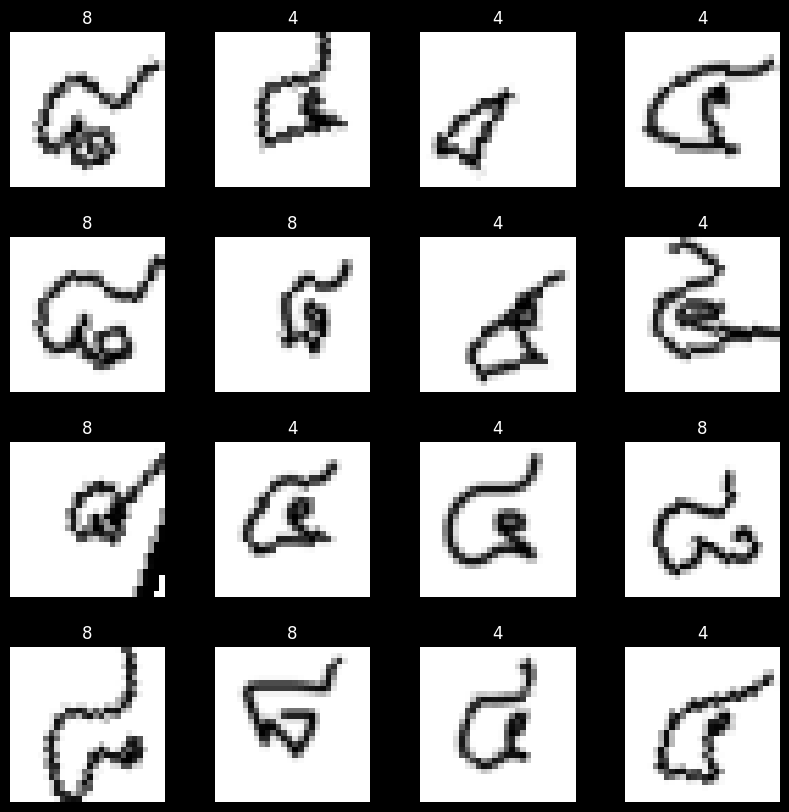

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


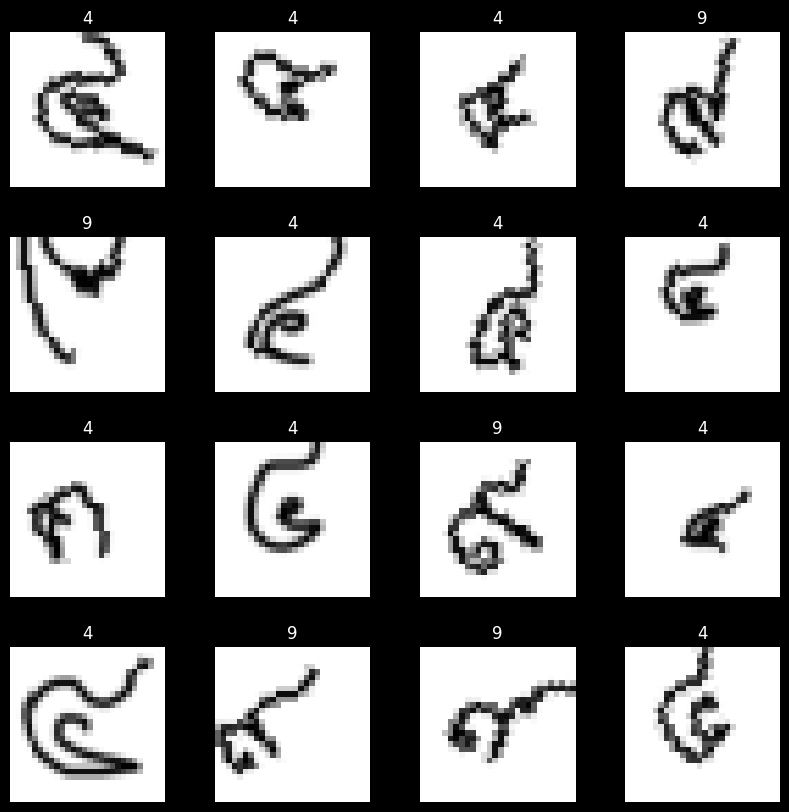

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


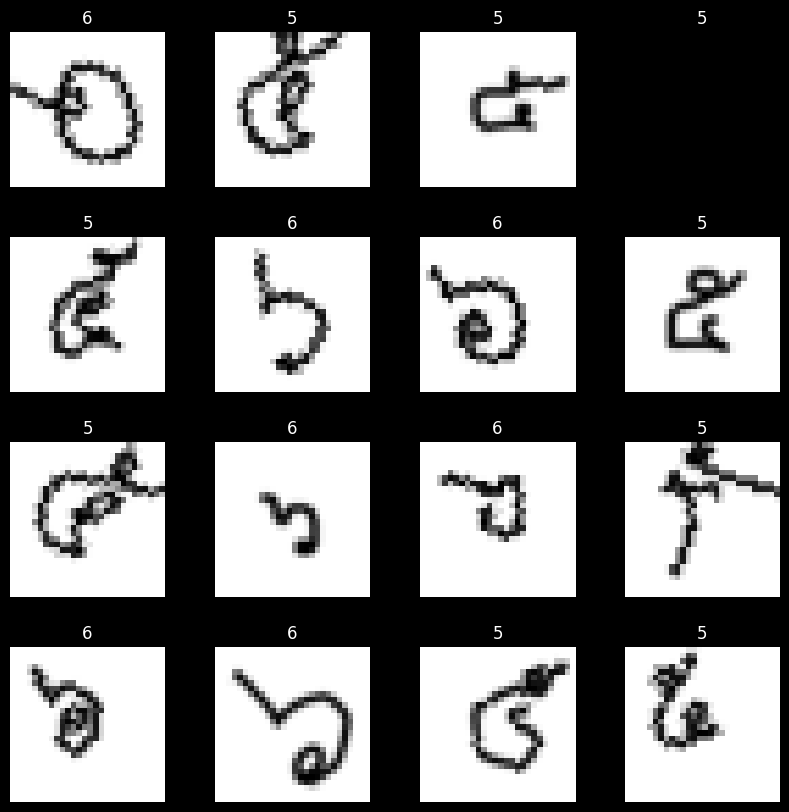

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


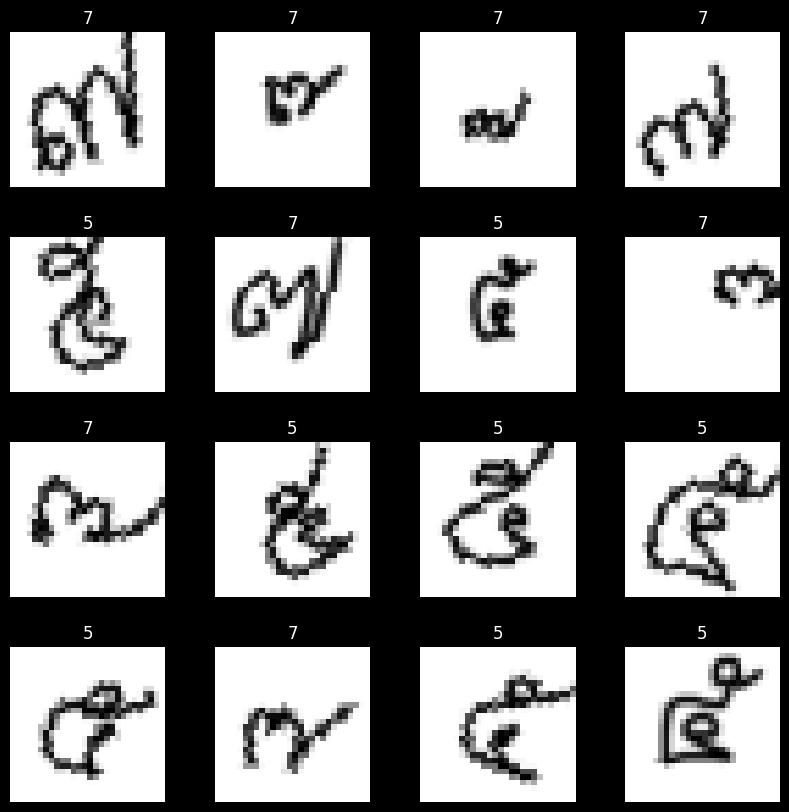

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


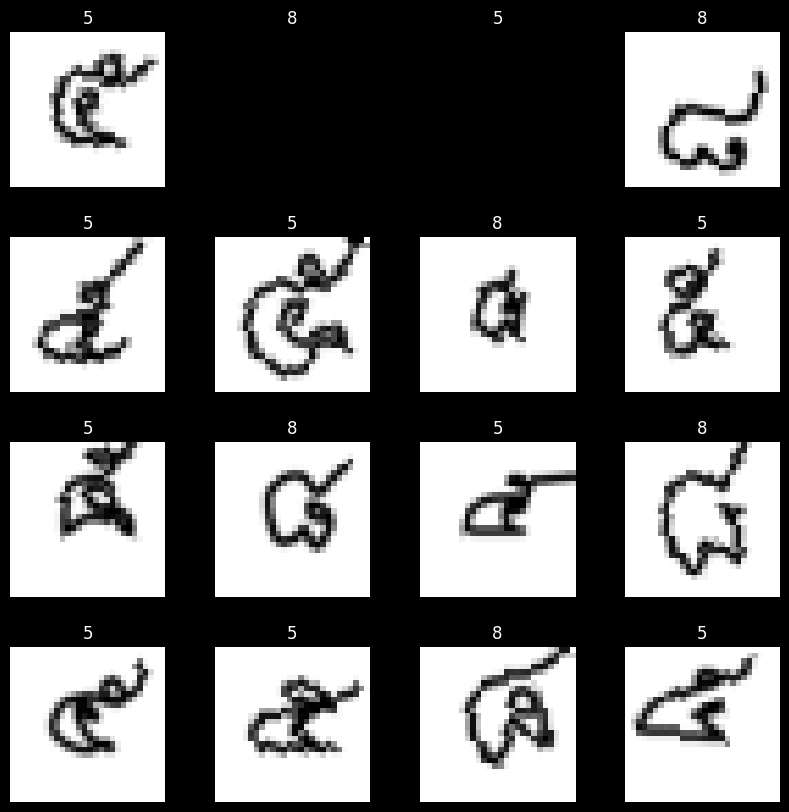

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


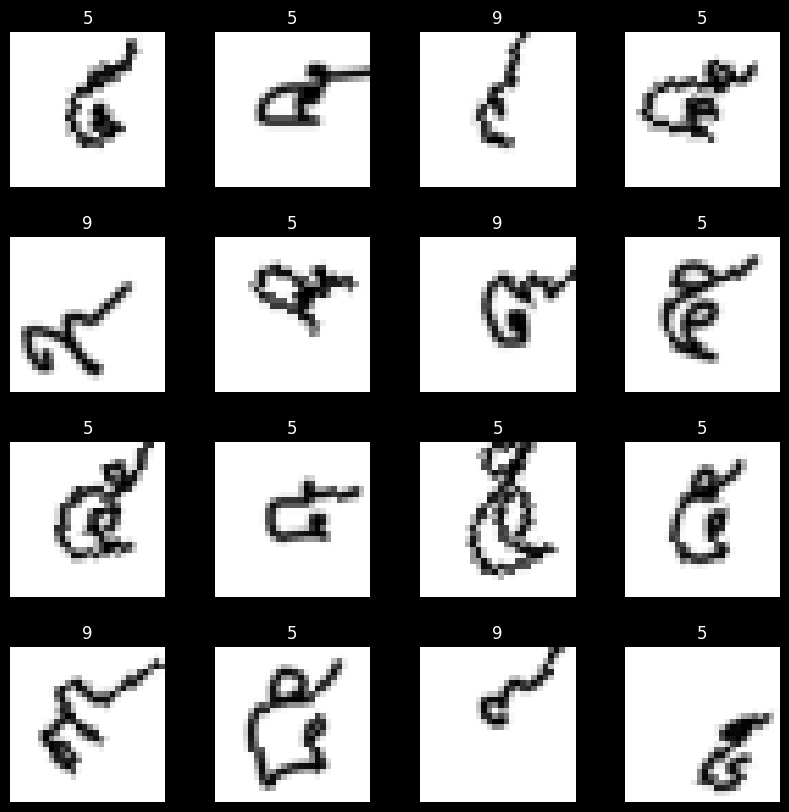

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


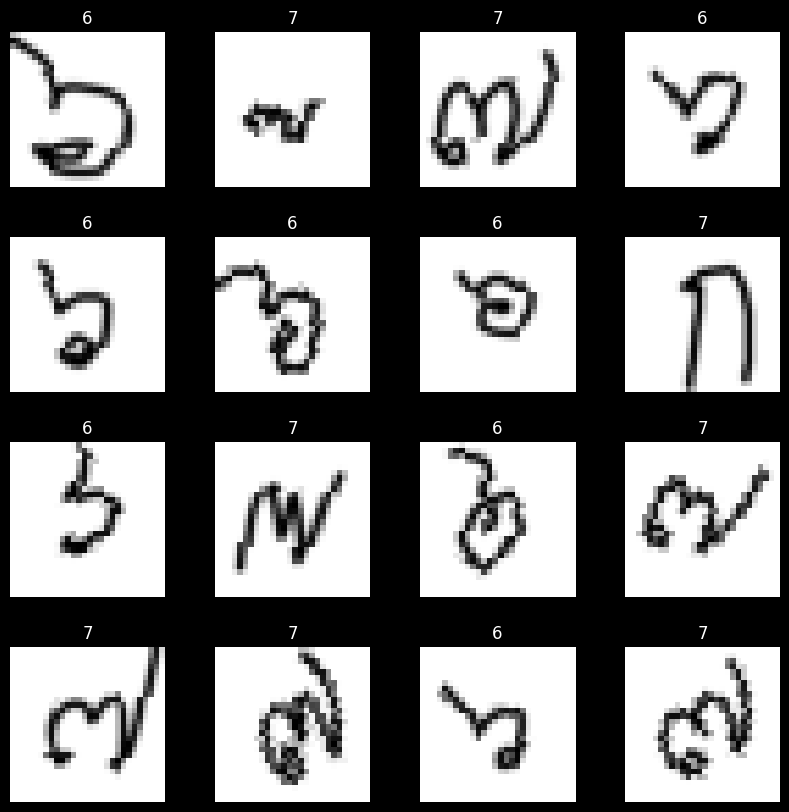

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


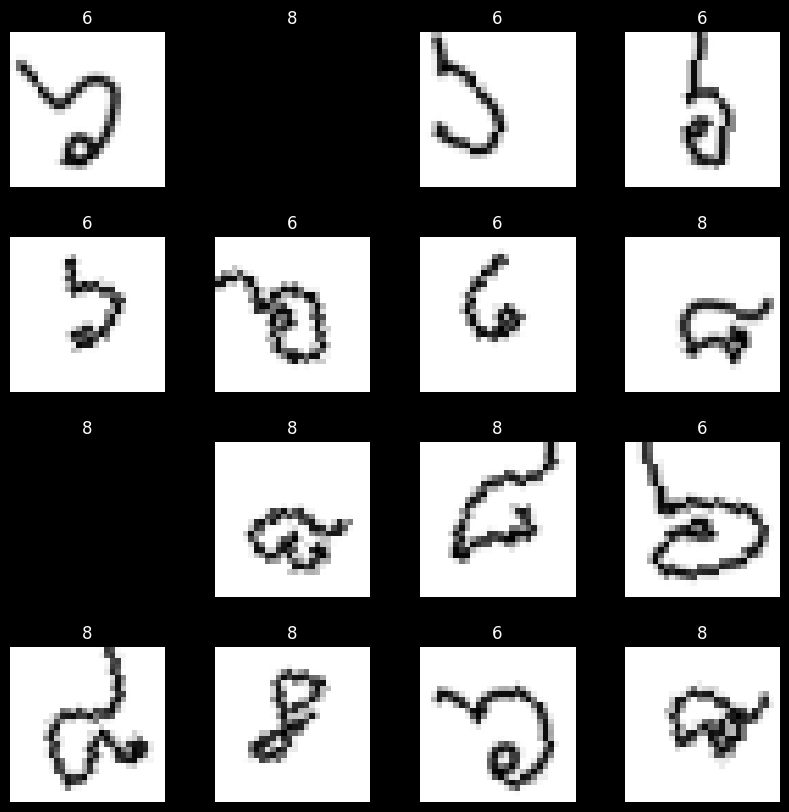

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 256
	Number of train samples: 566
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 64
	Number of test samples: 142


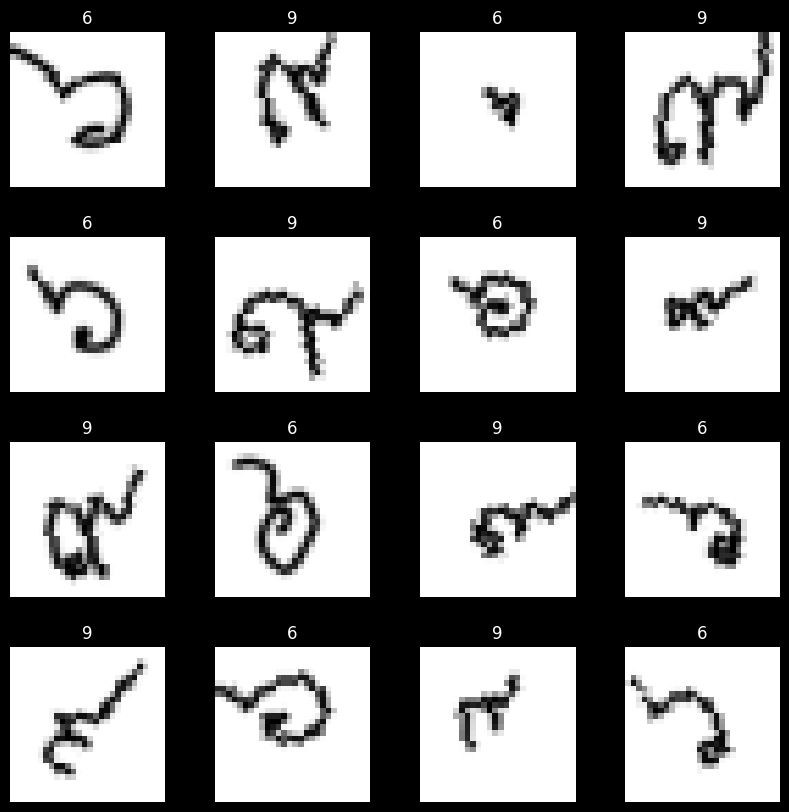

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


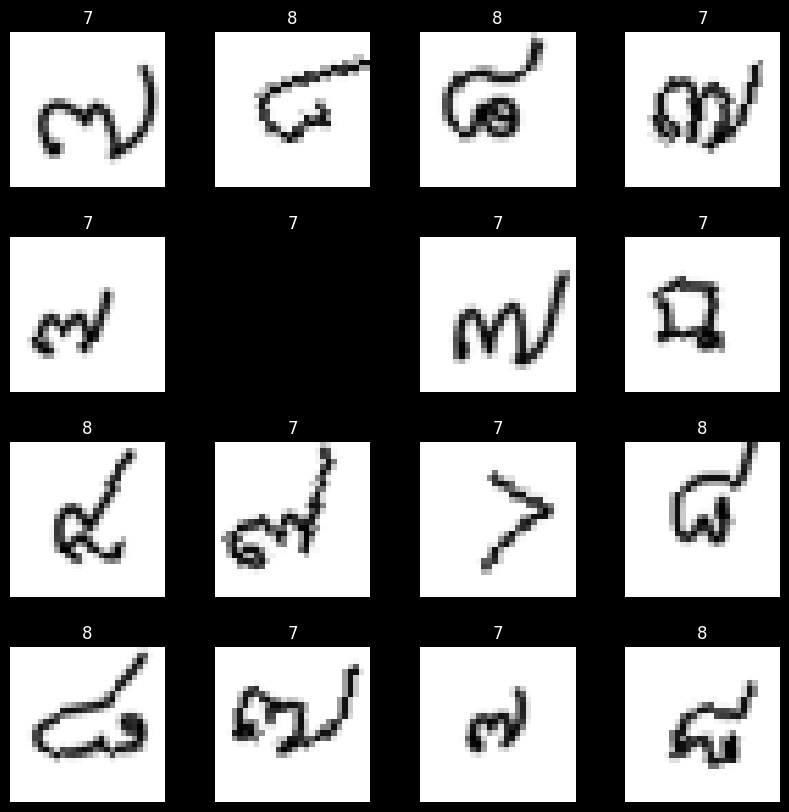

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


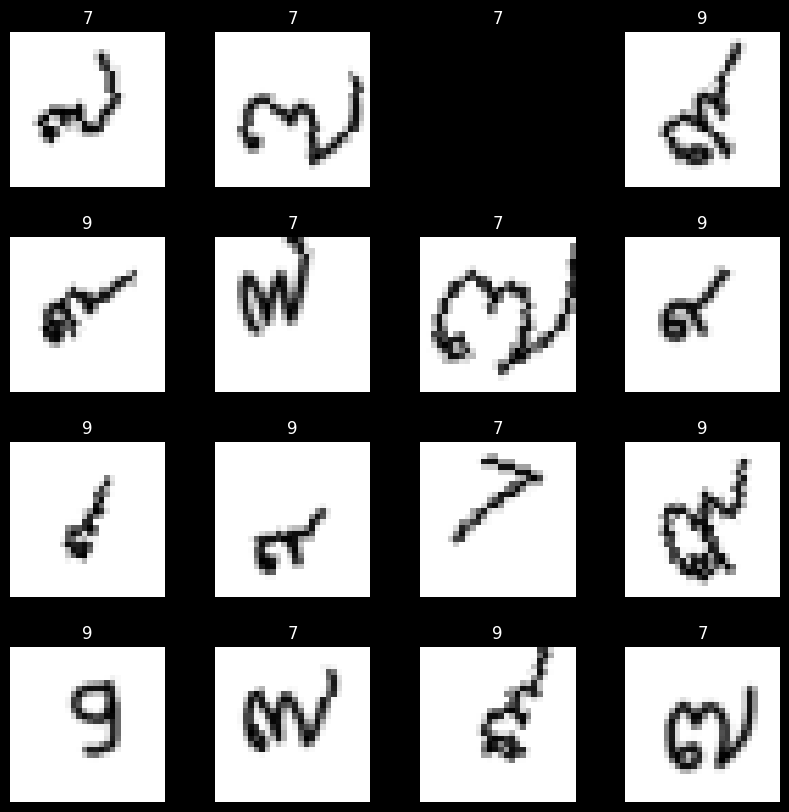

Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 310
	Number of train samples: 620
Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of test samples: 156


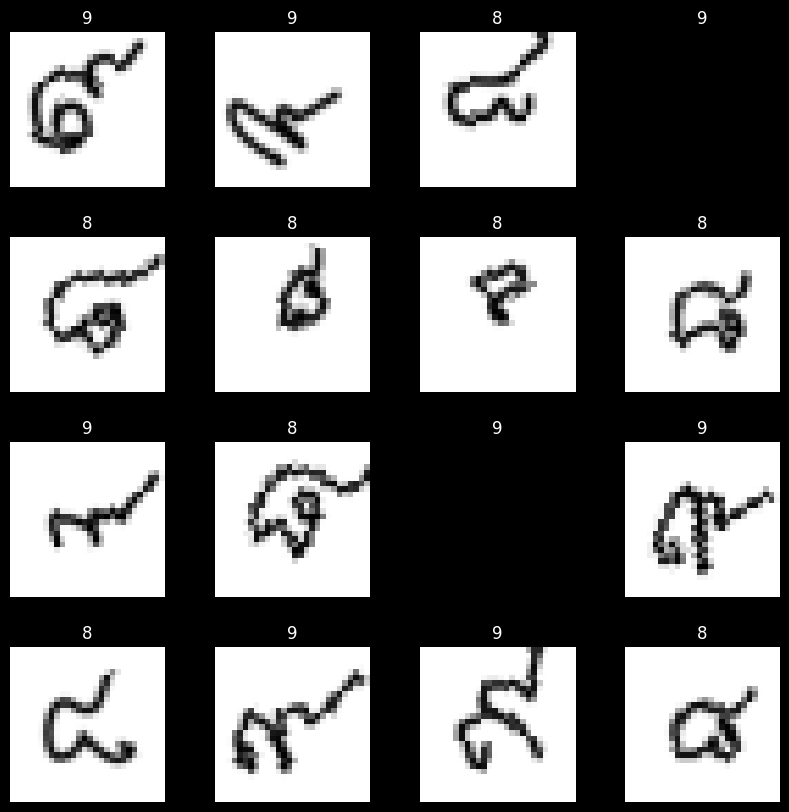

In [59]:
# all class_name and test_loader
combination = []
for i in range(0,10):
      for j in range(1,10):
        if i<j :
            combination.append([str(i),str(j)])
            
cn_and_loader = []
for com in combination:
      class_names = com
      train_loader, test_loader = load_data('thai-handwriting-number.appspot.com',class_names)
      cn_and_loader.append((class_names,train_loader,test_loader))

In [94]:
### START CODE HERE ###

writer = SummaryWriter(log_dir='runs/cnn')

cnn_model = CNN() 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

for cl in cn_and_loader:
    class_names,train_loader,test_loader  = cl

    device = 'cpu'

    cnn_history = train(
        class_names,
        cnn_model,
        optimizer,
        loss_fn,
        train_loader,
        test_loader,
        epochs=5,
        writer=writer,
        checkpoint_path=f"checkpoints/cnn_model/{class_names}.pth",
        device=device,
    )

### END CODE HERE ###

😎✨ Training on 20250802_211001  cpu


Training Epoch [1/5]:   0%|          | 0/39 [00:00<?, ?batch/s]

Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.83batch/s, loss=0.641]


output:  [0.456495463848114, 0.5188601016998291, 0.43315500020980835, 0.42862868309020996, 0.5288112759590149, 0.5001837015151978, 0.49506545066833496, 0.5435059070587158, 0.4582156538963318, 0.43995070457458496, 0.46797242760658264, 0.4386655390262604, 0.4536133408546448]
Predicted:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label:      [0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.28batch/s, loss=0.669]


Epoch 1, Loss: 0.6825, Accuracy: 0.5008, Test Loss: 0.6602, Test Accuracy: 0.5000

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.40batch/s, loss=0.492]


output:  [0.40648582577705383, 0.28001073002815247, 0.2945968508720398, 0.9089755415916443, 0.8265975117683411, 0.5158329010009766, 0.6230482459068298, 0.34089574217796326, 0.29028892517089844, 0.5454261898994446, 0.36241304874420166, 0.2522675096988678, 0.5409440994262695]
Predicted:  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Label:      [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.29batch/s, loss=0.49]


Epoch 2, Loss: 0.5866, Accuracy: 0.6908, Test Loss: 0.5062, Test Accuracy: 0.8077

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 25.73batch/s, loss=0.241]


output:  [0.11373105645179749, 0.09277306497097015, 0.11972176283597946, 0.06565035134553909, 0.4641045033931732, 0.8567719459533691, 0.8449297547340393, 0.27426010370254517, 0.9177058935165405, 0.08536119759082794, 0.5922143459320068, 0.7084272503852844, 0.7703103423118591]
Predicted:  [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Label:      [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.49batch/s, loss=0.336]


Epoch 3, Loss: 0.4538, Accuracy: 0.7971, Test Loss: 0.4660, Test Accuracy: 0.7051

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 25.83batch/s, loss=0.385]


output:  [0.9319483637809753, 0.9847758412361145, 0.12226662039756775, 0.993363618850708, 0.1412217915058136, 0.9272696375846863, 0.8881004452705383, 0.9042324423789978, 0.8614308834075928, 0.5819947719573975, 0.18979966640472412, 0.7376599311828613, 0.4803967773914337]
Predicted:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
Label:      [1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.34batch/s, loss=0.341]


Epoch 4, Loss: 0.3909, Accuracy: 0.8277, Test Loss: 0.4251, Test Accuracy: 0.8654

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.89batch/s, loss=0.279] 


output:  [0.9911604523658752, 0.9781792759895325, 0.30888450145721436, 0.9794660806655884, 0.07138639688491821, 0.9770822525024414, 0.8382156491279602, 0.9861415028572083, 0.9947652816772461, 0.986315906047821, 0.9345213770866394, 0.1741640865802765, 0.07068121433258057]
Predicted:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Label:      [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.29batch/s, loss=0.504]


Epoch 5, Loss: 0.3204, Accuracy: 0.8567, Test Loss: 0.3970, Test Accuracy: 0.8654

writting
😎✨ Training on 20250802_211011  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.25batch/s, loss=0.395]


output:  [0.8348062038421631, 0.09435655176639557, 0.9756736755371094, 0.957791268825531, 0.054390210658311844, 0.36533406376838684, 0.20895272493362427, 0.05362279340624809, 0.9739475250244141, 0.23677313327789307, 0.08721783012151718, 0.8357781171798706, 0.9320346117019653]
Predicted:  [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Label:      [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.43batch/s, loss=0.0762]


Epoch 1, Loss: 0.3755, Accuracy: 0.8325, Test Loss: 0.2791, Test Accuracy: 0.9038

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.04batch/s, loss=0.352] 


output:  [0.9806511998176575, 0.9978001713752747, 0.43275555968284607, 0.413931280374527, 0.9970199465751648, 0.9042052030563354, 0.11303326487541199, 0.8715605139732361, 0.010941567830741405, 0.012400282546877861, 0.8468328714370728, 0.009816846810281277, 0.19268512725830078]
Predicted:  [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0]
Label:      [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.20batch/s, loss=0.176]


Epoch 2, Loss: 0.2463, Accuracy: 0.8969, Test Loss: 0.2705, Test Accuracy: 0.8910

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.84batch/s, loss=0.198] 


output:  [0.9850001335144043, 0.10140205174684525, 0.980191707611084, 0.0464196540415287, 0.9990666508674622, 0.9996017813682556, 0.12017093598842621, 0.9885783195495605, 0.9997089505195618, 0.7806140184402466, 0.2604992687702179, 0.06840687990188599, 0.2969955503940582]
Predicted:  [1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0]
Label:      [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.56batch/s, loss=0.0668]


Epoch 3, Loss: 0.1993, Accuracy: 0.9163, Test Loss: 0.2801, Test Accuracy: 0.9359

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.53batch/s, loss=0.12]  


output:  [0.007761938963085413, 0.6538200378417969, 0.007764018140733242, 0.999852180480957, 0.9992190599441528, 0.9999191761016846, 0.9990352392196655, 0.010753895156085491, 0.00842053908854723, 0.010529821738600731, 0.00441450159996748, 0.6676731705665588, 0.9558168649673462]
Predicted:  [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
Label:      [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.99batch/s, loss=0.598]


Epoch 4, Loss: 0.1546, Accuracy: 0.9308, Test Loss: 0.2489, Test Accuracy: 0.9295

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 26.28batch/s, loss=0.0365]


output:  [0.0021397543605417013, 0.996239185333252, 0.9758090376853943, 0.9999819993972778, 0.9901162981987, 0.9997437596321106, 0.05272781848907471, 0.9998020529747009, 0.2774668037891388, 0.9967600703239441, 0.999947190284729, 0.031551964581012726, 0.981532633304596]
Predicted:  [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
Label:      [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.47batch/s, loss=0.483]


Epoch 5, Loss: 0.1637, Accuracy: 0.9324, Test Loss: 0.2319, Test Accuracy: 0.9167

writting
😎✨ Training on 20250802_211020  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 27.57batch/s, loss=0.138]


output:  [0.9800125956535339, 0.5188300013542175, 0.7805153131484985, 0.9947682619094849, 0.05355251953005791, 0.9778074026107788, 0.9954138994216919, 0.03888341411948204, 0.31470176577568054, 0.0544726699590683, 0.06453423947095871, 0.024316493421792984]
Predicted:  [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Label:      [1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.56batch/s, loss=0.128]


Epoch 1, Loss: 0.3253, Accuracy: 0.8581, Test Loss: 0.3499, Test Accuracy: 0.8269

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.55batch/s, loss=0.168]


output:  [0.5106309652328491, 0.020999493077397346, 0.00463239336386323, 0.9128434658050537, 0.0162590853869915, 0.0036965867038816214, 0.03437648341059685, 0.34379202127456665, 0.9721090793609619, 0.9722210168838501, 0.9964099526405334, 0.9979745745658875]
Predicted:  [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Label:      [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.06batch/s, loss=0.0676]


Epoch 2, Loss: 0.2737, Accuracy: 0.8629, Test Loss: 0.2759, Test Accuracy: 0.9038

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 25.35batch/s, loss=0.168] 


output:  [0.0015832583885639906, 0.9892667531967163, 0.0005491221090778708, 0.36078014969825745, 0.36078014969825745, 0.3705233335494995, 0.014001230709254742, 0.9565859436988831, 0.036746785044670105, 0.9998410940170288, 0.015722529962658882, 0.008627069182693958]
Predicted:  [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Label:      [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.68batch/s, loss=0.401]


Epoch 3, Loss: 0.1981, Accuracy: 0.9113, Test Loss: 0.3118, Test Accuracy: 0.9295

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 25.38batch/s, loss=0.146] 


output:  [0.15818056464195251, 0.9841977953910828, 0.9925668239593506, 0.957411527633667, 0.010873252525925636, 0.36094242334365845, 0.007573043927550316, 0.0009766536531969905, 0.36094242334365845, 0.027767596766352654, 0.9998661279678345, 0.9995893836021423]
Predicted:  [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
Label:      [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.80batch/s, loss=0.135]


Epoch 4, Loss: 0.1879, Accuracy: 0.9145, Test Loss: 0.2636, Test Accuracy: 0.9167

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 26.95batch/s, loss=0.0675]


output:  [0.0013152650790289044, 0.9999499320983887, 0.01547485962510109, 0.6924957036972046, 0.001153368386439979, 0.00564187066629529, 0.004028310999274254, 0.03625180199742317, 0.002053777687251568, 0.7548246383666992, 0.930914580821991, 0.977058470249176]
Predicted:  [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
Label:      [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.05batch/s, loss=0.487]


Epoch 5, Loss: 0.1578, Accuracy: 0.9258, Test Loss: 0.2665, Test Accuracy: 0.9295

writting
😎✨ Training on 20250802_211030  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 28.75batch/s, loss=0.229]  


output:  [0.9968774318695068, 0.9859566688537598, 0.3381520211696625, 0.9993394017219543, 0.3381520211696625, 0.0005973968654870987, 0.984003484249115, 0.3381520211696625, 0.9978047013282776, 0.05836820229887962, 0.938918948173523, 0.9905714988708496]
Predicted:  [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1]
Label:      [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.78batch/s, loss=0.143]


Epoch 1, Loss: 0.2029, Accuracy: 0.9161, Test Loss: 0.2457, Test Accuracy: 0.9167

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.76batch/s, loss=0.00981]


output:  [0.021580947563052177, 0.9836227297782898, 0.0052627939730882645, 0.004920829087495804, 0.9641236066818237, 0.0008928460301831365, 0.01353265717625618, 0.00400579534471035, 0.0007311974186450243, 0.9987525939941406, 0.989153265953064, 0.9988170862197876]
Predicted:  [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]
Label:      [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.13batch/s, loss=0.0433]


Epoch 2, Loss: 0.1485, Accuracy: 0.9355, Test Loss: 0.2431, Test Accuracy: 0.9295

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.22batch/s, loss=0.0417]


output:  [0.35459017753601074, 0.012910814024508, 0.9914582371711731, 0.9995417594909668, 0.0008892606711015105, 0.0011751760030165315, 0.001268134918063879, 0.02670000120997429, 0.00023986129963304847, 0.9955547451972961, 0.994756817817688, 0.9992647767066956]
Predicted:  [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
Label:      [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.51batch/s, loss=0.365]


Epoch 3, Loss: 0.1386, Accuracy: 0.9403, Test Loss: 0.2340, Test Accuracy: 0.9295

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.95batch/s, loss=0.0774]


output:  [1.9481542040011846e-05, 0.9798649549484253, 0.0033854255452752113, 0.00036495152744464576, 0.9999459981918335, 0.00016607313591521233, 0.009533011354506016, 0.43117180466651917, 0.00010462027421453968, 0.0026352533604949713, 0.04919929802417755, 0.9990830421447754]
Predicted:  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]
Label:      [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.83batch/s, loss=0.0084]


Epoch 4, Loss: 0.1237, Accuracy: 0.9371, Test Loss: 0.7539, Test Accuracy: 0.9359

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 23.26batch/s, loss=0.00247]


output:  [0.9972545504570007, 0.0005257937591522932, 2.2048934624763206e-05, 0.0007599529926665127, 0.013417147099971771, 0.9999654293060303, 0.0003274363116361201, 0.001941594062373042, 0.00010827440564753488, 0.9999122619628906, 0.9911509156227112, 0.0006357287638820708]
Predicted:  [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]
Label:      [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.58batch/s, loss=0.045]


Epoch 5, Loss: 0.1269, Accuracy: 0.9355, Test Loss: 0.2137, Test Accuracy: 0.9359

writting
😎✨ Training on 20250802_211039  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.76batch/s, loss=0.562]   


output:  [0.002079562982544303, 0.000551912875380367, 0.8817601799964905, 0.35458269715309143, 0.04359747841954231, 0.9978545308113098, 0.09049944579601288, 0.0003515364369377494, 0.2535324990749359, 0.9906051754951477, 0.05915040895342827, 0.9999948740005493]
Predicted:  [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]
Label:      [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.03batch/s, loss=0.309] 


Epoch 1, Loss: 0.1384, Accuracy: 0.9306, Test Loss: 0.7365, Test Accuracy: 0.9231

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.16batch/s, loss=0.327]  


output:  [0.9994872808456421, 0.999729573726654, 8.072672062553465e-05, 0.9990063309669495, 0.4445159435272217, 0.01366795226931572, 0.00015780795365571976, 0.9998847246170044, 0.0009890500223264098, 0.006237811874598265, 0.03641410917043686, 0.004729773849248886]
Predicted:  [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Label:      [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.53batch/s, loss=0.0342]


Epoch 2, Loss: 0.1068, Accuracy: 0.9435, Test Loss: 0.7550, Test Accuracy: 0.9359

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.53batch/s, loss=0.146]  


output:  [0.0007696188986301422, 0.9999890327453613, 0.4198682904243469, 0.0002529216289985925, 0.009681753814220428, 0.005399640183895826, 0.0002980854478664696, 0.9999997615814209, 0.4198682904243469, 0.0012072576209902763, 0.9999902248382568, 0.9999165534973145]
Predicted:  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
Label:      [0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.94batch/s, loss=0.225]


Epoch 3, Loss: 0.0858, Accuracy: 0.9532, Test Loss: 0.7479, Test Accuracy: 0.9295

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.46batch/s, loss=0.00585]


output:  [1.0, 0.9999997615814209, 0.9999966621398926, 7.90152043919079e-05, 0.9999794960021973, 0.9999961853027344, 0.00014880599337629974, 0.9999574422836304, 0.06310351192951202, 0.9999967813491821, 0.9952965378761292, 0.9999915361404419]
Predicted:  [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Label:      [1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.47batch/s, loss=8.46]  


Epoch 4, Loss: 0.0984, Accuracy: 0.9468, Test Loss: 0.9717, Test Accuracy: 0.9359

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.50batch/s, loss=0.0736]  


output:  [0.9999959468841553, 0.4272843897342682, 0.9999995231628418, 0.01515403762459755, 0.00048729684203863144, 1.3238519386504777e-05, 0.0011402381351217628, 0.015791473910212517, 0.9999988079071045, 0.0003794590593315661, 0.9999954700469971, 0.9999998807907104]
Predicted:  [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Label:      [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.32batch/s, loss=0.12] 


Epoch 5, Loss: 0.0822, Accuracy: 0.9532, Test Loss: 0.7341, Test Accuracy: 0.9295

writting
😎✨ Training on 20250802_211049  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 25.48batch/s, loss=0.132] 


output:  [0.0008984759333543479, 0.9999641180038452, 0.021109795197844505, 0.4808022081851959, 0.9693259596824646, 0.0061541409231722355]
Predicted:  [0, 1, 0, 0, 1, 0]
Label:      [0, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.82batch/s, loss=0.193]


Epoch 1, Loss: 0.2917, Accuracy: 0.8640, Test Loss: 1.0583, Test Accuracy: 0.8662

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 24.57batch/s, loss=0.0782] 


output:  [0.9995676875114441, 0.005500698462128639, 0.0005029523745179176, 0.9998749494552612, 0.36944493651390076, 0.9982420206069946]
Predicted:  [1, 0, 0, 1, 0, 1]
Label:      [1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.76batch/s, loss=0.0579]


Epoch 2, Loss: 0.2057, Accuracy: 0.8975, Test Loss: 0.8955, Test Accuracy: 0.9296

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 23.77batch/s, loss=0.159] 


output:  [0.366102010011673, 0.9911133646965027, 0.005208875983953476, 0.9985297918319702, 0.7741014361381531, 0.20230551064014435]
Predicted:  [0, 1, 0, 1, 1, 0]
Label:      [0, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 27.15batch/s, loss=0.0675]


Epoch 3, Loss: 0.1669, Accuracy: 0.9258, Test Loss: 0.2540, Test Accuracy: 0.9296

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 23.52batch/s, loss=0.141] 


output:  [0.008349202573299408, 1.3247979040897917e-05, 0.98529052734375, 0.9903790950775146, 0.9998220801353455, 0.4448838531970978]
Predicted:  [0, 0, 1, 1, 1, 0]
Label:      [0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 27.62batch/s, loss=0.364] 


Epoch 4, Loss: 0.1459, Accuracy: 0.9382, Test Loss: 0.2365, Test Accuracy: 0.9437

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 24.17batch/s, loss=0.184] 


output:  [0.025496549904346466, 0.4075549840927124, 1.4440764061873779e-05, 0.8897467255592346, 0.9999325275421143, 0.9373858571052551]
Predicted:  [0, 0, 0, 1, 1, 1]
Label:      [0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 26.87batch/s, loss=0.0554]


Epoch 5, Loss: 0.1174, Accuracy: 0.9488, Test Loss: 0.8947, Test Accuracy: 0.9296

writting
😎✨ Training on 20250802_211058  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 25.11batch/s, loss=0.0162]


output:  [0.00013857493468094617, 0.0015144416829571128, 9.917287388816476e-05, 0.04537544772028923, 0.00043049509986303747, 0.9322252869606018, 0.012970661744475365, 0.00010498453775653616, 0.9998340606689453, 0.9709264039993286, 0.9711299538612366, 0.9970790147781372]
Predicted:  [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Label:      [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.05batch/s, loss=0.0145]


Epoch 1, Loss: 0.1526, Accuracy: 0.9274, Test Loss: 0.2212, Test Accuracy: 0.9359

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 28.05batch/s, loss=0.146]  


output:  [0.44546759128570557, 0.00010412293340777978, 0.000294994271825999, 0.9999417066574097, 0.9815311431884766, 0.9983605742454529, 0.9414556622505188, 0.9995636343955994, 0.9999995231628418, 0.00012697836791630834, 0.4234252870082855, 0.9998987913131714]
Predicted:  [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Label:      [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.14batch/s, loss=8.36]  


Epoch 2, Loss: 0.1114, Accuracy: 0.9468, Test Loss: 1.0078, Test Accuracy: 0.9295

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 25.41batch/s, loss=0.0182] 


output:  [0.9993519186973572, 0.999995231628418, 3.155979356961325e-05, 0.9994009733200073, 0.9844158291816711, 0.019719740375876427, 0.00038243536255322397, 0.10304161161184311, 0.006211035884916782, 2.449201565468684e-05, 0.02674609050154686, 0.9617717862129211]
Predicted:  [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Label:      [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.94batch/s, loss=0.0536]


Epoch 3, Loss: 0.0961, Accuracy: 0.9452, Test Loss: 0.7646, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.84batch/s, loss=0.0039] 


output:  [0.0027584827039390802, 0.9982917904853821, 1.0, 0.9956249594688416, 0.00119185377843678, 0.9725916385650635, 0.9999032020568848, 0.999925971031189, 0.999832034111023, 0.000769502657931298, 0.9922877550125122, 0.0001305221376242116]
Predicted:  [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Label:      [0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.34batch/s, loss=0.00407]


Epoch 4, Loss: 0.0872, Accuracy: 0.9548, Test Loss: 0.7445, Test Accuracy: 0.9423

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 25.00batch/s, loss=0.0574] 


output:  [6.845811003586277e-05, 1.9166569472872652e-05, 0.0494014173746109, 0.4458276927471161, 1.0, 0.99009108543396, 0.030145416036248207, 0.9999984502792358, 0.003720648121088743, 6.1904620451969095e-06, 0.9999994039535522, 0.0039354837499558926]
Predicted:  [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]
Label:      [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.86batch/s, loss=0.26]  


Epoch 5, Loss: 0.0835, Accuracy: 0.9548, Test Loss: 0.7741, Test Accuracy: 0.9423

writting
😎✨ Training on 20250802_211108  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.24batch/s, loss=0.0685] 


output:  [0.9999936819076538, 0.9999935626983643, 0.9900550842285156, 0.0003007995546795428, 0.9905421137809753, 0.9991679191589355, 0.9987295269966125, 0.9996888637542725, 0.44977670907974243, 0.9999836683273315, 0.0007119773654267192, 0.00022379052825272083]
Predicted:  [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]
Label:      [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.05batch/s, loss=8.34]  


Epoch 1, Loss: 0.1433, Accuracy: 0.9339, Test Loss: 1.0013, Test Accuracy: 0.9295

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.93batch/s, loss=0.249]  


output:  [0.008757611736655235, 0.0004332891257945448, 0.5117724537849426, 0.9999814033508301, 6.604439840884879e-05, 2.675554469533381e-06, 0.9998483657836914, 0.9742251038551331, 0.9999039173126221, 3.65577288903296e-05, 0.8910858035087585, 0.01759752258658409]
Predicted:  [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0]
Label:      [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 38.88batch/s, loss=0.159]  


Epoch 2, Loss: 0.1259, Accuracy: 0.9323, Test Loss: 0.8177, Test Accuracy: 0.9167

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.77batch/s, loss=0.173]  


output:  [1.6322088413289748e-05, 0.003685819450765848, 0.9999909400939941, 0.06621572375297546, 0.4568842053413391, 0.00020642562594730407, 9.059818694368005e-05, 0.4568842053413391, 0.9997841715812683, 0.0016110895667225122, 0.4568842053413391, 0.9999861717224121]
Predicted:  [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]
Label:      [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.65batch/s, loss=0.00964]


Epoch 3, Loss: 0.1029, Accuracy: 0.9452, Test Loss: 0.8333, Test Accuracy: 0.9295

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.30batch/s, loss=0.0796]


output:  [0.9999676942825317, 0.20021194219589233, 0.9999985694885254, 0.04442751407623291, 0.0003666528209578246, 0.9999479055404663, 0.9996774196624756, 5.80353444092907e-05, 0.21394270658493042, 2.9644912501680665e-05, 0.3588353097438812, 0.9999691247940063]
Predicted:  [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Label:      [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.06batch/s, loss=0.361] 


Epoch 4, Loss: 0.0992, Accuracy: 0.9452, Test Loss: 0.7888, Test Accuracy: 0.9295

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 25.38batch/s, loss=0.0523] 


output:  [0.9999986886978149, 0.9995124340057373, 4.60161952986482e-09, 0.4515756368637085, 3.238688441342674e-05, 0.9993289709091187, 0.9999996423721313, 0.9991414546966553, 0.9757413268089294, 0.9999663829803467, 1.0, 0.00034342275466769934]
Predicted:  [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Label:      [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.68batch/s, loss=0.824]


Epoch 5, Loss: 0.0873, Accuracy: 0.9532, Test Loss: 0.8326, Test Accuracy: 0.9167

writting
😎✨ Training on 20250802_211117  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 21.93batch/s, loss=0.00307]


output:  [7.812130934325978e-05, 0.9999210834503174, 0.9964884519577026, 0.9999959468841553, 0.02839828096330166, 0.0011255901772528887, 4.788248588738497e-06, 0.0004701899888459593, 0.9999996423721313, 0.002778910333290696, 0.9999997615814209, 0.9999768733978271]
Predicted:  [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]
Label:      [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.10batch/s, loss=0.0852]


Epoch 1, Loss: 0.1349, Accuracy: 0.9339, Test Loss: 0.7909, Test Accuracy: 0.9423

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.06batch/s, loss=0.0639] 


output:  [0.9999995231628418, 0.9913315773010254, 0.8972580432891846, 2.3822085495339707e-05, 0.4607654809951782, 0.9999324083328247, 0.9999551773071289, 0.9998464584350586, 0.016986185684800148, 1.0, 0.9942229390144348, 0.009239374659955502]
Predicted:  [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]
Label:      [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.34batch/s, loss=0.103] 


Epoch 2, Loss: 0.0944, Accuracy: 0.9516, Test Loss: 0.7708, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 25.96batch/s, loss=0.00943]


output:  [0.0003841944853775203, 0.0002948215987998992, 0.004373385105282068, 0.00016320229042321444, 0.9705011248588562, 0.06112489104270935, 0.0068662227131426334, 0.0001702050940366462, 1.0, 0.9934571385383606, 0.9987517595291138, 2.6334106451031403e-07]
Predicted:  [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]
Label:      [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.82batch/s, loss=0.00231]


Epoch 3, Loss: 0.0900, Accuracy: 0.9484, Test Loss: 0.7842, Test Accuracy: 0.9359

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 26.30batch/s, loss=0.0654]  


output:  [0.9998940229415894, 2.1378862129495246e-06, 0.9997400641441345, 0.9994707703590393, 0.9998717308044434, 5.135662831889931e-06, 0.9701312184333801, 0.9999641180038452, 0.5292441248893738, 4.003331071089633e-07, 5.930774591433874e-07, 1.587488441145979e-05]
Predicted:  [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Label:      [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.20batch/s, loss=0.19]   


Epoch 4, Loss: 0.0816, Accuracy: 0.9516, Test Loss: 0.7805, Test Accuracy: 0.9231

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.33batch/s, loss=0.0653] 


output:  [1.6658206050124136e-06, 0.9998486042022705, 0.9993346333503723, 2.971598405565601e-05, 0.9999991655349731, 0.9993969202041626, 0.08573926985263824, 0.978538453578949, 0.0002604723849799484, 0.9873934984207153, 0.5356955528259277, 0.9672478437423706]
Predicted:  [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Label:      [0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.53batch/s, loss=0.0253]


Epoch 5, Loss: 0.0808, Accuracy: 0.9516, Test Loss: 0.7622, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211127  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.36batch/s, loss=0.285]


output:  [0.24576516449451447, 0.9871569275856018, 0.059034984558820724, 0.04722075164318085, 0.23261596262454987, 0.10101587325334549, 0.03238696604967117, 0.29565611481666565, 0.9824566841125488, 0.7912107706069946, 0.9978798627853394, 0.5416296124458313, 0.3678812086582184, 0.9979142546653748]
Predicted:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Label:      [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.68batch/s, loss=0.224]


Epoch 1, Loss: 0.4525, Accuracy: 0.8071, Test Loss: 0.3192, Test Accuracy: 0.8846

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 26.75batch/s, loss=0.256] 


output:  [0.018199501559138298, 0.5148676037788391, 0.4927760660648346, 0.10136525332927704, 0.25406545400619507, 0.9414535164833069, 0.99431312084198, 0.9979122281074524, 0.015959324315190315, 0.9946392178535461, 0.9506935477256775, 0.1880858838558197, 0.9989120960235596, 0.013676284812390804]
Predicted:  [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Label:      [0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.31batch/s, loss=0.159]


Epoch 2, Loss: 0.1967, Accuracy: 0.9100, Test Loss: 0.3016, Test Accuracy: 0.8846

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.75batch/s, loss=0.17]  


output:  [0.8877667784690857, 0.016283052042126656, 0.11045278608798981, 0.9992604851722717, 0.00740728247910738, 0.991166889667511, 0.27349039912223816, 0.9999914169311523, 0.45542746782302856, 0.00029136950615793467, 0.012326094321906567, 0.9981282353401184, 0.0017620156286284328, 0.9927679300308228]
Predicted:  [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1]
Label:      [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.16batch/s, loss=1.25] 


Epoch 3, Loss: 0.1772, Accuracy: 0.9116, Test Loss: 0.2958, Test Accuracy: 0.8846

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.66batch/s, loss=0.103] 


output:  [0.8854406476020813, 0.9993882179260254, 0.9987930059432983, 0.011877372860908508, 0.00335208629257977, 0.9980574250221252, 0.9963802695274353, 0.005816203076392412, 0.0006986340740695596, 0.9650112986564636, 0.38533055782318115, 0.005666951648890972, 0.14193110167980194, 0.8673692941665649]
Predicted:  [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1]
Label:      [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.81batch/s, loss=0.106]


Epoch 4, Loss: 0.1615, Accuracy: 0.9293, Test Loss: 0.2220, Test Accuracy: 0.8974

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 23.66batch/s, loss=0.0968]


output:  [0.02726411260664463, 0.5394067168235779, 0.9972345232963562, 0.015579157508909702, 0.9998792409896851, 0.9048979878425598, 0.0010827106889337301, 0.032180991023778915, 0.689906656742096, 0.9981027245521545, 0.00019872197299264371, 0.001273936708457768, 4.765943685924867e-06, 0.9754535555839539]
Predicted:  [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]
Label:      [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.24batch/s, loss=0.0179]


Epoch 5, Loss: 0.1059, Accuracy: 0.9502, Test Loss: 0.2315, Test Accuracy: 0.8910

writting
😎✨ Training on 20250802_211137  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.77batch/s, loss=0.267] 


output:  [0.13911354541778564, 0.7656861543655396, 0.08112669736146927, 0.0001017772447085008, 0.059851374477148056, 0.0006464355392381549, 0.48411738872528076, 0.02865036018192768, 0.9577202200889587, 0.002562297508120537, 0.9591115117073059, 0.4229387640953064, 0.9772154688835144]
Predicted:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Label:      [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.55batch/s, loss=0.156]


Epoch 1, Loss: 0.2926, Accuracy: 0.8647, Test Loss: 0.3147, Test Accuracy: 0.8654

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.60batch/s, loss=0.339] 


output:  [0.590998113155365, 0.9974281191825867, 2.2664846710540587e-06, 0.26105135679244995, 0.0018338172230869532, 0.9507174491882324, 0.03150476515293121, 0.7341942191123962, 7.722951522737276e-07, 0.2742368280887604, 0.8518877029418945, 0.5087858438491821, 0.0004217220121063292]
Predicted:  [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Label:      [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.36batch/s, loss=0.27] 


Epoch 2, Loss: 0.2060, Accuracy: 0.9082, Test Loss: 0.3449, Test Accuracy: 0.8397

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 26.28batch/s, loss=0.0777]


output:  [0.9997437596321106, 0.9852821230888367, 2.3215467081172392e-05, 0.6270111203193665, 0.00027308956487104297, 0.9376776814460754, 0.9547153115272522, 0.9998242259025574, 0.2795991599559784, 0.007432128768414259, 0.017566116526722908, 0.9398782849311829, 0.9984715580940247]
Predicted:  [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
Label:      [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.08batch/s, loss=0.207]


Epoch 3, Loss: 0.1764, Accuracy: 0.9227, Test Loss: 0.2591, Test Accuracy: 0.8974

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.70batch/s, loss=0.0884]


output:  [0.000256953266216442, 0.2788858711719513, 0.9967566132545471, 0.9996604919433594, 0.9402294754981995, 0.8734301924705505, 0.9974052309989929, 0.7086316347122192, 0.9989308714866638, 0.004118279553949833, 0.0067405859008431435, 0.7746441960334778, 0.9929500818252563]
Predicted:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]
Label:      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.16batch/s, loss=0.196]


Epoch 4, Loss: 0.1586, Accuracy: 0.9340, Test Loss: 0.2329, Test Accuracy: 0.9103

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.62batch/s, loss=0.0846]


output:  [0.0014192259404808283, 0.012002396397292614, 0.013217303901910782, 0.003543091006577015, 0.9987034797668457, 0.00045959450653754175, 0.1795051395893097, 0.6497787833213806, 0.6497787833213806, 0.9971104860305786, 0.9959403276443481, 0.9993139505386353, 6.407610158021271e-07]
Predicted:  [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Label:      [0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.65batch/s, loss=0.804]


Epoch 5, Loss: 0.1319, Accuracy: 0.9372, Test Loss: 0.3078, Test Accuracy: 0.8846

writting
😎✨ Training on 20250802_211147  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.59batch/s, loss=0.309]  


output:  [0.9999979734420776, 0.9154635667800903, 0.002341818530112505, 0.9991718530654907, 0.9778753519058228, 0.9882780909538269, 0.012627136893570423, 0.9999475479125977, 0.0005804011598229408, 0.9998050332069397, 0.9974859952926636, 1.6983148043436813e-06, 0.9157642126083374]
Predicted:  [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
Label:      [1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.43batch/s, loss=0.996] 


Epoch 1, Loss: 0.1687, Accuracy: 0.9308, Test Loss: 0.1883, Test Accuracy: 0.9487

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.73batch/s, loss=0.0723] 


output:  [0.0014791672583669424, 0.9868098497390747, 0.0027896834071725607, 0.6603376269340515, 0.0030067621264606714, 0.9995284080505371, 0.006038966588675976, 0.005249124485999346, 0.9998564720153809, 2.678963755897712e-05, 0.00807253085076809, 0.6170579791069031, 0.001939851325005293]
Predicted:  [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Label:      [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.54batch/s, loss=0.00119]


Epoch 2, Loss: 0.0897, Accuracy: 0.9565, Test Loss: 0.1455, Test Accuracy: 0.9487

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.18batch/s, loss=0.153]  


output:  [0.00011180810543010011, 0.99070143699646, 0.9985207915306091, 0.9993011951446533, 4.4410453092780244e-09, 0.000636060256510973, 0.7509327530860901, 0.000767096527852118, 0.7490361332893372, 0.9442344307899475, 1.193087850737129e-10, 0.21778401732444763, 0.9990096092224121]
Predicted:  [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]
Label:      [0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 35.64batch/s, loss=0.0538]


Epoch 3, Loss: 0.0768, Accuracy: 0.9710, Test Loss: 0.1409, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.05batch/s, loss=0.00498]


output:  [3.480224768281914e-05, 9.900459474465606e-08, 5.625722998559013e-09, 4.186807927908376e-06, 5.858187796548009e-05, 0.9993945360183716, 0.006161562167108059, 0.99489825963974, 0.00020195587421767414, 0.9488940834999084, 0.9999449253082275, 2.436087015666999e-05, 1.3906434332966455e-06]
Predicted:  [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Label:      [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.56batch/s, loss=0.0322]


Epoch 4, Loss: 0.0577, Accuracy: 0.9758, Test Loss: 0.1419, Test Accuracy: 0.9487

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.44batch/s, loss=0.00447]


output:  [0.00042837520595639944, 0.9995902180671692, 5.27548837947478e-10, 2.4368084723391803e-06, 1.932409759319853e-05, 0.9990236759185791, 0.9986127614974976, 1.1435784472269006e-05, 0.97516268491745, 0.02002035453915596, 0.9965658783912659, 0.004622031468898058, 0.9985588192939758]
Predicted:  [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Label:      [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.83batch/s, loss=0.00267]


Epoch 5, Loss: 0.0520, Accuracy: 0.9775, Test Loss: 0.1200, Test Accuracy: 0.9744

writting
😎✨ Training on 20250802_211157  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.26batch/s, loss=0.0284] 


output:  [0.020973384380340576, 0.002934760646894574, 0.01556819211691618, 0.9998160004615784, 0.9998537302017212, 0.9999539852142334, 0.9999991655349731, 0.999264657497406, 4.931525836582296e-06, 0.9959275126457214, 0.7237217426300049, 0.9997509121894836, 0.9998962879180908]
Predicted:  [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Label:      [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.27batch/s, loss=0.288]


Epoch 1, Loss: 0.0949, Accuracy: 0.9630, Test Loss: 0.1974, Test Accuracy: 0.9551

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.36batch/s, loss=0.0277] 


output:  [0.9999946355819702, 0.01607583463191986, 0.0006986210937611759, 0.010990938171744347, 0.9999868869781494, 0.9966554641723633, 0.7235702276229858, 1.1567869478312787e-05, 0.0002834073966369033, 0.99935382604599, 0.9951413869857788, 4.827757305037039e-09, 3.562939525636466e-07]
Predicted:  [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Label:      [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.18batch/s, loss=1.4]   


Epoch 2, Loss: 0.0688, Accuracy: 0.9742, Test Loss: 0.2576, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.02batch/s, loss=0.00104]


output:  [6.64629018487517e-10, 0.001710915588773787, 0.00017846874834503978, 8.678578689025329e-12, 0.991579532623291, 1.1713166436777556e-08, 0.0018471673829481006, 0.9999940395355225, 9.21719620237127e-05, 1.145138185165706e-06, 0.9997463822364807, 0.00024740712251514196, 0.9992221593856812]
Predicted:  [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Label:      [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.27batch/s, loss=0.0072]


Epoch 3, Loss: 0.0571, Accuracy: 0.9807, Test Loss: 0.1756, Test Accuracy: 0.9551

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.48batch/s, loss=0.00375] 


output:  [0.9961690306663513, 0.9999349117279053, 2.970394416479394e-05, 0.9992201328277588, 0.0006841556751169264, 0.989897608757019, 2.456517051996343e-07, 0.9999861717224121, 0.9999902248382568, 0.9990885257720947, 1.7200212823809125e-05, 0.03144098073244095, 0.00027661590138450265]
Predicted:  [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Label:      [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.92batch/s, loss=0.126] 


Epoch 4, Loss: 0.0557, Accuracy: 0.9791, Test Loss: 0.1821, Test Accuracy: 0.9551

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.49batch/s, loss=0.0572] 


output:  [7.559549430879997e-08, 0.8005330562591553, 5.700921974494122e-07, 0.8032850027084351, 0.0016942208167165518, 1.4347262267122574e-10, 0.00035060232039541006, 0.7437011003494263, 0.0003636654873844236, 0.9965554475784302, 1.2929078641032987e-10, 0.00016615218191873282, 1.9640410187093948e-07]
Predicted:  [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]
Label:      [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.77batch/s, loss=0.0205] 


Epoch 5, Loss: 0.0368, Accuracy: 0.9887, Test Loss: 0.2215, Test Accuracy: 0.9551

writting
😎✨ Training on 20250802_211207  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 23.82batch/s, loss=0.555] 


output:  [9.699148358777165e-05, 0.0011687686201184988, 0.23808540403842926, 0.027121303603053093, 0.00011563748557819054, 1.4716458736074856e-06, 0.005811837036162615]
Predicted:  [0, 0, 0, 0, 0, 0, 0]
Label:      [0, 0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 32.04batch/s, loss=0.0562]


Epoch 1, Loss: 0.3157, Accuracy: 0.8977, Test Loss: 0.2020, Test Accuracy: 0.9296

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 23.35batch/s, loss=0.305] 


output:  [0.0006406996981240809, 0.33490607142448425, 0.9956278800964355, 0.5241571664810181, 0.8393272161483765, 0.1098928153514862, 8.472746412735432e-05]
Predicted:  [0, 0, 1, 0, 1, 0, 0]
Label:      [0, 1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 22.57batch/s, loss=0.00896]


Epoch 2, Loss: 0.1320, Accuracy: 0.9418, Test Loss: 0.1836, Test Accuracy: 0.9507

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 25.34batch/s, loss=0.218]  


output:  [0.6276372075080872, 0.9958539009094238, 0.3767750859260559, 0.9997491240501404, 0.024870965629816055, 0.967331051826477, 0.003307945327833295]
Predicted:  [1, 1, 0, 1, 0, 1, 0]
Label:      [0, 1, 0, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 30.89batch/s, loss=0.0156]


Epoch 3, Loss: 0.0915, Accuracy: 0.9524, Test Loss: 0.2018, Test Accuracy: 0.9437

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 26.54batch/s, loss=0.00102]


output:  [0.9968626499176025, 1.9081946447840892e-05, 0.00017601859872229397, 0.999810516834259, 0.997803270816803, 0.9997429251670837, 0.9988648891448975]
Predicted:  [1, 0, 0, 1, 1, 1, 1]
Label:      [1, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 24.59batch/s, loss=0.132] 


Epoch 4, Loss: 0.0800, Accuracy: 0.9718, Test Loss: 0.1837, Test Accuracy: 0.9296

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 24.04batch/s, loss=0.00548]


output:  [0.0324743278324604, 0.0025887363590300083, 0.9999997615814209, 5.83377035567878e-09, 0.9981638789176941, 0.0008991255308501422, 3.998784814029932e-05]
Predicted:  [0, 0, 1, 0, 1, 0, 0]
Label:      [0, 0, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 24.32batch/s, loss=0.124] 


Epoch 5, Loss: 0.0817, Accuracy: 0.9630, Test Loss: 0.1829, Test Accuracy: 0.9437

writting
😎✨ Training on 20250802_211216  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.51batch/s, loss=0.181]  


output:  [0.0203320924192667, 0.2051168829202652, 0.9991827607154846, 0.03877142071723938, 0.998727023601532, 0.9979333877563477, 0.006208937615156174, 0.31127631664276123, 0.9999637603759766, 0.192715585231781, 0.00506843626499176, 0.972852885723114, 0.9997383952140808]
Predicted:  [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]
Label:      [0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.74batch/s, loss=0.0352]


Epoch 1, Loss: 0.1195, Accuracy: 0.9581, Test Loss: 0.7888, Test Accuracy: 0.9231

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.41batch/s, loss=0.0568] 


output:  [0.9998334646224976, 0.5913738012313843, 0.9993413090705872, 0.9993034601211548, 0.0001417416933691129, 0.9996578693389893, 0.9963610768318176, 0.0029343629721552134, 0.8172367215156555, 6.98592117487351e-08, 0.9998369216918945, 0.0025146622210741043, 6.091199793445412e-06]
Predicted:  [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Label:      [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.92batch/s, loss=0.0388]


Epoch 2, Loss: 0.0636, Accuracy: 0.9742, Test Loss: 0.2161, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.21batch/s, loss=0.0248] 


output:  [0.8569595217704773, 7.342641197283228e-07, 0.0007135045598261058, 0.9834434986114502, 0.9944814443588257, 0.010074015706777573, 0.12457720190286636, 8.286154297820758e-06, 0.9999799728393555, 0.9999940395355225, 0.9978823065757751, 0.0001926973054651171, 0.9998844861984253]
Predicted:  [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Label:      [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.94batch/s, loss=0.0643]


Epoch 3, Loss: 0.0576, Accuracy: 0.9807, Test Loss: 0.1996, Test Accuracy: 0.9615

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 28.24batch/s, loss=0.0169] 


output:  [0.9998633861541748, 0.9998865127563477, 0.024549290537834167, 0.999998927116394, 6.935001124475093e-07, 0.9998281002044678, 0.9999998807907104, 0.9994581341743469, 0.8553615808486938, 2.4923720047809184e-05, 0.9996861219406128, 0.9971495270729065, 0.03341742232441902]
Predicted:  [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]
Label:      [1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.46batch/s, loss=0.148]


Epoch 4, Loss: 0.0580, Accuracy: 0.9807, Test Loss: 0.7198, Test Accuracy: 0.9679

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.38batch/s, loss=0.00502]


output:  [0.000267813797108829, 0.9996517896652222, 0.0016296346439048648, 0.9999688863754272, 0.9999767541885376, 0.011071763932704926, 0.0009769975440576673, 2.5679843020043336e-05, 0.9572970271110535, 0.003929441329091787, 0.9987691044807434, 0.0019455308793112636, 0.9999927282333374]
Predicted:  [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Label:      [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.83batch/s, loss=0.157]


Epoch 5, Loss: 0.0402, Accuracy: 0.9887, Test Loss: 0.1955, Test Accuracy: 0.9615

writting
😎✨ Training on 20250802_211225  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.60batch/s, loss=0.00554] 


output:  [0.9992150068283081, 1.073637356796553e-08, 0.029305502772331238, 0.0020283195190131664, 0.003385866293683648, 0.9999908208847046, 0.00013233907520771027, 3.477494101389311e-05, 0.03446035459637642, 0.999993085861206, 0.9999691247940063, 0.9992677569389343, 1.0]
Predicted:  [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Label:      [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.48batch/s, loss=0.0027]


Epoch 1, Loss: 0.0771, Accuracy: 0.9726, Test Loss: 0.7623, Test Accuracy: 0.9487

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 25.46batch/s, loss=0.147]  


output:  [0.00020833390590269119, 0.9993550181388855, 0.9983055591583252, 2.8583341190824285e-05, 0.19688917696475983, 0.9999995231628418, 0.8150497078895569, 0.9959157109260559, 0.0001327111094724387, 0.9999997615814209, 0.9999973773956299, 0.9999992847442627, 2.8045906219631433e-07]
Predicted:  [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0]
Label:      [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.63batch/s, loss=0.0441]


Epoch 2, Loss: 0.0860, Accuracy: 0.9662, Test Loss: 0.8037, Test Accuracy: 0.9551

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.60batch/s, loss=0.123]   


output:  [0.9943515062332153, 0.7056894898414612, 0.999995231628418, 6.604005536869906e-11, 0.005790460389107466, 0.004962708801031113, 2.9530140182032483e-06, 0.9962647557258606, 4.160300886724144e-05, 0.7094678282737732, 0.9991902709007263, 0.9831790924072266, 3.5026278055738658e-06]
Predicted:  [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
Label:      [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.25batch/s, loss=0.0785] 


Epoch 3, Loss: 0.0543, Accuracy: 0.9775, Test Loss: 0.1852, Test Accuracy: 0.9487

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.86batch/s, loss=0.0423] 


output:  [0.9999556541442871, 0.7974480390548706, 0.9999996423721313, 7.88577153798542e-07, 0.9999568462371826, 5.5486118071712554e-05, 0.9863529205322266, 0.003724759677425027, 0.9976364374160767, 0.009954612702131271, 3.1859952287049964e-05, 0.7459125518798828, 1.0]
Predicted:  [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Label:      [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.29batch/s, loss=0.15] 


Epoch 4, Loss: 0.0392, Accuracy: 0.9887, Test Loss: 0.2339, Test Accuracy: 0.9551

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 23.77batch/s, loss=0.142]   


output:  [0.008396477438509464, 0.9999817609786987, 2.6459832103142844e-09, 9.549879109727044e-08, 0.01442683208733797, 0.9987307190895081, 0.9999997615814209, 0.8374325037002563, 9.542301268083975e-05, 9.418423724127933e-05, 8.35976425150875e-06, 0.9999998807907104, 1.0]
Predicted:  [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]
Label:      [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.59batch/s, loss=0.169]


Epoch 5, Loss: 0.0448, Accuracy: 0.9855, Test Loss: 0.2171, Test Accuracy: 0.9295

writting
😎✨ Training on 20250802_211235  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.19batch/s, loss=0.172]   


output:  [6.869944400023087e-07, 0.00019156004418618977, 9.043911730621801e-10, 0.10732940584421158, 0.18542291224002838, 0.8677667379379272, 0.0005576666444540024, 4.3473488631207147e-07, 0.0007138405344448984, 0.0012454392854124308, 0.7467448711395264, 0.0011669836239889264, 2.0470428353291936e-05]
Predicted:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]
Label:      [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.91batch/s, loss=0.122]


Epoch 1, Loss: 0.0914, Accuracy: 0.9742, Test Loss: 0.2171, Test Accuracy: 0.9487

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.09batch/s, loss=0.00169]


output:  [0.9999657869338989, 0.0025529684498906136, 0.9823563694953918, 0.9999994039535522, 0.9999942779541016, 0.9998799562454224, 4.38608992681111e-07, 0.9998212456703186, 0.9997237324714661, 2.749214672803646e-06, 3.4923543807963142e-06, 0.998975396156311, 0.9999998807907104]
Predicted:  [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]
Label:      [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.64batch/s, loss=0.0115]


Epoch 2, Loss: 0.0512, Accuracy: 0.9758, Test Loss: 0.2421, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.77batch/s, loss=0.00215]


output:  [7.054099114611745e-05, 0.9997476935386658, 0.9999761581420898, 0.9999051094055176, 0.014461778104305267, 0.0030917474068701267, 0.0071437121368944645, 0.00032561272382736206, 0.0019546006806194782, 0.9996746778488159, 5.136133040650748e-06, 1.0, 8.215307389036752e-06]
Predicted:  [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Label:      [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.49batch/s, loss=0.0072]


Epoch 3, Loss: 0.0661, Accuracy: 0.9791, Test Loss: 0.1991, Test Accuracy: 0.9487

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.20batch/s, loss=0.0124]  


output:  [3.25629735016264e-05, 0.9999957084655762, 0.999927282333374, 0.885388195514679, 0.9999017715454102, 0.9998698234558105, 0.014815298840403557, 6.916422717040405e-05, 8.90616047399817e-06, 0.999717652797699, 0.02093380130827427, 0.0022534450981765985, 0.0005799927748739719]
Predicted:  [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Label:      [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.81batch/s, loss=0.816]


Epoch 4, Loss: 0.0388, Accuracy: 0.9855, Test Loss: 0.2181, Test Accuracy: 0.9487

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 26.25batch/s, loss=0.000672]


output:  [6.543099880218506e-05, 2.3234244750369726e-08, 0.9988161325454712, 0.9996951818466187, 0.9998486042022705, 0.9997640252113342, 0.9996169805526733, 0.005539970006793737, 0.9999858140945435, 0.9999816417694092, 3.1069744181877468e-06, 0.0001252304791705683, 0.9993081092834473]
Predicted:  [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
Label:      [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.46batch/s, loss=0.00995]


Epoch 5, Loss: 0.0387, Accuracy: 0.9871, Test Loss: 0.1608, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211245  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 26.92batch/s, loss=0.201] 


output:  [0.057845018804073334, 0.7601981163024902, 0.0063079711981117725, 0.09905105084180832, 0.0017827028641477227, 0.9683651924133301, 0.6981576681137085, 0.18722698092460632, 0.0006062033935450017, 0.012589186429977417, 0.01992601715028286, 0.041022561490535736, 0.02724541537463665]
Predicted:  [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Label:      [0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.91batch/s, loss=0.306]


Epoch 1, Loss: 0.5063, Accuracy: 0.8132, Test Loss: 0.3534, Test Accuracy: 0.8333

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.72batch/s, loss=0.117] 


output:  [0.0023202102165669203, 0.9871245622634888, 0.9526498913764954, 0.957604169845581, 0.9588521122932434, 0.008450687862932682, 0.2619064152240753, 0.0023578687105327845, 0.992944061756134, 0.0075852167792618275, 0.997393012046814, 0.0025603703688830137, 0.9954792261123657]
Predicted:  [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1]
Label:      [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.10batch/s, loss=0.554]


Epoch 2, Loss: 0.1886, Accuracy: 0.9179, Test Loss: 0.2243, Test Accuracy: 0.9038

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 26.94batch/s, loss=0.245] 


output:  [0.6122055649757385, 0.932457447052002, 0.9975640773773193, 0.9988699555397034, 0.9996777772903442, 0.8439711332321167, 9.861234138952568e-05, 0.6122055649757385, 0.9706821441650391, 0.2006477266550064, 0.9965628981590271, 0.015814034268260002, 0.7420958280563354]
Predicted:  [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1]
Label:      [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.10batch/s, loss=0.0981]


Epoch 3, Loss: 0.1585, Accuracy: 0.9404, Test Loss: 0.2510, Test Accuracy: 0.8974

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.29batch/s, loss=0.135]  


output:  [0.031369417905807495, 0.6646119952201843, 0.9975119829177856, 0.08765573799610138, 0.0016825188649818301, 0.2771023213863373, 0.9953880906105042, 0.0002871238684747368, 0.0059499857015907764, 0.004640401341021061, 0.09179722517728806, 0.9078779816627502, 0.0006946237990632653]
Predicted:  [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Label:      [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.15batch/s, loss=0.0929]


Epoch 4, Loss: 0.1300, Accuracy: 0.9469, Test Loss: 0.2077, Test Accuracy: 0.8974

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.76batch/s, loss=0.106]  


output:  [0.999805748462677, 0.9982550740242004, 0.9372528791427612, 0.9961769580841064, 0.002426684368401766, 0.9786326289176941, 0.9574225544929504, 0.3266971707344055, 0.055165376514196396, 0.9825339913368225, 0.017557132989168167, 0.017207687720656395, 0.9917427897453308]
Predicted:  [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
Label:      [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.50batch/s, loss=0.178]


Epoch 5, Loss: 0.1358, Accuracy: 0.9372, Test Loss: 0.2232, Test Accuracy: 0.9038

writting
😎✨ Training on 20250802_211254  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 26.18batch/s, loss=0.19]   


output:  [0.9993332028388977, 0.6208984851837158, 0.9985382556915283, 0.999707043170929, 0.00825713761150837, 9.939632946043275e-06, 0.2758866250514984, 0.9936437606811523, 0.0006846562610007823, 0.17905233800411224, 0.9994328618049622, 0.0003339221584610641, 0.00012344859715085477]
Predicted:  [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Label:      [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.78batch/s, loss=0.394]


Epoch 1, Loss: 0.1649, Accuracy: 0.9324, Test Loss: 0.1427, Test Accuracy: 0.9359

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 25.50batch/s, loss=0.113]  


output:  [0.9998239874839783, 0.00017716205911710858, 0.03697196766734123, 0.0033167926594614983, 0.991796612739563, 0.00026669036014936864, 0.6289324760437012, 5.939731636317447e-05, 0.27711212635040283, 0.9648658037185669, 0.9355102181434631, 0.9979531764984131, 0.9998038411140442]
Predicted:  [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1]
Label:      [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.39batch/s, loss=0.215]


Epoch 2, Loss: 0.0981, Accuracy: 0.9614, Test Loss: 0.2005, Test Accuracy: 0.9167

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 27.27batch/s, loss=0.00269]


output:  [4.992165031580953e-06, 7.965535587572958e-06, 0.999970555305481, 0.9999979734420776, 0.999925971031189, 0.9995439648628235, 0.9999663829803467, 0.030679838731884956, 0.0003268941945862025, 0.0006416324758902192, 0.0022740825079381466, 1.1138049558212515e-05, 1.7963300251722103e-06]
Predicted:  [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Label:      [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.67batch/s, loss=0.0518]


Epoch 3, Loss: 0.0765, Accuracy: 0.9678, Test Loss: 0.1955, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.47batch/s, loss=0.00641]


output:  [0.0003156396560370922, 0.9992375373840332, 0.9738300442695618, 0.9885870814323425, 5.457896622829139e-05, 0.9997759461402893, 0.9999243021011353, 0.9996637105941772, 0.9584062695503235, 0.9994496703147888, 0.9997650980949402, 0.00010990946611855179, 0.00015842518769204617]
Predicted:  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Label:      [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.70batch/s, loss=0.0063]


Epoch 4, Loss: 0.0770, Accuracy: 0.9646, Test Loss: 0.1532, Test Accuracy: 0.9423

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.08batch/s, loss=0.0421] 


output:  [0.9997919201850891, 0.620742917060852, 0.9919307827949524, 0.03339099511504173, 0.9996925592422485, 5.796859525730724e-08, 0.9999935626983643, 0.9999321699142456, 0.00010012958227889612, 7.915103196864948e-06, 0.9732204079627991, 0.9999954700469971, 0.999975323677063]
Predicted:  [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Label:      [1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.76batch/s, loss=0.125] 


Epoch 5, Loss: 0.0582, Accuracy: 0.9775, Test Loss: 0.1139, Test Accuracy: 0.9551

writting
😎✨ Training on 20250802_211304  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 25.02batch/s, loss=0.128]  


output:  [0.9736065864562988, 0.9652422666549683, 1.387573345112969e-08, 0.6929761171340942, 0.6909722089767456, 0.999727189540863, 0.9707847237586975, 0.009112569503486156, 7.203992026916239e-06, 0.9936462640762329, 0.9928560256958008, 0.0005768706323578954, 1.5365782019216567e-05]
Predicted:  [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Label:      [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.47batch/s, loss=0.0483]


Epoch 1, Loss: 0.1241, Accuracy: 0.9517, Test Loss: 0.1666, Test Accuracy: 0.9359

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.43batch/s, loss=0.0195] 


output:  [0.8889197111129761, 7.371326501015574e-05, 0.9046149849891663, 0.9984526634216309, 0.00033556041307747364, 0.9995415210723877, 0.9997007846832275, 1.948934595930041e-06, 0.9999059438705444, 0.9742631316184998, 0.0006322360131889582, 0.9998934268951416, 0.9945821166038513]
Predicted:  [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
Label:      [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.76batch/s, loss=0.0866]


Epoch 2, Loss: 0.0710, Accuracy: 0.9694, Test Loss: 0.1530, Test Accuracy: 0.9231

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.86batch/s, loss=0.241]  


output:  [0.9999505281448364, 0.6724718809127808, 2.8888671295135282e-05, 7.768537216179539e-06, 0.999988317489624, 0.999995231628418, 0.9999998807907104, 0.13386580348014832, 1.789470161384088e-06, 0.999967098236084, 1.4622136404796038e-05, 0.002019940409809351, 0.0057508982717990875]
Predicted:  [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Label:      [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.27batch/s, loss=0.0335]


Epoch 3, Loss: 0.0614, Accuracy: 0.9726, Test Loss: 0.2023, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.10batch/s, loss=0.0366] 


output:  [0.9998899698257446, 0.9992092251777649, 0.999906063079834, 0.00013454376312438399, 0.029517369344830513, 0.0005404796684160829, 0.9999996423721313, 0.9997722506523132, 0.654435396194458, 2.5889543394441716e-05, 0.9828689694404602, 0.0023427444975823164, 1.4744582585990429e-06]
Predicted:  [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
Label:      [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.66batch/s, loss=0.0093]


Epoch 4, Loss: 0.0580, Accuracy: 0.9775, Test Loss: 0.1664, Test Accuracy: 0.9423

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.48batch/s, loss=0.0346]  


output:  [0.0012076476123183966, 0.00030847801826894283, 0.664685845375061, 0.9999979734420776, 0.0012335324427112937, 0.9935831427574158, 0.0014204300241544843, 0.02678608149290085, 0.9971344470977783, 0.00033108130446635187, 7.514673825426144e-07, 7.305462190743128e-08, 0.9998764991760254]
Predicted:  [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Label:      [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.03batch/s, loss=0.0932]


Epoch 5, Loss: 0.0549, Accuracy: 0.9758, Test Loss: 0.1677, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211314  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 26.98batch/s, loss=0.0948]


output:  [0.8112794160842896, 0.0005242697079665959, 0.9656535387039185, 0.9101282954216003, 0.06171727553009987, 0.9755083322525024, 0.21033436059951782]
Predicted:  [1, 0, 1, 1, 0, 1, 0]
Label:      [1, 0, 1, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 34.78batch/s, loss=0.13]  


Epoch 1, Loss: 0.4039, Accuracy: 0.8607, Test Loss: 0.2206, Test Accuracy: 0.9155

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 25.82batch/s, loss=0.388] 


output:  [0.013456546701490879, 0.8930748105049133, 0.7795266509056091, 0.013873124495148659, 0.6533725261688232, 0.995747983455658, 0.9987280964851379]
Predicted:  [0, 1, 1, 0, 1, 1, 1]
Label:      [0, 1, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.77batch/s, loss=0.216] 


Epoch 2, Loss: 0.1830, Accuracy: 0.9206, Test Loss: 0.1599, Test Accuracy: 0.9507

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 22.88batch/s, loss=0.12]  


output:  [0.9971991777420044, 0.6489213705062866, 0.0006881603039801121, 0.005331067368388176, 8.379663995583542e-06, 0.002155995462089777, 0.32838761806488037]
Predicted:  [1, 1, 0, 0, 0, 0, 0]
Label:      [1, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 30.27batch/s, loss=0.0392] 


Epoch 3, Loss: 0.1329, Accuracy: 0.9541, Test Loss: 0.1411, Test Accuracy: 0.9507

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 24.87batch/s, loss=0.0133]


output:  [2.712263449211605e-05, 0.00032495558843947947, 0.9953560829162598, 0.9809632301330566, 0.9597972631454468, 0.00025702384300529957, 0.972618043422699]
Predicted:  [0, 0, 1, 1, 1, 0, 1]
Label:      [0, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 26.78batch/s, loss=0.184]  


Epoch 4, Loss: 0.1161, Accuracy: 0.9471, Test Loss: 0.1446, Test Accuracy: 0.9366

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 24.97batch/s, loss=0.00991]


output:  [0.05818098410964012, 0.9971221089363098, 1.733248268465104e-06, 5.317463001119904e-05, 0.9999998807907104, 0.0012250264408066869, 0.9947383999824524]
Predicted:  [0, 1, 0, 0, 1, 0, 1]
Label:      [0, 1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 30.14batch/s, loss=0.0174]


Epoch 5, Loss: 0.1133, Accuracy: 0.9559, Test Loss: 0.1886, Test Accuracy: 0.9296

writting
😎✨ Training on 20250802_211322  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.27batch/s, loss=0.206]  


output:  [1.2219192285556346e-05, 0.9999990463256836, 0.0032809972763061523, 0.9999984502792358, 0.6516039371490479, 0.0063546490855515, 0.9974355101585388, 0.1324654370546341, 0.9999934434890747, 0.19415265321731567, 0.99998939037323, 1.8209170775662642e-06, 0.9994145631790161]
Predicted:  [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]
Label:      [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.63batch/s, loss=0.0259]


Epoch 1, Loss: 0.1401, Accuracy: 0.9340, Test Loss: 0.2293, Test Accuracy: 0.9167

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 25.97batch/s, loss=0.0227] 


output:  [0.9999587535858154, 0.9999549388885498, 0.00014345643285196275, 0.9999995231628418, 0.9999828338623047, 0.9941689968109131, 0.00022525349049828947, 1.2697481679424527e-06, 0.003871777094900608, 0.9995397329330444, 0.00016079431225080043, 0.24623876810073853, 0.00146134861279279]
Predicted:  [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Label:      [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.29batch/s, loss=0.614]


Epoch 2, Loss: 0.0604, Accuracy: 0.9742, Test Loss: 0.2684, Test Accuracy: 0.9231

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.65batch/s, loss=0.0353]  


output:  [0.9992038607597351, 2.8312112476669427e-07, 0.005443282425403595, 0.9999973773956299, 1.485334723838605e-05, 0.9975988268852234, 0.9997619986534119, 0.9912557601928711, 0.6838822960853577, 1.4057890439289622e-05, 7.586247647850541e-07, 0.9999815225601196, 0.9409012794494629]
Predicted:  [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]
Label:      [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.01batch/s, loss=0.0971] 


Epoch 3, Loss: 0.0532, Accuracy: 0.9807, Test Loss: 0.2596, Test Accuracy: 0.9231

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 25.41batch/s, loss=0.00628] 


output:  [0.9999732971191406, 4.644985229784737e-10, 1.2115802974221879e-06, 3.3248656450268754e-07, 2.3793679702066584e-06, 0.9991552829742432, 0.9996013045310974, 1.5166615696671215e-07, 9.112225711760402e-07, 0.9870572686195374, 1.2180885278212372e-07, 0.9348688125610352, 0.9999936819076538]
Predicted:  [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Label:      [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.04batch/s, loss=0.313] 


Epoch 4, Loss: 0.0535, Accuracy: 0.9775, Test Loss: 0.3014, Test Accuracy: 0.9359

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.19batch/s, loss=0.0307]  


output:  [0.9999785423278809, 5.619565399683779e-06, 0.9999209642410278, 0.9999998807907104, 0.0009321775869466364, 0.6718947291374207, 6.093210686231032e-05, 1.3480023319800694e-08, 9.59066892392002e-05, 2.2544493276654975e-06, 2.121288673606614e-07, 0.9999698400497437, 0.99997878074646]
Predicted:  [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]
Label:      [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.63batch/s, loss=0.0488]


Epoch 5, Loss: 0.0494, Accuracy: 0.9758, Test Loss: 0.3561, Test Accuracy: 0.9103

writting
😎✨ Training on 20250802_211332  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:04<00:00,  8.25batch/s, loss=0.105]  


output:  [4.838904715143144e-05, 0.9999822378158569, 0.00017740124894771725, 0.7289780378341675, 0.9995044469833374, 0.9745275974273682, 0.9999352693557739, 2.946482027255115e-06, 0.021264299750328064, 0.0006833467050455511, 0.010633471421897411, 0.0006532963598147035, 0.9999969005584717]
Predicted:  [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Label:      [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.09batch/s, loss=0.129] 


Epoch 1, Loss: 0.0898, Accuracy: 0.9694, Test Loss: 0.1535, Test Accuracy: 0.9551

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:03<00:00, 10.41batch/s, loss=0.252]  


output:  [0.19865286350250244, 0.9999991655349731, 0.9999990463256836, 0.04812978208065033, 0.9999750852584839, 0.9999996423721313, 0.9999998807907104, 0.9997522234916687, 0.004287778399884701, 0.00037668351433239877, 4.716033345175674e-06, 0.002850787714123726, 0.007096754387021065]
Predicted:  [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Label:      [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.47batch/s, loss=0.157] 


Epoch 2, Loss: 0.0850, Accuracy: 0.9710, Test Loss: 0.0984, Test Accuracy: 0.9551

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:03<00:00,  9.91batch/s, loss=0.000503]


output:  [0.9999586343765259, 5.9587368014035746e-05, 0.9998596906661987, 0.0024492840748280287, 1.6793175745988265e-05, 0.9996522665023804, 0.9980046153068542, 5.3780160669703037e-05, 4.816373984795064e-05, 0.9999997615814209, 0.9998655319213867, 0.0010521133663132787, 0.0001878335897345096]
Predicted:  [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
Label:      [1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.60batch/s, loss=0.0339]


Epoch 3, Loss: 0.0613, Accuracy: 0.9726, Test Loss: 0.1226, Test Accuracy: 0.9487

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:04<00:00,  8.85batch/s, loss=0.00536]


output:  [0.04783216118812561, 0.00017323315842077136, 0.9999996423721313, 0.9891559481620789, 0.9999892711639404, 0.9999997615814209, 0.9989725351333618, 0.9960910677909851, 0.9999569654464722, 0.00020744214998558164, 1.0, 0.004399033263325691, 1.0760134045995073e-06]
Predicted:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]
Label:      [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.31batch/s, loss=0.00375]


Epoch 4, Loss: 0.0536, Accuracy: 0.9807, Test Loss: 0.1185, Test Accuracy: 0.9487

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:03<00:00, 10.78batch/s, loss=0.00239] 


output:  [0.9998393058776855, 3.8900972867850214e-05, 0.00028725556330755353, 0.9982702732086182, 1.0, 0.9999998807907104, 0.9999496936798096, 0.00044760291348211467, 0.005136347841471434, 0.0026927832514047623, 0.00037204581894911826, 0.019215809181332588, 0.9992561936378479]
Predicted:  [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Label:      [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.40batch/s, loss=0.482]


Epoch 5, Loss: 0.0420, Accuracy: 0.9839, Test Loss: 0.1309, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211357  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:03<00:00, 10.47batch/s, loss=0.0312] 


output:  [0.6779298782348633, 0.9999984502792358, 0.000600184197537601, 0.00013768573990091681, 0.9999935626983643, 0.9999799728393555, 2.1292113160598092e-05, 3.734794881893322e-05, 0.9999902248382568, 0.9997532963752747, 0.015431694686412811, 0.00023510555911343545, 4.6871813538018614e-05]
Predicted:  [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Label:      [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.60batch/s, loss=0.0145]


Epoch 1, Loss: 0.0697, Accuracy: 0.9694, Test Loss: 0.1611, Test Accuracy: 0.9487

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:03<00:00, 10.20batch/s, loss=0.00336]


output:  [1.3092584083551628e-07, 0.9976903200149536, 0.9999203681945801, 0.005783631466329098, 4.211957730149152e-06, 4.505262950260658e-06, 3.180528074153699e-05, 0.9999996423721313, 0.0014147990150377154, 0.9747920632362366, 1.3303116247698199e-05, 0.9974505305290222, 0.994145393371582]
Predicted:  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]
Label:      [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.39batch/s, loss=0.0155] 


Epoch 2, Loss: 0.0518, Accuracy: 0.9758, Test Loss: 0.1075, Test Accuracy: 0.9551

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:04<00:00,  9.53batch/s, loss=0.0281]  


output:  [3.4060300095006824e-05, 0.9999978542327881, 0.7043609023094177, 0.9999991655349731, 0.00013829904492013156, 1.1602583072090056e-05, 0.009541758336126804, 0.9999978542327881, 2.0676520762208384e-07, 0.004878287203609943, 0.9999716281890869, 0.9997712969779968, 0.9999972581863403]
Predicted:  [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]
Label:      [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 12.08batch/s, loss=0.0161]


Epoch 3, Loss: 0.0441, Accuracy: 0.9807, Test Loss: 0.1060, Test Accuracy: 0.9551

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:04<00:00,  9.39batch/s, loss=0.107]   


output:  [1.0, 6.685210973955691e-05, 0.0001333945692749694, 2.2213459942577174e-06, 0.9999904632568359, 0.24958816170692444, 0.9999998807907104, 0.9999507665634155, 9.458511340199038e-05, 1.892314503493253e-05, 2.5838166038738564e-05, 2.698226580832852e-06, 0.9999947547912598]
Predicted:  [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
Label:      [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 12.88batch/s, loss=0.038] 


Epoch 4, Loss: 0.0532, Accuracy: 0.9791, Test Loss: 0.0888, Test Accuracy: 0.9615

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:04<00:00,  9.42batch/s, loss=0.000267]


output:  [1.0, 1.3152206520317122e-05, 0.9999854564666748, 9.076754992065617e-08, 0.9999046325683594, 2.8282232960918918e-05, 0.9990498423576355, 0.00028107655816711485, 0.999997615814209, 0.0009375798399560153, 1.4080183063924778e-07, 0.9998642206192017, 0.9989911913871765]
Predicted:  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Label:      [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 12.98batch/s, loss=0.414] 


Epoch 5, Loss: 0.0423, Accuracy: 0.9823, Test Loss: 0.1465, Test Accuracy: 0.9359

writting
😎✨ Training on 20250802_211420  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:03<00:00, 10.58batch/s, loss=0.0231]


output:  [0.9979292154312134, 0.9770494103431702, 0.8111533522605896, 2.6737161533674225e-05, 0.9926274418830872, 0.9957255125045776, 0.005652179475873709, 0.005520338658243418, 0.9880771636962891, 0.007923801429569721, 9.426726319361478e-05, 0.00011031424219254404]
Predicted:  [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Label:      [1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.75batch/s, loss=0.0811]


Epoch 1, Loss: 0.4180, Accuracy: 0.8758, Test Loss: 0.1405, Test Accuracy: 0.9423

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.66batch/s, loss=0.0933]


output:  [0.9973118305206299, 0.20569194853305817, 0.10544367879629135, 0.005580078810453415, 0.9993003606796265, 0.9999979734420776, 4.299723150325008e-05, 0.9871654510498047, 0.5496015548706055, 0.9997009038925171, 0.854645311832428, 4.1340877942275256e-05]
Predicted:  [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Label:      [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.35batch/s, loss=0.0374]


Epoch 2, Loss: 0.1406, Accuracy: 0.9468, Test Loss: 0.1397, Test Accuracy: 0.9487

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.56batch/s, loss=0.0929]


output:  [0.6875342726707458, 0.001288265804760158, 0.9999651908874512, 0.0021452540531754494, 0.9955260157585144, 0.9921054840087891, 0.4821433126926422, 0.9999974966049194, 0.000924662163015455, 0.002276922110468149, 0.9390131235122681, 0.9999903440475464]
Predicted:  [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Label:      [1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.55batch/s, loss=0.138]


Epoch 3, Loss: 0.1063, Accuracy: 0.9516, Test Loss: 0.1340, Test Accuracy: 0.9359

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 22.83batch/s, loss=0.143]  


output:  [0.9994786381721497, 0.9971922039985657, 0.9998695850372314, 0.2863161563873291, 0.9998469352722168, 0.0012339078821241856, 0.9997147917747498, 0.02624422125518322, 0.0003379892441444099, 0.0013179308734834194, 0.6558328866958618, 0.9957097768783569]
Predicted:  [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
Label:      [1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.63batch/s, loss=0.0674]


Epoch 4, Loss: 0.1036, Accuracy: 0.9548, Test Loss: 0.1336, Test Accuracy: 0.9295

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 21.62batch/s, loss=0.024]  


output:  [0.9986679553985596, 1.2060769222443923e-05, 0.206959530711174, 0.0009413755615241826, 0.9500311613082886, 0.0006613768637180328, 0.999996542930603, 0.9997426867485046, 3.9556343836011365e-05, 0.9999591112136841, 0.9998395442962646, 0.9990835189819336]
Predicted:  [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Label:      [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.12batch/s, loss=0.0269]


Epoch 5, Loss: 0.0963, Accuracy: 0.9565, Test Loss: 0.1210, Test Accuracy: 0.9615

writting
😎✨ Training on 20250802_211433  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.78batch/s, loss=0.000457]


output:  [6.237078923732042e-05, 0.9982946515083313, 0.9975179433822632, 0.9992870688438416, 6.351936917781131e-06, 1.0662421118468046e-05, 0.00014476447540801018, 0.9996476173400879, 8.55669846089313e-09, 1.948780209204415e-06, 8.794908268328072e-08, 5.33442016603658e-06]
Predicted:  [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Label:      [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.75batch/s, loss=0.014] 


Epoch 1, Loss: 0.1108, Accuracy: 0.9452, Test Loss: 0.1112, Test Accuracy: 0.9423

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.71batch/s, loss=0.057]  


output:  [0.9998306035995483, 0.8938857316970825, 0.41036754846572876, 2.36357136600418e-05, 0.013874644413590431, 0.0033726736437529325, 0.9947978258132935, 0.9999854564666748, 0.008565406315028667, 0.012183190323412418, 0.9999858140945435, 0.9999798536300659]
Predicted:  [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]
Label:      [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.75batch/s, loss=0.476] 


Epoch 2, Loss: 0.0986, Accuracy: 0.9435, Test Loss: 0.1111, Test Accuracy: 0.9551

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.43batch/s, loss=0.0321] 


output:  [0.9990859031677246, 5.998412234475836e-06, 0.2615579664707184, 0.9996376037597656, 0.9994365572929382, 5.337892972079317e-08, 8.812960317072793e-08, 1.3124189308655332e-06, 0.999834418296814, 0.9354056119918823, 0.9997938275337219, 0.012338656932115555]
Predicted:  [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Label:      [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.56batch/s, loss=0.0304]


Epoch 3, Loss: 0.0728, Accuracy: 0.9613, Test Loss: 0.1069, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 25.28batch/s, loss=0.0499]  


output:  [0.9995929598808289, 0.5541054010391235, 0.0023115670774132013, 1.9013349117358302e-07, 0.9999053478240967, 0.99991774559021, 0.9999831914901733, 5.580329343501944e-06, 0.9947158694267273, 0.9997424483299255, 0.9999998807907104, 0.9999915361404419]
Predicted:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Label:      [1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.17batch/s, loss=0.143]


Epoch 4, Loss: 0.0590, Accuracy: 0.9613, Test Loss: 0.0895, Test Accuracy: 0.9551

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 26.03batch/s, loss=0.00383] 


output:  [7.91430423419115e-08, 9.847209184954409e-06, 0.9987086057662964, 0.9955860376358032, 0.9999970197677612, 0.0005456075305119157, 0.025214552879333496, 6.134841896709986e-06, 0.9998587369918823, 1.593350498296786e-05, 0.98619544506073, 0.9998910427093506]
Predicted:  [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]
Label:      [0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.60batch/s, loss=0.757] 


Epoch 5, Loss: 0.0530, Accuracy: 0.9581, Test Loss: 0.1428, Test Accuracy: 0.9551

writting
😎✨ Training on 20250802_211442  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 24.59batch/s, loss=0.103] 


output:  [0.5644980669021606, 0.9750894904136658, 0.9814949631690979, 1.4409056348085869e-05, 0.0021450601052492857, 7.370645562332356e-06]
Predicted:  [0, 1, 1, 0, 0, 0]
Label:      [1, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 29.60batch/s, loss=0.0775]


Epoch 1, Loss: 0.2909, Accuracy: 0.8852, Test Loss: 0.1614, Test Accuracy: 0.9296

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 21.00batch/s, loss=0.0976]


output:  [0.41213545203208923, 0.965356171131134, 0.01396113820374012, 8.770867134444416e-05, 0.9960248470306396, 0.9992270469665527]
Predicted:  [0, 1, 0, 0, 1, 1]
Label:      [0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 10.62batch/s, loss=0.119] 


Epoch 2, Loss: 0.1456, Accuracy: 0.9099, Test Loss: 0.1127, Test Accuracy: 0.9718

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:04<00:00,  7.67batch/s, loss=0.0897]


output:  [1.246641829766304e-07, 0.0007206903537735343, 0.8888387084007263, 0.3311554491519928, 0.004950392991304398, 0.9877981543540955]
Predicted:  [0, 0, 1, 0, 0, 1]
Label:      [0, 0, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 10.45batch/s, loss=0.0851] 


Epoch 3, Loss: 0.0921, Accuracy: 0.9505, Test Loss: 0.1140, Test Accuracy: 0.9507

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:04<00:00,  8.01batch/s, loss=0.105]  


output:  [0.9939543604850769, 0.9999538660049438, 0.5485843420028687, 0.9984800219535828, 0.977321445941925, 0.9994932413101196]
Predicted:  [1, 1, 0, 1, 1, 1]
Label:      [1, 1, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 12.22batch/s, loss=0.022]  


Epoch 4, Loss: 0.0858, Accuracy: 0.9541, Test Loss: 0.0689, Test Accuracy: 0.9577

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:03<00:00, 10.22batch/s, loss=0.125]  


output:  [0.99683678150177, 0.0017329561524093151, 0.0011161545990034938, 0.5240617394447327, 3.6672992109743063e-07, 0.000522846938110888]
Predicted:  [1, 0, 0, 0, 0, 0]
Label:      [1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 14.79batch/s, loss=0.0732] 


Epoch 5, Loss: 0.0631, Accuracy: 0.9664, Test Loss: 0.0914, Test Accuracy: 0.9577

writting
😎✨ Training on 20250802_211502  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:04<00:00,  9.68batch/s, loss=0.273] 


output:  [0.9971969127655029, 0.5268735885620117, 0.31336095929145813, 0.9744333028793335, 0.5635806322097778, 0.00945365708321333, 0.002575600752606988, 0.34927865862846375, 0.07137590646743774, 0.9682163596153259, 0.5635806322097778, 0.9793102145195007]
Predicted:  [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Label:      [1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 15.62batch/s, loss=0.415]


Epoch 1, Loss: 0.4510, Accuracy: 0.8210, Test Loss: 0.2456, Test Accuracy: 0.9103

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:04<00:00,  9.56batch/s, loss=0.136] 


output:  [0.0009490494267083704, 0.9906983971595764, 0.982390284538269, 0.3890514671802521, 0.9696328639984131, 0.9904112815856934, 0.0005564788589254022, 0.0002107745094690472, 0.9954485297203064, 0.0002908222086261958, 0.9996229410171509, 0.5388656854629517]
Predicted:  [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Label:      [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 13.06batch/s, loss=0.186]


Epoch 2, Loss: 0.1437, Accuracy: 0.9355, Test Loss: 0.1952, Test Accuracy: 0.9231

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:04<00:00,  8.24batch/s, loss=0.281] 


output:  [0.0004448580148164183, 0.01046502124518156, 0.0005925690056756139, 0.5585975050926208, 0.9990501999855042, 0.5585975050926208, 0.9974794983863831, 0.5585975050926208, 0.37807974219322205, 0.5249383449554443, 0.017141880467534065, 0.9990345239639282]
Predicted:  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Label:      [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.19batch/s, loss=0.291]


Epoch 3, Loss: 0.1092, Accuracy: 0.9435, Test Loss: 0.1839, Test Accuracy: 0.9167

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:04<00:00,  8.57batch/s, loss=0.183]  


output:  [0.0006032917881384492, 1.1648310191958444e-06, 0.5619754791259766, 0.9800099730491638, 0.47536879777908325, 0.9955742359161377, 0.01859404891729355, 0.5619754791259766, 0.9975640773773193, 0.9999219179153442, 0.999075174331665, 0.00030702800722792745]
Predicted:  [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Label:      [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 17.53batch/s, loss=0.449]


Epoch 4, Loss: 0.0913, Accuracy: 0.9435, Test Loss: 0.1938, Test Accuracy: 0.9038

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:04<00:00,  9.46batch/s, loss=0.055]  


output:  [0.9474679231643677, 0.0012637970503419638, 0.9996040463447571, 0.9990776777267456, 0.9995995163917542, 0.9999897480010986, 0.0014631260419264436, 0.9885709881782532, 0.999990701675415, 0.9859387278556824, 1.1782238289015368e-05, 0.5623215436935425]
Predicted:  [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
Label:      [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.56batch/s, loss=0.278]


Epoch 5, Loss: 0.0757, Accuracy: 0.9516, Test Loss: 0.1619, Test Accuracy: 0.9359

writting
😎✨ Training on 20250802_211527  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:02<00:00, 15.79batch/s, loss=0.077]  


output:  [0.9997091889381409, 0.5890718102455139, 0.005299506243318319, 0.00011238927982049063, 0.9999614953994751, 0.0010272855870425701, 0.00034337068791501224, 1.2101669199182652e-05, 0.9953312277793884, 0.01834258995950222, 0.001236943295225501, 0.002830919111147523]
Predicted:  [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Label:      [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.71batch/s, loss=0.00323]


Epoch 1, Loss: 0.1170, Accuracy: 0.9371, Test Loss: 0.1070, Test Accuracy: 0.9359

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.89batch/s, loss=0.0357] 


output:  [0.9999998807907104, 0.9981581568717957, 0.9960553646087646, 0.045440640300512314, 1.0620310604281258e-06, 0.9990789890289307, 1.8936920241685584e-05, 1.5932122551021166e-05, 0.994655966758728, 0.9993846416473389, 0.69268798828125, 0.9979536533355713]
Predicted:  [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
Label:      [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.84batch/s, loss=0.0543]


Epoch 2, Loss: 0.0834, Accuracy: 0.9645, Test Loss: 0.0955, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.45batch/s, loss=0.0772] 


output:  [0.01694214716553688, 0.5746227502822876, 0.003213506191968918, 0.9999939203262329, 0.0015707906568422914, 0.005067883059382439, 0.04027818888425827, 0.9997109770774841, 7.800822459103074e-07, 0.9999977350234985, 0.9972503781318665, 2.6195888494839892e-05]
Predicted:  [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
Label:      [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.61batch/s, loss=0.286] 


Epoch 3, Loss: 0.0738, Accuracy: 0.9516, Test Loss: 0.1164, Test Accuracy: 0.9295

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 22.35batch/s, loss=0.0608] 


output:  [0.5814744830131531, 0.9999996423721313, 0.023753387853503227, 0.11877510696649551, 0.0018474190728738904, 0.9999209642410278, 0.9998571872711182, 0.0014866895508021116, 0.030512742698192596, 0.9982138872146606, 2.095543436553271e-07, 0.00038300102460198104]
Predicted:  [0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]
Label:      [1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.21batch/s, loss=0.383] 


Epoch 4, Loss: 0.0650, Accuracy: 0.9548, Test Loss: 0.1273, Test Accuracy: 0.9487

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 27.61batch/s, loss=0.0078] 


output:  [0.0011274311691522598, 0.9999747276306152, 4.593254197970964e-05, 0.9938468337059021, 0.9949073195457458, 0.0003040689625777304, 7.961108394738403e-07, 0.9227827191352844, 0.9999991655349731, 2.0277515222488773e-09, 0.00041086223791353405, 2.7342161047272384e-05]
Predicted:  [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]
Label:      [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 38.15batch/s, loss=0.00339]


Epoch 5, Loss: 0.0496, Accuracy: 0.9694, Test Loss: 0.1164, Test Accuracy: 0.9423

writting
😎✨ Training on 20250802_211537  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 26.59batch/s, loss=0.0621] 


output:  [0.6194385886192322, 0.0032582394778728485, 0.0015217737527564168, 0.9990750551223755, 0.9999874830245972, 1.0576818567642476e-06, 0.005635342560708523, 0.0019225375726819038, 1.0, 0.9999786615371704, 0.7764711976051331, 6.61859376123175e-05]
Predicted:  [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Label:      [1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.83batch/s, loss=0.0113]


Epoch 1, Loss: 0.0958, Accuracy: 0.9613, Test Loss: 0.1674, Test Accuracy: 0.9167

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.77batch/s, loss=0.671]  


output:  [0.36686718463897705, 0.015540205873548985, 0.9773618578910828, 0.9829856753349304, 0.06013454869389534, 0.004689312539994717, 0.9900373220443726, 3.0904589948477224e-05, 0.9996962547302246, 0.001747607602737844, 0.5700005292892456, 6.874104292364791e-05]
Predicted:  [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Label:      [1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.20batch/s, loss=0.504]


Epoch 2, Loss: 0.0896, Accuracy: 0.9645, Test Loss: 0.1909, Test Accuracy: 0.9295

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.67batch/s, loss=0.0083] 


output:  [0.9999947547912598, 0.0011015796335414052, 0.9699051976203918, 0.9867677092552185, 0.03218032419681549, 0.9945260882377625, 1.0, 0.9999767541885376, 0.9998544454574585, 0.005477214697748423, 0.0027946210466325283, 0.007907639257609844]
Predicted:  [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
Label:      [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.71batch/s, loss=0.00419]


Epoch 3, Loss: 0.0845, Accuracy: 0.9468, Test Loss: 0.1687, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.20batch/s, loss=0.0682] 


output:  [0.00024665039381943643, 0.999922513961792, 0.8011343479156494, 0.5606215596199036, 0.0005194303812459111, 0.9999995231628418, 1.0, 0.00024956947891041636, 0.983919084072113, 0.9999403953552246, 2.039618448179681e-05, 0.0003466942289378494]
Predicted:  [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Label:      [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.40batch/s, loss=0.0017]


Epoch 4, Loss: 0.0641, Accuracy: 0.9597, Test Loss: 0.1510, Test Accuracy: 0.9487

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 23.44batch/s, loss=0.0449]  


output:  [0.9999996423721313, 0.0028106130193918943, 0.017702776938676834, 0.9999988079071045, 0.6322584748268127, 0.9999755620956421, 0.005034618079662323, 0.9975864887237549, 0.9676075577735901, 0.9978203773498535, 0.9995205402374268, 0.015909938141703606]
Predicted:  [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
Label:      [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.37batch/s, loss=0.0274]


Epoch 5, Loss: 0.0597, Accuracy: 0.9629, Test Loss: 0.1747, Test Accuracy: 0.9359

writting
😎✨ Training on 20250802_211547  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 21.72batch/s, loss=0.618]


output:  [0.6454001665115356, 0.19490666687488556, 0.2873758375644684, 0.2658378481864929, 0.38358134031295776, 0.05174766480922699, 0.13143205642700195, 0.032005537301301956, 0.38479429483413696, 0.38552460074424744, 0.6850118637084961, 0.4851743280887604]
Predicted:  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Label:      [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.51batch/s, loss=0.438]


Epoch 1, Loss: 1.2190, Accuracy: 0.5855, Test Loss: 0.4876, Test Accuracy: 0.6859

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.47batch/s, loss=0.23] 


output:  [0.7972885966300964, 0.023823028430342674, 0.9455897808074951, 0.4515928328037262, 0.4991723895072937, 0.6616774797439575, 0.023229289799928665, 0.7870965600013733, 0.0018767847213894129, 0.05468939617276192, 0.9734728336334229, 0.8182621002197266]
Predicted:  [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1]
Label:      [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.72batch/s, loss=0.324]


Epoch 2, Loss: 0.4143, Accuracy: 0.8161, Test Loss: 0.2680, Test Accuracy: 0.8590

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.11batch/s, loss=0.171]


output:  [0.16210079193115234, 0.055075883865356445, 0.8029977679252625, 0.022059131413698196, 0.023126620799303055, 0.9421088695526123, 0.20675989985466003, 0.9403146505355835, 0.5962512493133545, 0.07076694071292877, 0.010086767375469208, 0.4522954523563385]
Predicted:  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
Label:      [0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.61batch/s, loss=0.233]


Epoch 3, Loss: 0.2791, Accuracy: 0.8677, Test Loss: 0.2590, Test Accuracy: 0.8654

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 22.92batch/s, loss=0.123] 


output:  [0.011385294608771801, 0.15178604423999786, 0.8821196556091309, 0.5737161040306091, 0.04941491037607193, 0.025990061461925507, 0.1007484570145607, 0.9998544454574585, 0.9986949563026428, 0.017502011731266975, 0.9061717987060547, 0.9785513281822205]
Predicted:  [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Label:      [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.04batch/s, loss=0.448]


Epoch 4, Loss: 0.2065, Accuracy: 0.8935, Test Loss: 0.2742, Test Accuracy: 0.9103

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.59batch/s, loss=0.288] 


output:  [0.576791524887085, 0.31421613693237305, 0.576791524887085, 0.16344697773456573, 0.9952625036239624, 0.04218153655529022, 0.99920254945755, 0.16588720679283142, 0.09205856174230576, 0.4071362018585205, 0.9910479187965393, 0.2268519550561905]
Predicted:  [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0]
Label:      [1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.56batch/s, loss=0.123]


Epoch 5, Loss: 0.1981, Accuracy: 0.8903, Test Loss: 0.1984, Test Accuracy: 0.9038

writting
😎✨ Training on 20250802_211557  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 24.07batch/s, loss=0.0237]


output:  [0.9989307522773743, 0.004561746492981911, 0.004584338515996933, 8.040626562433317e-05, 0.0548957884311676, 0.9271506667137146]
Predicted:  [1, 0, 0, 0, 0, 1]
Label:      [1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 27.66batch/s, loss=0.101] 


Epoch 1, Loss: 0.2018, Accuracy: 0.9099, Test Loss: 0.2016, Test Accuracy: 0.9155

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 27.07batch/s, loss=0.0578] 


output:  [0.27879971265792847, 0.005742394831031561, 0.9926256537437439, 0.006283008959144354, 0.00024269265122711658, 0.0005145488539710641]
Predicted:  [0, 0, 1, 0, 0, 0]
Label:      [0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.13batch/s, loss=0.122] 


Epoch 2, Loss: 0.1276, Accuracy: 0.9346, Test Loss: 0.1406, Test Accuracy: 0.9366

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 26.24batch/s, loss=0.00651]


output:  [0.9830902814865112, 0.9999432563781738, 0.02141130343079567, 0.9999725818634033, 0.00025614706100896, 1.3366801795200445e-05]
Predicted:  [1, 1, 0, 1, 0, 0]
Label:      [1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.76batch/s, loss=0.138]


Epoch 3, Loss: 0.1008, Accuracy: 0.9452, Test Loss: 0.1316, Test Accuracy: 0.9296

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 25.65batch/s, loss=0.00601]


output:  [0.9998894929885864, 0.997687578201294, 0.0002068072062684223, 0.0008454290218651295, 0.9734964370727539, 0.005698364228010178]
Predicted:  [1, 1, 0, 0, 1, 0]
Label:      [1, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 31.27batch/s, loss=0.0941]


Epoch 4, Loss: 0.0941, Accuracy: 0.9488, Test Loss: 0.1768, Test Accuracy: 0.9366

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 20.27batch/s, loss=0.0188] 


output:  [0.894558310508728, 0.9999977350234985, 0.0010223209392279387, 3.456733611528762e-05, 0.9999998807907104, 0.9999780654907227]
Predicted:  [1, 1, 0, 0, 1, 1]
Label:      [1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 30.81batch/s, loss=0.045] 


Epoch 5, Loss: 0.0898, Accuracy: 0.9576, Test Loss: 0.1606, Test Accuracy: 0.9437

writting
😎✨ Training on 20250802_211606  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 25.37batch/s, loss=0.179] 


output:  [0.9806438684463501, 0.00010312749509466812, 0.8006357550621033, 0.006982156541198492, 0.9098566174507141, 0.0013129914877936244, 0.8036400079727173, 0.9967300891876221, 0.0006293025799095631, 0.1533752828836441, 0.9861661195755005, 0.01084607932716608]
Predicted:  [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Label:      [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.34batch/s, loss=0.0169]


Epoch 1, Loss: 0.2735, Accuracy: 0.8871, Test Loss: 0.1730, Test Accuracy: 0.9167

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.14batch/s, loss=0.149]  


output:  [0.0006384315784089267, 0.8001247048377991, 0.9989253878593445, 0.0013774458784610033, 7.715552055742592e-05, 0.9716655015945435, 0.11358868330717087, 0.992154061794281, 0.000780385744292289, 0.9986186027526855, 0.8855563402175903, 0.7225751280784607]
Predicted:  [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]
Label:      [0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.28batch/s, loss=0.178]


Epoch 2, Loss: 0.0995, Accuracy: 0.9484, Test Loss: 0.1320, Test Accuracy: 0.9295

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.73batch/s, loss=0.0502]


output:  [0.9996241331100464, 0.9999873638153076, 0.9990965127944946, 0.0012606544187292457, 0.019306380301713943, 0.5734950304031372, 0.013217908330261707, 0.9893794655799866, 1.9048773083341075e-06, 6.882782327011228e-05, 7.887200808909256e-06, 0.9999955892562866]
Predicted:  [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Label:      [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.02batch/s, loss=0.479]


Epoch 3, Loss: 0.0886, Accuracy: 0.9468, Test Loss: 0.1461, Test Accuracy: 0.9231

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.24batch/s, loss=0.072]  


output:  [0.0005512658972293139, 0.9998633861541748, 0.99992835521698, 0.9999988079071045, 0.031410254538059235, 0.9998879432678223, 0.9974672794342041, 7.933359302114695e-05, 0.999954342842102, 0.532974898815155, 0.000451225001597777, 0.8195853233337402]
Predicted:  [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]
Label:      [0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.93batch/s, loss=0.0552]


Epoch 4, Loss: 0.0801, Accuracy: 0.9516, Test Loss: 0.1528, Test Accuracy: 0.9231

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.25batch/s, loss=0.0562] 


output:  [0.9999980926513672, 0.018506290391087532, 0.03415817767381668, 1.8639246263774112e-05, 0.6001245975494385, 0.9259668588638306, 0.00011761239875340834, 0.032330792397260666, 3.701433524838649e-05, 0.999089241027832, 1.2433023357516504e-06, 0.9999830722808838]
Predicted:  [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Label:      [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.64batch/s, loss=0.045]


Epoch 5, Loss: 0.0831, Accuracy: 0.9548, Test Loss: 0.1101, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211617  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.95batch/s, loss=0.364]


output:  [0.5841570496559143, 0.17485524713993073, 0.11566794663667679, 0.8292467594146729, 0.7471444010734558, 0.45007309317588806, 0.98078852891922, 0.22528143227100372, 0.24342624843120575, 0.45916885137557983, 0.4800278842449188, 0.46108540892601013]
Predicted:  [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
Label:      [1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.58batch/s, loss=0.633]


Epoch 1, Loss: 0.6767, Accuracy: 0.7355, Test Loss: 0.4777, Test Accuracy: 0.7885

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 21.79batch/s, loss=0.263]


output:  [0.07709196209907532, 0.9734917879104614, 0.29750555753707886, 0.9856390953063965, 0.03986716642975807, 0.07660950720310211, 0.7145818471908569, 0.19225220382213593, 0.11658906191587448, 0.21963363885879517, 0.3355043828487396, 0.5764176249504089]
Predicted:  [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Label:      [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.81batch/s, loss=0.449]


Epoch 2, Loss: 0.3756, Accuracy: 0.8226, Test Loss: 0.4065, Test Accuracy: 0.8141

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.37batch/s, loss=0.525]


output:  [0.8887325525283813, 0.9979804158210754, 0.824549674987793, 0.007841122336685658, 0.7750701308250427, 0.5862570405006409, 0.8846880197525024, 0.07258239388465881, 0.05876033008098602, 0.3691399097442627, 0.4304274916648865, 0.274575412273407]
Predicted:  [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Label:      [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.48batch/s, loss=0.401]


Epoch 3, Loss: 0.2995, Accuracy: 0.8500, Test Loss: 0.3974, Test Accuracy: 0.8141

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 20.61batch/s, loss=0.125] 


output:  [0.7146718502044678, 0.20793499052524567, 0.9957069754600525, 0.41570889949798584, 0.9812220931053162, 0.997729480266571, 0.9133740663528442, 0.010791742242872715, 0.05601552873849869, 0.08363670110702515, 0.9850327968597412, 0.9026321172714233]
Predicted:  [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]
Label:      [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.04batch/s, loss=0.331]


Epoch 4, Loss: 0.2647, Accuracy: 0.8581, Test Loss: 0.3635, Test Accuracy: 0.8462

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.43batch/s, loss=0.65]  


output:  [0.9413744211196899, 0.0014975806698203087, 0.06309081614017487, 0.9987731575965881, 0.4082348048686981, 0.004945653025060892, 0.8535868525505066, 0.004804405849426985, 0.0003694596525747329, 0.9993815422058105, 0.061146412044763565, 0.9847596287727356]
Predicted:  [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Label:      [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 23.89batch/s, loss=0.211]


Epoch 5, Loss: 0.2379, Accuracy: 0.8839, Test Loss: 0.3290, Test Accuracy: 0.8462

writting
😎✨ Training on 20250802_211627  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 21.95batch/s, loss=0.0254]


output:  [0.0010217323433607817, 0.9977056384086609, 0.0026385139208287, 2.712690366024617e-05, 0.03446448966860771, 0.003165855770930648, 0.8576110005378723, 0.004027046263217926, 0.06963443756103516, 0.9957102537155151, 0.016589514911174774, 0.9898423552513123]
Predicted:  [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
Label:      [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.60batch/s, loss=0.513]


Epoch 1, Loss: 0.2524, Accuracy: 0.8839, Test Loss: 0.2686, Test Accuracy: 0.8846

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.58batch/s, loss=0.177] 


output:  [0.04091198369860649, 0.9895095825195312, 0.9633610844612122, 0.0073744491674005985, 0.9762261509895325, 0.9906836748123169, 0.9704453349113464, 0.003500702790915966, 0.0010640252148732543, 0.003343329532071948, 0.6891468167304993, 0.5452536940574646]
Predicted:  [0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Label:      [0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.99batch/s, loss=0.166]


Epoch 2, Loss: 0.1753, Accuracy: 0.9113, Test Loss: 0.3192, Test Accuracy: 0.8718

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 23.45batch/s, loss=0.134] 


output:  [0.9298720359802246, 0.012041253969073296, 0.5970271825790405, 0.7430897355079651, 0.0002225518983323127, 0.8349751830101013, 0.9983067512512207, 0.07724733650684357, 0.9830111265182495, 0.014880555681884289, 0.019984139129519463, 0.0006736150826327503]
Predicted:  [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Label:      [1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 35.05batch/s, loss=0.25]


Epoch 3, Loss: 0.1160, Accuracy: 0.9403, Test Loss: 0.2591, Test Accuracy: 0.8846

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 22.09batch/s, loss=0.148] 


output:  [0.40973353385925293, 0.004059258382767439, 0.9301218390464783, 0.5651226043701172, 1.0117942110809963e-05, 0.999599039554596, 0.00014417666534427553, 0.9327280521392822, 0.0029080193489789963, 0.07570170611143112, 0.9999927282333374, 0.08448177576065063]
Predicted:  [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
Label:      [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.31batch/s, loss=0.0332]


Epoch 4, Loss: 0.1026, Accuracy: 0.9435, Test Loss: 0.2309, Test Accuracy: 0.9038

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.13batch/s, loss=0.0765] 


output:  [0.5752977728843689, 0.9489662051200867, 7.111584272934124e-05, 0.0001040272691170685, 0.9937826991081238, 0.9984856247901917, 2.922721705544973e-06, 0.0010684732114896178, 8.693307051999e-08, 0.00022029758838471025, 5.054093708167784e-05, 0.9998703002929688]
Predicted:  [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Label:      [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 24.75batch/s, loss=0.0551]


Epoch 5, Loss: 0.0853, Accuracy: 0.9516, Test Loss: 0.2211, Test Accuracy: 0.9103

writting
😎✨ Training on 20250802_211638  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 21.08batch/s, loss=0.118]  


output:  [0.9933339953422546, 0.9810949563980103, 0.0005810033180750906, 0.00025255512446165085, 0.9853042960166931, 0.5136020183563232]
Predicted:  [1, 1, 0, 0, 1, 0]
Label:      [1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.97batch/s, loss=0.4]   


Epoch 1, Loss: 0.3084, Accuracy: 0.8834, Test Loss: 0.1811, Test Accuracy: 0.9437

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 23.47batch/s, loss=0.0306] 


output:  [0.0004818593442905694, 0.00024893280351534486, 0.8347322344779968, 0.0006041036685928702, 9.44800649449462e-06, 0.0018779230304062366]
Predicted:  [0, 0, 1, 0, 0, 0]
Label:      [0, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 27.03batch/s, loss=0.00621]


Epoch 2, Loss: 0.1429, Accuracy: 0.9276, Test Loss: 0.1267, Test Accuracy: 0.9577

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 22.31batch/s, loss=0.184]  


output:  [0.8935379981994629, 0.9993271827697754, 0.7551889419555664, 0.4912656247615814, 0.0013931572902947664, 9.358914394397289e-05]
Predicted:  [1, 1, 1, 0, 0, 0]
Label:      [1, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 32.30batch/s, loss=0.175] 


Epoch 3, Loss: 0.1359, Accuracy: 0.9311, Test Loss: 0.1083, Test Accuracy: 0.9507

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 23.95batch/s, loss=0.0541] 


output:  [0.004929672461003065, 0.7328139543533325, 0.9948463439941406, 0.00352885527536273, 5.692549893865362e-05, 0.00011853371688630432]
Predicted:  [0, 1, 1, 0, 0, 0]
Label:      [0, 1, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 34.29batch/s, loss=0.163] 


Epoch 4, Loss: 0.1048, Accuracy: 0.9488, Test Loss: 0.0944, Test Accuracy: 0.9507

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 26.04batch/s, loss=0.00502]


output:  [0.9995349645614624, 0.9976620674133301, 0.008922070264816284, 9.761538240127265e-05, 0.9854344129562378, 0.9964202642440796]
Predicted:  [1, 1, 0, 0, 1, 1]
Label:      [1, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 29.91batch/s, loss=0.314] 


Epoch 5, Loss: 0.0830, Accuracy: 0.9541, Test Loss: 0.1055, Test Accuracy: 0.9577

writting
😎✨ Training on 20250802_211647  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.79batch/s, loss=0.0283] 


output:  [0.9998284578323364, 0.9991023540496826, 0.030885905027389526, 0.0005012387991882861, 0.9990310668945312, 0.9623727798461914, 0.9934565424919128, 6.951879640837433e-06, 0.0016465730732306838, 0.7735272645950317, 0.00013742170995101333, 0.00194944953545928]
Predicted:  [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]
Label:      [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.86batch/s, loss=0.463]


Epoch 1, Loss: 0.1630, Accuracy: 0.9194, Test Loss: 0.1656, Test Accuracy: 0.9359

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.75batch/s, loss=0.00924]


output:  [0.999991774559021, 0.9149737358093262, 0.9999743700027466, 0.998645007610321, 0.9982118606567383, 0.011578568257391453, 3.167484976529522e-07, 0.9997125267982483, 0.9997072815895081, 0.9935629367828369, 0.00016413192497566342, 0.9999740123748779]
Predicted:  [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Label:      [1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.76batch/s, loss=0.0702]


Epoch 2, Loss: 0.0903, Accuracy: 0.9516, Test Loss: 0.1513, Test Accuracy: 0.9423

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 25.58batch/s, loss=0.171]   


output:  [0.9982972741127014, 0.505013644695282, 0.9266908168792725, 0.8262068033218384, 3.117517053397023e-06, 6.271630468290823e-07, 0.811019778251648, 0.4106219708919525, 8.516438538208604e-05, 5.213425993133569e-07, 2.4348953076014368e-08, 0.0013572023017331958]
Predicted:  [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
Label:      [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.42batch/s, loss=0.0108]


Epoch 3, Loss: 0.0838, Accuracy: 0.9516, Test Loss: 0.1376, Test Accuracy: 0.9423

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 21.50batch/s, loss=0.119]  


output:  [0.9999972581863403, 0.9988487958908081, 0.4825648367404938, 4.297050963941729e-06, 0.012642859481275082, 0.4825648367404938, 3.322273016692634e-07, 0.01797521486878395, 0.9995219707489014, 0.9893938899040222, 0.9999655485153198, 0.9997683167457581]
Predicted:  [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Label:      [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 24.12batch/s, loss=0.00213]


Epoch 4, Loss: 0.0728, Accuracy: 0.9613, Test Loss: 0.1074, Test Accuracy: 0.9359

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 23.96batch/s, loss=0.0242]  


output:  [0.000112052948679775, 0.9986788630485535, 0.999977707862854, 7.298984883163939e-07, 0.004005873575806618, 3.5583798307925463e-06, 3.526763805439259e-07, 9.618767944630235e-05, 0.01119919028133154, 0.8760085701942444, 0.8720938563346863, 0.9957305788993835]
Predicted:  [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Label:      [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.15batch/s, loss=0.067]


Epoch 5, Loss: 0.0653, Accuracy: 0.9597, Test Loss: 0.1018, Test Accuracy: 0.9487

writting
😎✨ Training on 20250802_211657  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 24.44batch/s, loss=0.177] 


output:  [0.001410837983712554, 0.998071014881134, 0.9964175224304199, 0.00037095692823641, 0.5501936674118042, 0.9740779399871826, 0.0008233732078224421, 0.5345622301101685, 0.8338916301727295, 0.945786714553833, 0.009551046416163445, 0.7522493600845337]
Predicted:  [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]
Label:      [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.80batch/s, loss=0.102]


Epoch 1, Loss: 0.3178, Accuracy: 0.8742, Test Loss: 0.2305, Test Accuracy: 0.8654

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.40batch/s, loss=0.195]  


output:  [0.0009132926352322102, 0.006018809974193573, 0.0006193036679178476, 0.5304383039474487, 0.014248516410589218, 0.9997319579124451, 0.9973279237747192, 0.06962031126022339, 0.5304383039474487, 0.9141197204589844, 0.5304383039474487, 0.9950515627861023]
Predicted:  [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Label:      [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.13batch/s, loss=0.447]


Epoch 2, Loss: 0.1699, Accuracy: 0.9145, Test Loss: 0.2025, Test Accuracy: 0.9167

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.28batch/s, loss=0.00985]


output:  [0.07242313027381897, 0.9999443292617798, 0.9766703248023987, 0.9995224475860596, 0.9854477047920227, 0.9999830722808838, 6.378520629368722e-05, 0.9992510676383972, 0.9996776580810547, 0.998599112033844, 6.947325891815126e-05, 0.0016277529066428542]
Predicted:  [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]
Label:      [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.98batch/s, loss=0.173]


Epoch 3, Loss: 0.1237, Accuracy: 0.9403, Test Loss: 0.1547, Test Accuracy: 0.9231

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 21.66batch/s, loss=0.0228]


output:  [1.4454240044869948e-06, 0.996455192565918, 0.05171336606144905, 0.9785766005516052, 0.9566482901573181, 0.0036784824915230274, 0.9963282942771912, 0.999631404876709, 0.9770150184631348, 0.00400497717782855, 0.9943044781684875, 0.10416888445615768]
Predicted:  [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
Label:      [0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 22.72batch/s, loss=0.213]


Epoch 4, Loss: 0.1034, Accuracy: 0.9371, Test Loss: 0.2472, Test Accuracy: 0.8974

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.59batch/s, loss=0.00281]


output:  [0.998635470867157, 4.778464244736824e-06, 0.9992967844009399, 0.00024658782058395445, 5.47380477655679e-05, 0.9990866184234619, 8.681518011144362e-06, 3.533649942255579e-05, 0.9710005521774292, 1.952796992554795e-05, 0.9999955892562866, 0.000957611424382776]
Predicted:  [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Label:      [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.39batch/s, loss=0.132] 


Epoch 5, Loss: 0.1058, Accuracy: 0.9435, Test Loss: 0.1597, Test Accuracy: 0.9423

writting
😎✨ Training on 20250802_211708  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.54batch/s, loss=0.163] 


output:  [0.5631994605064392, 0.9731848239898682, 0.017326071858406067, 0.0006360829574987292, 0.9664595723152161, 0.5631994605064392, 0.007058923598378897, 0.11886969953775406, 0.9959431290626526, 0.917570173740387, 0.9997989535331726, 0.9998432397842407]
Predicted:  [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]
Label:      [0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.45batch/s, loss=0.264]


Epoch 1, Loss: 0.1573, Accuracy: 0.9210, Test Loss: 0.2104, Test Accuracy: 0.9231

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 23.81batch/s, loss=0.0975]


output:  [7.771494711050764e-05, 1.1943665413127746e-05, 0.5238542556762695, 0.8622693419456482, 0.8093571662902832, 0.9949038028717041, 0.0002511930069886148, 0.9979276657104492, 0.9998973608016968, 0.9668471813201904, 0.00022756589169148356, 0.9732068181037903]
Predicted:  [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Label:      [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.15batch/s, loss=0.102]


Epoch 2, Loss: 0.1192, Accuracy: 0.9371, Test Loss: 0.1936, Test Accuracy: 0.9167

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.57batch/s, loss=0.493]  


output:  [0.5296521186828613, 4.009714757557958e-06, 0.9999973773956299, 1.4634092622145545e-05, 0.9991034865379333, 2.315939582331339e-06, 0.9997813105583191, 0.002855392172932625, 0.0004853695281781256, 0.0035945794079452753, 0.00049664790276438, 0.0057748365215957165]
Predicted:  [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Label:      [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.81batch/s, loss=0.236]


Epoch 3, Loss: 0.1128, Accuracy: 0.9419, Test Loss: 0.1813, Test Accuracy: 0.9167

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 24.21batch/s, loss=0.195]  


output:  [0.9792673587799072, 0.5355992317199707, 0.999967098236084, 0.9999415874481201, 0.9978220462799072, 0.008268262259662151, 0.00020058431255165488, 0.5355992317199707, 0.748212993144989, 0.003919642418622971, 0.9984142780303955, 0.5355992317199707]
Predicted:  [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]
Label:      [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.46batch/s, loss=0.0978]


Epoch 4, Loss: 0.0815, Accuracy: 0.9500, Test Loss: 0.1505, Test Accuracy: 0.9359

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.98batch/s, loss=0.00501]


output:  [0.9995700716972351, 0.002282222267240286, 1.6514515664312057e-05, 0.00246833055280149, 0.9998562335968018, 0.9998675584793091, 0.9999996423721313, 1.5265058550539834e-07, 0.9991426467895508, 0.001067276345565915, 0.05047089233994484, 0.0009083391632884741]
Predicted:  [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]
Label:      [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.20batch/s, loss=0.428]


Epoch 5, Loss: 0.0861, Accuracy: 0.9516, Test Loss: 0.1486, Test Accuracy: 0.9231

writting
😎✨ Training on 20250802_211718  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 25.44batch/s, loss=0.682]


output:  [0.6529991626739502, 0.15058472752571106, 0.9800921678543091, 0.04485909640789032, 0.7572154402732849, 0.9056323766708374]
Predicted:  [1, 0, 1, 0, 1, 1]
Label:      [1, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 26.59batch/s, loss=0.391]


Epoch 1, Loss: 0.7169, Accuracy: 0.7615, Test Loss: 0.2750, Test Accuracy: 0.9085

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 22.42batch/s, loss=0.278]  


output:  [0.18916727602481842, 0.4444008767604828, 0.008682562969624996, 0.4480423927307129, 0.9752159714698792, 0.982159435749054]
Predicted:  [0, 0, 0, 0, 1, 1]
Label:      [0, 1, 0, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 29.99batch/s, loss=0.0452]


Epoch 2, Loss: 0.1977, Accuracy: 0.9046, Test Loss: 0.1709, Test Accuracy: 0.9437

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 22.57batch/s, loss=0.261] 


output:  [0.587863028049469, 0.0001485299872001633, 0.9996899366378784, 0.9997866749763489, 0.8366516828536987, 0.42522868514060974]
Predicted:  [0, 0, 1, 1, 1, 0]
Label:      [1, 0, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.84batch/s, loss=0.0238]


Epoch 3, Loss: 0.1456, Accuracy: 0.9240, Test Loss: 0.1670, Test Accuracy: 0.9366

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 22.10batch/s, loss=0.00162]


output:  [0.9962068796157837, 0.002166115678846836, 0.999875545501709, 0.0029869554564356804, 0.9999414682388306, 0.9994328618049622]
Predicted:  [1, 0, 1, 0, 1, 1]
Label:      [1, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 31.43batch/s, loss=0.046] 


Epoch 4, Loss: 0.1206, Accuracy: 0.9346, Test Loss: 0.1906, Test Accuracy: 0.9296

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 24.17batch/s, loss=0.000942]


output:  [0.9967231154441833, 0.9999154806137085, 0.9995885491371155, 0.99817955493927, 0.9999887943267822, 0.9999574422836304]
Predicted:  [1, 1, 1, 1, 1, 1]
Label:      [1, 1, 1, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 31.88batch/s, loss=0.1]    


Epoch 5, Loss: 0.0988, Accuracy: 0.9417, Test Loss: 0.2135, Test Accuracy: 0.9225

writting
😎✨ Training on 20250802_211727  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:01<00:00, 23.80batch/s, loss=0.11]  


output:  [0.0033978859428316355, 0.5636710524559021, 0.004967330954968929, 0.04756799340248108, 0.01092709880322218, 0.018629567697644234]
Predicted:  [0, 0, 0, 0, 0, 0]
Label:      [0, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 31.07batch/s, loss=0.213] 


Epoch 1, Loss: 0.2054, Accuracy: 0.8975, Test Loss: 0.2488, Test Accuracy: 0.9085

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 23.92batch/s, loss=0.181] 


output:  [0.9905698299407959, 0.001291155000217259, 0.0024211059790104628, 0.9938643574714661, 0.6506880521774292, 0.9857028126716614]
Predicted:  [1, 0, 0, 1, 1, 1]
Label:      [1, 0, 0, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.18batch/s, loss=0.382] 


Epoch 2, Loss: 0.1418, Accuracy: 0.9205, Test Loss: 0.1883, Test Accuracy: 0.9366

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 24.67batch/s, loss=0.202] 


output:  [0.9967930912971497, 0.9496734738349915, 0.9992721676826477, 0.19302847981452942, 0.9999977350234985, 0.6099867224693298]
Predicted:  [1, 1, 1, 0, 1, 1]
Label:      [1, 1, 1, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 28.11batch/s, loss=0.132]  


Epoch 3, Loss: 0.1454, Accuracy: 0.9240, Test Loss: 0.2354, Test Accuracy: 0.9437

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 25.05batch/s, loss=0.002] 


output:  [0.9999494552612305, 0.00022545288084074855, 0.9944543242454529, 0.9999481439590454, 0.9946980476379395, 0.0007968427380546927]
Predicted:  [1, 0, 1, 1, 1, 0]
Label:      [1, 0, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 31.05batch/s, loss=0.296] 


Epoch 4, Loss: 0.1183, Accuracy: 0.9311, Test Loss: 0.2456, Test Accuracy: 0.9014

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:04<00:00,  8.74batch/s, loss=0.236]  


output:  [8.582741429563612e-06, 0.5771235823631287, 0.5771235823631287, 0.9993739724159241, 0.9997389912605286, 0.9979962110519409]
Predicted:  [0, 0, 0, 1, 1, 1]
Label:      [0, 1, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 12.97batch/s, loss=0.593]  


Epoch 5, Loss: 0.0990, Accuracy: 0.9399, Test Loss: 0.1987, Test Accuracy: 0.9225

writting
😎✨ Training on 20250802_211739  cpu


Training Epoch [1/5]: 100%|██████████| 36/36 [00:02<00:00, 15.60batch/s, loss=0.121] 


output:  [0.5031981468200684, 0.0069666579365730286, 0.999358594417572, 0.9999886751174927, 0.020444942638278008, 4.009665985904576e-07]
Predicted:  [0, 0, 1, 1, 0, 0]
Label:      [0, 0, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 32.70batch/s, loss=0.0197] 


Epoch 1, Loss: 0.1362, Accuracy: 0.9240, Test Loss: 0.1625, Test Accuracy: 0.9366

writting


Training Epoch [2/5]: 100%|██████████| 36/36 [00:01<00:00, 22.47batch/s, loss=0.0178] 


output:  [0.9970152378082275, 0.01690702512860298, 0.9192696809768677, 0.0012594428844749928, 0.0012182843638584018, 0.9999997615814209]
Predicted:  [1, 0, 1, 0, 0, 1]
Label:      [1, 0, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 29.94batch/s, loss=0.0483]


Epoch 2, Loss: 0.1226, Accuracy: 0.9364, Test Loss: 0.1318, Test Accuracy: 0.9155

writting


Training Epoch [3/5]: 100%|██████████| 36/36 [00:01<00:00, 21.79batch/s, loss=0.165]  


output:  [4.818831803277135e-05, 0.9999951124191284, 0.0075845313258469105, 0.622989296913147, 3.706031930050813e-05, 0.0042362515814602375]
Predicted:  [0, 1, 0, 1, 0, 0]
Label:      [0, 1, 0, 0, 0, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 30.17batch/s, loss=0.0641]


Epoch 3, Loss: 0.0961, Accuracy: 0.9488, Test Loss: 0.1321, Test Accuracy: 0.9577

writting


Training Epoch [4/5]: 100%|██████████| 36/36 [00:01<00:00, 24.15batch/s, loss=0.155]  


output:  [0.6043494343757629, 9.820855666475836e-06, 0.9999816417694092, 0.00017566549649927765, 1.0, 0.99989914894104]
Predicted:  [1, 0, 1, 0, 1, 1]
Label:      [0, 0, 1, 0, 1, 1]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 25.51batch/s, loss=0.00549]


Epoch 4, Loss: 0.0809, Accuracy: 0.9452, Test Loss: 0.1985, Test Accuracy: 0.9577

writting


Training Epoch [5/5]: 100%|██████████| 36/36 [00:01<00:00, 23.73batch/s, loss=0.51]   


output:  [0.002966109896078706, 0.022111644968390465, 0.00436561182141304, 0.04837862029671669, 0.9999997615814209, 0.0002585543261375278]
Predicted:  [0, 0, 0, 0, 1, 0]
Label:      [0, 0, 0, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 34.16batch/s, loss=0.241]  


Epoch 5, Loss: 0.0880, Accuracy: 0.9541, Test Loss: 0.2492, Test Accuracy: 0.9296

writting
😎✨ Training on 20250802_211749  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.77batch/s, loss=0.485]


output:  [0.8111692070960999, 0.7880186438560486, 0.288818359375, 0.010063915513455868, 0.9691728949546814, 0.5254903435707092, 0.00793225783854723, 0.8753799200057983, 0.288818359375, 0.26546990871429443, 0.001737702521495521, 0.647754430770874]
Predicted:  [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Label:      [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 25.92batch/s, loss=0.267]


Epoch 1, Loss: 0.7612, Accuracy: 0.6984, Test Loss: 0.2701, Test Accuracy: 0.8846

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.89batch/s, loss=0.193] 


output:  [0.1504717320203781, 0.9755511283874512, 0.9936888217926025, 0.00936069991439581, 0.5915657877922058, 0.01690399833023548, 0.9566425085067749, 0.3462066650390625, 0.03410428389906883, 0.9528195261955261, 0.0022636079229414463, 0.011926676146686077]
Predicted:  [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Label:      [0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.96batch/s, loss=0.2] 


Epoch 2, Loss: 0.2713, Accuracy: 0.8694, Test Loss: 0.2392, Test Accuracy: 0.8654

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 24.10batch/s, loss=0.493] 


output:  [0.7651281952857971, 2.026600850513205e-05, 0.8371182680130005, 0.00033873782376758754, 0.29297953844070435, 0.0103587182238698, 0.9955853223800659, 0.00012277463974896818, 0.5694696307182312, 0.08157113194465637, 0.4442405700683594, 0.935485303401947]
Predicted:  [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Label:      [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.03batch/s, loss=0.228]


Epoch 3, Loss: 0.1927, Accuracy: 0.9113, Test Loss: 0.1839, Test Accuracy: 0.8910

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 23.05batch/s, loss=0.398] 


output:  [0.9986691474914551, 0.015130984596908092, 1.0617166481097229e-05, 0.003280103672295809, 0.9964273571968079, 0.9387467503547668, 0.4162938892841339, 0.9890233278274536, 0.9385948777198792, 0.9847258925437927, 9.042488090926781e-05, 0.017291884869337082]
Predicted:  [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0]
Label:      [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.19batch/s, loss=0.384]


Epoch 4, Loss: 0.1715, Accuracy: 0.9194, Test Loss: 0.1895, Test Accuracy: 0.9038

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.61batch/s, loss=0.187] 


output:  [0.01874682493507862, 0.0004975778283551335, 0.9971917271614075, 0.9841623306274414, 0.9990060925483704, 6.908038631081581e-05, 0.9969295859336853, 0.008723519742488861, 0.5470759272575378, 0.12375098466873169, 0.9994921684265137, 0.7197676301002502]
Predicted:  [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1]
Label:      [0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.69batch/s, loss=0.0738]


Epoch 5, Loss: 0.1347, Accuracy: 0.9306, Test Loss: 0.1629, Test Accuracy: 0.9359

writting
😎✨ Training on 20250802_211800  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 23.20batch/s, loss=0.207]


output:  [0.5730403661727905, 0.018147796392440796, 0.9836977124214172, 0.2270079404115677, 0.9720734357833862, 0.17548149824142456, 0.6200011968612671, 0.7680745720863342, 0.9208125472068787, 0.7711085081100464, 0.9665423035621643, 0.0008103081490844488]
Predicted:  [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Label:      [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 27.49batch/s, loss=0.179]


Epoch 1, Loss: 0.4223, Accuracy: 0.8194, Test Loss: 0.2875, Test Accuracy: 0.8782

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 22.87batch/s, loss=0.606] 


output:  [0.002719193696975708, 0.6322024464607239, 0.9966576099395752, 0.7813632488250732, 0.9674397110939026, 0.9776574373245239, 0.9990575909614563, 0.0754687562584877, 0.934174656867981, 0.9714171886444092, 0.14011433720588684, 0.9975736737251282]
Predicted:  [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Label:      [0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 31.76batch/s, loss=0.0466]


Epoch 2, Loss: 0.2493, Accuracy: 0.8935, Test Loss: 0.3201, Test Accuracy: 0.8269

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 21.88batch/s, loss=0.319] 


output:  [3.274361733929254e-05, 0.1390657126903534, 0.029791701585054398, 0.9517659544944763, 0.9793846607208252, 0.004698637407273054, 0.01932620070874691, 0.0032380863558501005, 0.5740242600440979, 0.9764336347579956, 0.0019967544358223677, 0.5740242600440979]
Predicted:  [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Label:      [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 33.25batch/s, loss=0.314]


Epoch 3, Loss: 0.2173, Accuracy: 0.8903, Test Loss: 0.2476, Test Accuracy: 0.8718

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 22.07batch/s, loss=0.0806]


output:  [0.8230902552604675, 0.9903432130813599, 0.9489482045173645, 0.9940800070762634, 0.9537420868873596, 0.1922435313463211, 2.621058047225233e-05, 0.9940372705459595, 0.000494179839733988, 0.6810865998268127, 0.04448563978075981, 0.0070787169970571995]
Predicted:  [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]
Label:      [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.48batch/s, loss=0.264]


Epoch 4, Loss: 0.1709, Accuracy: 0.9145, Test Loss: 0.2692, Test Accuracy: 0.8782

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 24.32batch/s, loss=0.065] 


output:  [0.9317306876182556, 7.19942181603983e-05, 0.00032409673440270126, 0.9986300468444824, 0.9933597445487976, 0.9994972944259644, 0.9192432761192322, 0.002726298291236162, 0.0002552725491113961, 0.0011482397094368935, 0.0010796861024573445, 0.542599081993103]
Predicted:  [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Label:      [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.36batch/s, loss=0.0906]


Epoch 5, Loss: 0.1382, Accuracy: 0.9387, Test Loss: 0.2672, Test Accuracy: 0.8846

writting
😎✨ Training on 20250802_211810  cpu


Training Epoch [1/5]: 100%|██████████| 39/39 [00:01<00:00, 22.29batch/s, loss=0.267]


output:  [0.8506398797035217, 0.5581092238426208, 0.5243186950683594, 0.8356839418411255, 0.00031226762803271413, 0.3912124037742615, 0.15399643778800964, 0.947401762008667, 0.33320996165275574, 0.01629028655588627, 0.9519537687301636, 0.005119061563163996]
Predicted:  [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Label:      [1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.80batch/s, loss=0.289]


Epoch 1, Loss: 0.6499, Accuracy: 0.7339, Test Loss: 0.2827, Test Accuracy: 0.8718

writting


Training Epoch [2/5]: 100%|██████████| 39/39 [00:01<00:00, 24.25batch/s, loss=0.353]


output:  [0.9786293506622314, 0.9751185178756714, 0.9906224608421326, 0.9423424601554871, 0.9924691319465637, 0.9825431108474731, 0.9068492650985718, 0.7845942378044128, 0.17856378853321075, 0.9510881304740906, 0.884207546710968, 0.05599236115813255]
Predicted:  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0]
Label:      [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 29.04batch/s, loss=0.472]


Epoch 2, Loss: 0.3324, Accuracy: 0.8548, Test Loss: 0.2747, Test Accuracy: 0.8974

writting


Training Epoch [3/5]: 100%|██████████| 39/39 [00:01<00:00, 22.41batch/s, loss=0.263] 


output:  [0.07224880158901215, 0.7576643824577332, 0.5150866508483887, 0.5700870752334595, 0.8810567259788513, 0.6185247302055359, 0.0030025055166333914, 0.06511183083057404, 0.009472232311964035, 0.9951943755149841, 0.9476103782653809, 0.9972608089447021]
Predicted:  [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]
Label:      [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 28.62batch/s, loss=0.672]


Epoch 3, Loss: 0.2687, Accuracy: 0.8758, Test Loss: 0.2920, Test Accuracy: 0.8910

writting


Training Epoch [4/5]: 100%|██████████| 39/39 [00:01<00:00, 21.61batch/s, loss=0.165] 


output:  [0.9445300102233887, 0.9974386692047119, 0.011429119855165482, 0.030620943754911423, 0.42313113808631897, 0.01033939328044653, 0.19325509667396545, 0.03943813964724541, 0.007607320323586464, 0.5641341805458069, 0.8497788310050964, 0.9930464625358582]
Predicted:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Label:      [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 26.21batch/s, loss=0.155]


Epoch 4, Loss: 0.2356, Accuracy: 0.8839, Test Loss: 0.1826, Test Accuracy: 0.9167

writting


Training Epoch [5/5]: 100%|██████████| 39/39 [00:01<00:00, 22.49batch/s, loss=0.205] 


output:  [0.5621902942657471, 0.5621902942657471, 0.09390410780906677, 0.004882228560745716, 0.008483081124722958, 0.016179736703634262, 0.999670147895813, 0.9981192946434021, 0.5123215913772583, 0.9967323541641235, 0.0012917331187054515, 0.004137375392019749]
Predicted:  [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
Label:      [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0]


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 30.45batch/s, loss=0.201]

Epoch 5, Loss: 0.2093, Accuracy: 0.9081, Test Loss: 0.1829, Test Accuracy: 0.9231

writting


In [113]:
writer = SummaryWriter(log_dir='runs/nn')

nn_model = NN() 
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)

for cl in cn_and_loader:
    class_names,train_loader,test_loader  = cl

    device = 'cpu'

    nn_history = train(
        class_names,
        nn_model,
        optimizer,
        loss_fn,
        train_loader,
        test_loader,
        epochs=5,
        writer=writer,
        checkpoint_path=f"checkpoints/nn_model/{class_names}.pth",
        device=device,
    )



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.32batch/s, loss=0.881]


Epoch 5, Loss: 0.4386, Accuracy: 0.8148, Test Loss: 0.4945, Test Accuracy: 0.7821



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 48.98batch/s, loss=0.146]


Epoch 5, Loss: 0.3801, Accuracy: 0.8760, Test Loss: 0.3965, Test Accuracy: 0.8974



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.76batch/s, loss=0.615]


Epoch 5, Loss: 0.5048, Accuracy: 0.8129, Test Loss: 0.4972, Test Accuracy: 0.7756



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 14.57batch/s, loss=0.227]


Epoch 5, Loss: 0.4124, Accuracy: 0.8387, Test Loss: 0.5285, Test Accuracy: 0.7821



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 15.57batch/s, loss=0.972]


Epoch 5, Loss: 0.3373, Accuracy: 0.8887, Test Loss: 0.7530, Test Accuracy: 0.6923



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 17.16batch/s, loss=0.185]


Epoch 5, Loss: 0.4089, Accuracy: 0.8269, Test Loss: 0.4417, Test Accuracy: 0.8310



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.94batch/s, loss=0.364]


Epoch 5, Loss: 0.4622, Accuracy: 0.8274, Test Loss: 0.4167, Test Accuracy: 0.8205



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.40batch/s, loss=1.16]


Epoch 5, Loss: 0.9556, Accuracy: 0.6774, Test Loss: 1.4465, Test Accuracy: 0.5256



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 52.27batch/s, loss=0.153]


Epoch 5, Loss: 0.3638, Accuracy: 0.8581, Test Loss: 0.3622, Test Accuracy: 0.8718



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.67batch/s, loss=0.369]


Epoch 5, Loss: 0.5296, Accuracy: 0.7974, Test Loss: 0.7509, Test Accuracy: 0.7372



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.91batch/s, loss=0.165]


Epoch 5, Loss: 0.4546, Accuracy: 0.8374, Test Loss: 0.6048, Test Accuracy: 0.7885



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.81batch/s, loss=0.238]


Epoch 5, Loss: 0.4813, Accuracy: 0.7987, Test Loss: 0.6928, Test Accuracy: 0.7308



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 48.76batch/s, loss=1.08]


Epoch 5, Loss: 0.4432, Accuracy: 0.8245, Test Loss: 0.4900, Test Accuracy: 0.8141



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 48.40batch/s, loss=0.437]


Epoch 5, Loss: 0.4675, Accuracy: 0.7919, Test Loss: 0.6014, Test Accuracy: 0.7817



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 48.62batch/s, loss=1.13]


Epoch 5, Loss: 0.3666, Accuracy: 0.8535, Test Loss: 0.5666, Test Accuracy: 0.8077



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.48batch/s, loss=0.161]


Epoch 5, Loss: 0.4385, Accuracy: 0.8357, Test Loss: 0.4576, Test Accuracy: 0.8077



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.33batch/s, loss=0.32]


Epoch 5, Loss: 0.3633, Accuracy: 0.8663, Test Loss: 0.4213, Test Accuracy: 0.8205



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.66batch/s, loss=0.446]


Epoch 5, Loss: 0.5314, Accuracy: 0.7778, Test Loss: 0.7806, Test Accuracy: 0.6923



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.11batch/s, loss=0.882]


Epoch 5, Loss: 0.3124, Accuracy: 0.8680, Test Loss: 0.3965, Test Accuracy: 0.8205



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.10batch/s, loss=0.227]


Epoch 5, Loss: 0.3248, Accuracy: 0.8680, Test Loss: 0.3467, Test Accuracy: 0.8526



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 50.16batch/s, loss=0.857]


Epoch 5, Loss: 0.5383, Accuracy: 0.8007, Test Loss: 0.4198, Test Accuracy: 0.8310



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 51.96batch/s, loss=0.625]


Epoch 5, Loss: 0.2485, Accuracy: 0.8776, Test Loss: 0.5147, Test Accuracy: 0.8141



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.52batch/s, loss=0.892]


Epoch 5, Loss: 0.3765, Accuracy: 0.8583, Test Loss: 0.3243, Test Accuracy: 0.8974



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.61batch/s, loss=0.177]


Epoch 5, Loss: 0.2229, Accuracy: 0.9034, Test Loss: 0.2685, Test Accuracy: 0.8718



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 51.41batch/s, loss=0.484]


Epoch 5, Loss: 0.4097, Accuracy: 0.8403, Test Loss: 0.4692, Test Accuracy: 0.8205



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 51.70batch/s, loss=0.0461]


Epoch 5, Loss: 0.3729, Accuracy: 0.8565, Test Loss: 0.3162, Test Accuracy: 0.8782



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 50.55batch/s, loss=0.181] 


Epoch 5, Loss: 0.5130, Accuracy: 0.8216, Test Loss: 0.5004, Test Accuracy: 0.8310



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 52.59batch/s, loss=1.16]


Epoch 5, Loss: 0.6707, Accuracy: 0.7371, Test Loss: 1.3550, Test Accuracy: 0.5449



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 52.26batch/s, loss=0.425]


Epoch 5, Loss: 0.4545, Accuracy: 0.8371, Test Loss: 0.5161, Test Accuracy: 0.8333



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 52.51batch/s, loss=0.291]


Epoch 5, Loss: 0.4576, Accuracy: 0.8194, Test Loss: 0.4637, Test Accuracy: 0.7756



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 51.15batch/s, loss=1.08]


Epoch 5, Loss: 0.6790, Accuracy: 0.7258, Test Loss: 0.5535, Test Accuracy: 0.7500



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 51.76batch/s, loss=0.494]


Epoch 5, Loss: 0.5594, Accuracy: 0.7915, Test Loss: 0.6022, Test Accuracy: 0.7817



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 52.53batch/s, loss=0.821]


Epoch 5, Loss: 0.7293, Accuracy: 0.7452, Test Loss: 0.6691, Test Accuracy: 0.7564



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.36batch/s, loss=0.378]


Epoch 5, Loss: 0.9318, Accuracy: 0.7032, Test Loss: 0.8142, Test Accuracy: 0.6923



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 50.05batch/s, loss=0.3] 


Epoch 5, Loss: 0.4399, Accuracy: 0.7968, Test Loss: 0.6571, Test Accuracy: 0.7500



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 49.33batch/s, loss=0.168] 


Epoch 5, Loss: 0.4001, Accuracy: 0.8375, Test Loss: 0.3589, Test Accuracy: 0.8732



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.47batch/s, loss=0.361]


Epoch 5, Loss: 0.3879, Accuracy: 0.8403, Test Loss: 0.3735, Test Accuracy: 0.8782



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 48.48batch/s, loss=0.88]


Epoch 5, Loss: 0.5309, Accuracy: 0.7710, Test Loss: 0.8240, Test Accuracy: 0.6090



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.69batch/s, loss=0.364]


Epoch 5, Loss: 0.4338, Accuracy: 0.7968, Test Loss: 0.5334, Test Accuracy: 0.7500



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 50.13batch/s, loss=0.0872]


Epoch 5, Loss: 0.2898, Accuracy: 0.8763, Test Loss: 0.2099, Test Accuracy: 0.9225



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 49.42batch/s, loss=0.246]


Epoch 5, Loss: 0.4777, Accuracy: 0.8039, Test Loss: 0.3749, Test Accuracy: 0.8380



Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 49.41batch/s, loss=0.0775]


Epoch 5, Loss: 0.2672, Accuracy: 0.8816, Test Loss: 0.3249, Test Accuracy: 0.8944



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 49.42batch/s, loss=0.486]


Epoch 5, Loss: 1.0200, Accuracy: 0.6645, Test Loss: 1.1030, Test Accuracy: 0.6923



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 54.19batch/s, loss=0.493]


Epoch 5, Loss: 0.5990, Accuracy: 0.7371, Test Loss: 0.4352, Test Accuracy: 0.8205



Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 53.44batch/s, loss=0.52]

Epoch 5, Loss: 0.5443, Accuracy: 0.7758, Test Loss: 0.3675, Test Accuracy: 0.8269



In [108]:
writer = SummaryWriter(log_dir='runs/mlp')

mlp_model = MLP() 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.03, momentum=0.9)

for cl in cn_and_loader:
    class_names,train_loader,test_loader  = cl

    device = 'cpu'

    mlp_history = train(
        class_names,
        mlp_model,
        optimizer,
        loss_fn,
        train_loader,
        test_loader,
        epochs=5,
        writer=writer,
        checkpoint_path=f"checkpoints/mlp_model/{class_names}.pth",
        device=device,
    )

😎✨ Training on 20250802_222610  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.04batch/s, loss=0.696]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.91batch/s, loss=0.587]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.49batch/s, loss=0.481]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.30batch/s, loss=0.359]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.17batch/s, loss=0.247]


Epoch 5, Loss: 0.4617, Accuracy: 0.7842, Test Loss: 0.4434, Test Accuracy: 0.8205

writting
😎✨ Training on 20250802_222616  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.98batch/s, loss=0.274]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.61batch/s, loss=0.781]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.15batch/s, loss=0.598]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.36batch/s, loss=0.807]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.07batch/s, loss=0.198]


Epoch 5, Loss: 0.2971, Accuracy: 0.8808, Test Loss: 0.3625, Test Accuracy: 0.8782

writting
😎✨ Training on 20250802_222622  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.96batch/s, loss=0.363]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 38.22batch/s, loss=0.416]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.91batch/s, loss=0.647]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.61batch/s, loss=0.506]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.65batch/s, loss=0.29]


Epoch 5, Loss: 0.3657, Accuracy: 0.8435, Test Loss: 0.4081, Test Accuracy: 0.8141

writting
😎✨ Training on 20250802_222628  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.73batch/s, loss=0.996]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.25batch/s, loss=0.42]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.10batch/s, loss=0.641]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.03batch/s, loss=0.355]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.44batch/s, loss=0.275]


Epoch 5, Loss: 0.2851, Accuracy: 0.8903, Test Loss: 0.3895, Test Accuracy: 0.8077

writting
😎✨ Training on 20250802_222634  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.82batch/s, loss=0.328]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.95batch/s, loss=0.0461]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.41batch/s, loss=0.237]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.67batch/s, loss=0.0951]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.28batch/s, loss=0.723]


Epoch 5, Loss: 0.2183, Accuracy: 0.9194, Test Loss: 0.2855, Test Accuracy: 0.9295

writting
😎✨ Training on 20250802_222641  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.23batch/s, loss=0.676]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 47.47batch/s, loss=0.319]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.48batch/s, loss=0.288]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 41.71batch/s, loss=0.316]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 47.20batch/s, loss=0.412]


Epoch 5, Loss: 0.3878, Accuracy: 0.8198, Test Loss: 0.4531, Test Accuracy: 0.8521

writting
😎✨ Training on 20250802_222647  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.59batch/s, loss=0.399]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.46batch/s, loss=0.528]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.84batch/s, loss=0.607]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.19batch/s, loss=0.475]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.64batch/s, loss=0.636]


Epoch 5, Loss: 0.2766, Accuracy: 0.8823, Test Loss: 0.3335, Test Accuracy: 0.9038

writting
😎✨ Training on 20250802_222653  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.89batch/s, loss=1.29]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.72batch/s, loss=0.325]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.25batch/s, loss=0.375]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.92batch/s, loss=0.19]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.45batch/s, loss=0.302]


Epoch 5, Loss: 0.3569, Accuracy: 0.8516, Test Loss: 0.3976, Test Accuracy: 0.8718

writting
😎✨ Training on 20250802_222700  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.63batch/s, loss=0.387]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.94batch/s, loss=0.655]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.94batch/s, loss=0.13]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.78batch/s, loss=0.135]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.41batch/s, loss=0.245]


Epoch 5, Loss: 0.2870, Accuracy: 0.8758, Test Loss: 0.3259, Test Accuracy: 0.9038

writting
😎✨ Training on 20250802_222706  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.75batch/s, loss=0.683]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.66batch/s, loss=0.563]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.63batch/s, loss=0.39]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.17batch/s, loss=0.513]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.69batch/s, loss=0.572]


Epoch 5, Loss: 0.4868, Accuracy: 0.7653, Test Loss: 1.1561, Test Accuracy: 0.7436

writting
😎✨ Training on 20250802_222712  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.65batch/s, loss=0.685]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.14batch/s, loss=0.564]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.64batch/s, loss=0.539]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.94batch/s, loss=0.394]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.04batch/s, loss=1.67]


Epoch 5, Loss: 0.4067, Accuracy: 0.8052, Test Loss: 0.5351, Test Accuracy: 0.8077

writting
😎✨ Training on 20250802_222719  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.42batch/s, loss=0.659]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.29batch/s, loss=0.632]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.10batch/s, loss=0.61]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.25batch/s, loss=0.894]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.71batch/s, loss=0.365]


Epoch 5, Loss: 0.4354, Accuracy: 0.7939, Test Loss: 0.4805, Test Accuracy: 0.8077

writting
😎✨ Training on 20250802_222725  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.45batch/s, loss=0.253]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.38batch/s, loss=0.319]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.30batch/s, loss=0.572]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.88batch/s, loss=0.201]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.47batch/s, loss=0.338]


Epoch 5, Loss: 0.2990, Accuracy: 0.8663, Test Loss: 0.3509, Test Accuracy: 0.8974

writting
😎✨ Training on 20250802_222732  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.36batch/s, loss=0.844]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 46.95batch/s, loss=0.358]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 44.65batch/s, loss=0.282]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.87batch/s, loss=0.352]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 32.77batch/s, loss=0.333]


Epoch 5, Loss: 0.4854, Accuracy: 0.7619, Test Loss: 0.5500, Test Accuracy: 0.8310

writting
😎✨ Training on 20250802_222738  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.17batch/s, loss=1.57]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.66batch/s, loss=0.135]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.88batch/s, loss=0.483]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.83batch/s, loss=0.478]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.43batch/s, loss=0.534]


Epoch 5, Loss: 0.3656, Accuracy: 0.8438, Test Loss: 0.9431, Test Accuracy: 0.8462

writting
😎✨ Training on 20250802_222744  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.26batch/s, loss=0.446]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.30batch/s, loss=0.311]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.13batch/s, loss=0.356]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.71batch/s, loss=1.62]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.68batch/s, loss=0.521]


Epoch 5, Loss: 0.3539, Accuracy: 0.8535, Test Loss: 0.5850, Test Accuracy: 0.7628

writting
😎✨ Training on 20250802_222751  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.20batch/s, loss=0.18]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 38.60batch/s, loss=0.402]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.41batch/s, loss=0.353]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.14batch/s, loss=8.68]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.16batch/s, loss=0.222]


Epoch 5, Loss: 0.3407, Accuracy: 0.8422, Test Loss: 0.4407, Test Accuracy: 0.8013

writting
😎✨ Training on 20250802_222757  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.18batch/s, loss=0.728]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.46batch/s, loss=0.676]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.95batch/s, loss=0.723]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.24batch/s, loss=0.635]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.63batch/s, loss=0.307]


Epoch 5, Loss: 0.4591, Accuracy: 0.7987, Test Loss: 0.5516, Test Accuracy: 0.7372

writting
😎✨ Training on 20250802_222804  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.19batch/s, loss=0.435]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.04batch/s, loss=0.437]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.43batch/s, loss=0.509]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.03batch/s, loss=0.0963]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.27batch/s, loss=0.127]


Epoch 5, Loss: 0.3260, Accuracy: 0.8486, Test Loss: 0.3974, Test Accuracy: 0.8718

writting
😎✨ Training on 20250802_222810  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.67batch/s, loss=0.281]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.53batch/s, loss=0.286]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.59batch/s, loss=0.0895]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.32batch/s, loss=0.449]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.85batch/s, loss=0.325]


Epoch 5, Loss: 0.2749, Accuracy: 0.8502, Test Loss: 0.2978, Test Accuracy: 0.8974

writting
😎✨ Training on 20250802_222817  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.06batch/s, loss=0.665]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.08batch/s, loss=1.5]  


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 38.39batch/s, loss=0.444]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.17batch/s, loss=0.326]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 42.90batch/s, loss=0.274]


Epoch 5, Loss: 0.4465, Accuracy: 0.8078, Test Loss: 0.4614, Test Accuracy: 0.8592

writting
😎✨ Training on 20250802_222823  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.17batch/s, loss=0.319]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.95batch/s, loss=1.42]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.97batch/s, loss=0.363]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.54batch/s, loss=0.537]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.45batch/s, loss=0.569]


Epoch 5, Loss: 0.2956, Accuracy: 0.8519, Test Loss: 0.4844, Test Accuracy: 0.8333

writting
😎✨ Training on 20250802_222829  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.98batch/s, loss=0.207]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.67batch/s, loss=0.448]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.37batch/s, loss=1.57]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.57batch/s, loss=0.285]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.24batch/s, loss=1.41]


Epoch 5, Loss: 0.2732, Accuracy: 0.8663, Test Loss: 0.3640, Test Accuracy: 0.8910

writting
😎✨ Training on 20250802_222836  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.44batch/s, loss=0.0968]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.99batch/s, loss=0.163]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.74batch/s, loss=0.229]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.16batch/s, loss=0.188]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.73batch/s, loss=0.43]


Epoch 5, Loss: 0.2220, Accuracy: 0.9098, Test Loss: 0.6084, Test Accuracy: 0.8205

writting
😎✨ Training on 20250802_222842  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.25batch/s, loss=0.713]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.81batch/s, loss=0.306]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.61batch/s, loss=0.455]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.12batch/s, loss=0.634]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.54batch/s, loss=0.429]


Epoch 5, Loss: 0.4445, Accuracy: 0.8065, Test Loss: 0.3960, Test Accuracy: 0.8141

writting
😎✨ Training on 20250802_222848  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.14batch/s, loss=0.579]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.62batch/s, loss=0.447]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.72batch/s, loss=0.243]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.95batch/s, loss=0.192]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.50batch/s, loss=0.229]


Epoch 5, Loss: 0.2314, Accuracy: 0.9081, Test Loss: 0.2309, Test Accuracy: 0.9103

writting
😎✨ Training on 20250802_222855  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 35.90batch/s, loss=0.371]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 44.90batch/s, loss=0.322]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.20batch/s, loss=0.224]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.16batch/s, loss=0.373]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 41.87batch/s, loss=0.55] 


Epoch 5, Loss: 0.3337, Accuracy: 0.8587, Test Loss: 0.2767, Test Accuracy: 0.8662

writting
😎✨ Training on 20250802_222901  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.76batch/s, loss=0.478]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.35batch/s, loss=0.215]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.77batch/s, loss=0.371]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.95batch/s, loss=0.354]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.98batch/s, loss=0.457]


Epoch 5, Loss: 0.4728, Accuracy: 0.7790, Test Loss: 0.5069, Test Accuracy: 0.7628

writting
😎✨ Training on 20250802_222907  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.68batch/s, loss=0.344]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.38batch/s, loss=0.238]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.69batch/s, loss=0.235]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.66batch/s, loss=0.227]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.35batch/s, loss=0.401]


Epoch 5, Loss: 0.3689, Accuracy: 0.8290, Test Loss: 0.3833, Test Accuracy: 0.7949

writting
😎✨ Training on 20250802_222913  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.47batch/s, loss=0.554]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.34batch/s, loss=0.538]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.62batch/s, loss=0.979]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.53batch/s, loss=0.486]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.78batch/s, loss=0.523]


Epoch 5, Loss: 0.5249, Accuracy: 0.7258, Test Loss: 0.5273, Test Accuracy: 0.7308

writting
😎✨ Training on 20250802_222920  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.93batch/s, loss=0.444]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.84batch/s, loss=0.48]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.05batch/s, loss=0.256]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.79batch/s, loss=0.261]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 38.08batch/s, loss=0.397]


Epoch 5, Loss: 0.4912, Accuracy: 0.7903, Test Loss: 0.4166, Test Accuracy: 0.8269

writting
😎✨ Training on 20250802_222925  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.10batch/s, loss=0.687]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.71batch/s, loss=0.687]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.95batch/s, loss=1]    


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 33.29batch/s, loss=0.728]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 47.21batch/s, loss=0.701]


Epoch 5, Loss: 0.7192, Accuracy: 0.5406, Test Loss: 0.6886, Test Accuracy: 0.5493

writting
😎✨ Training on 20250802_222931  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 47.53batch/s, loss=0.619]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.45batch/s, loss=0.558]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.96batch/s, loss=0.594]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.92batch/s, loss=0.729]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.36batch/s, loss=0.339]


Epoch 5, Loss: 0.4656, Accuracy: 0.8194, Test Loss: 0.4424, Test Accuracy: 0.8205

writting
😎✨ Training on 20250802_222937  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.75batch/s, loss=0.514]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.19batch/s, loss=0.855]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.64batch/s, loss=0.779]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.12batch/s, loss=0.512]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.11batch/s, loss=0.733]


Epoch 5, Loss: 0.5492, Accuracy: 0.7532, Test Loss: 0.6830, Test Accuracy: 0.7051

writting
😎✨ Training on 20250802_222943  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.57batch/s, loss=0.637]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.69batch/s, loss=0.725]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.59batch/s, loss=0.613]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.91batch/s, loss=0.603]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.61batch/s, loss=0.411]


Epoch 5, Loss: 0.5484, Accuracy: 0.7210, Test Loss: 0.6030, Test Accuracy: 0.6154

writting
😎✨ Training on 20250802_222950  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 38.19batch/s, loss=0.593]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 41.93batch/s, loss=0.574]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.99batch/s, loss=0.655]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 44.92batch/s, loss=0.225]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 42.20batch/s, loss=0.508]


Epoch 5, Loss: 0.3781, Accuracy: 0.8322, Test Loss: 0.3936, Test Accuracy: 0.8451

writting
😎✨ Training on 20250802_222956  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 32.78batch/s, loss=0.746]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.29batch/s, loss=0.23]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.07batch/s, loss=0.143]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.77batch/s, loss=0.389]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 37.74batch/s, loss=0.514]


Epoch 5, Loss: 0.3400, Accuracy: 0.8613, Test Loss: 0.3894, Test Accuracy: 0.8462

writting
😎✨ Training on 20250802_223002  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.67batch/s, loss=0.235]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.08batch/s, loss=0.332]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 40.07batch/s, loss=0.497]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 34.89batch/s, loss=0.468]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.15batch/s, loss=0.328]


Epoch 5, Loss: 0.3597, Accuracy: 0.8371, Test Loss: 0.4154, Test Accuracy: 0.7628

writting
😎✨ Training on 20250802_223009  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.46batch/s, loss=0.544]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.34batch/s, loss=0.534]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.19batch/s, loss=0.667]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.36batch/s, loss=0.759]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.56batch/s, loss=0.816]


Epoch 5, Loss: 0.4554, Accuracy: 0.8048, Test Loss: 0.5378, Test Accuracy: 0.8013

writting
😎✨ Training on 20250802_223015  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.69batch/s, loss=0.329]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.71batch/s, loss=0.347]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 39.43batch/s, loss=0.664]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.38batch/s, loss=0.256]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.29batch/s, loss=0.57] 


Epoch 5, Loss: 0.2740, Accuracy: 0.8657, Test Loss: 0.2990, Test Accuracy: 0.8732

writting
😎✨ Training on 20250802_223021  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.04batch/s, loss=0.206]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 47.12batch/s, loss=0.468]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 40.42batch/s, loss=0.181]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 43.85batch/s, loss=0.463]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 38.96batch/s, loss=0.392]


Epoch 5, Loss: 0.3792, Accuracy: 0.8428, Test Loss: 0.4166, Test Accuracy: 0.7958

writting
😎✨ Training on 20250802_223027  cpu


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 47.53batch/s, loss=0.363]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 42.19batch/s, loss=0.0856]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 39.28batch/s, loss=0.369] 


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 48.19batch/s, loss=0.0533]


writting


Testing 🧐🧐: 100%|██████████| 9/9 [00:00<00:00, 45.69batch/s, loss=0.168] 


Epoch 5, Loss: 0.2437, Accuracy: 0.8922, Test Loss: 0.2066, Test Accuracy: 0.9296

writting
😎✨ Training on 20250802_223033  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.82batch/s, loss=0.735]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.21batch/s, loss=0.602]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.30batch/s, loss=0.791]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.23batch/s, loss=0.444]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.26batch/s, loss=0.591]


Epoch 5, Loss: 0.5104, Accuracy: 0.7742, Test Loss: 0.6611, Test Accuracy: 0.5962

writting
😎✨ Training on 20250802_223040  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.79batch/s, loss=0.7] 


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 39.44batch/s, loss=0.761]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 45.87batch/s, loss=0.69]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 46.92batch/s, loss=0.822]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 36.98batch/s, loss=0.738]


Epoch 5, Loss: 0.7088, Accuracy: 0.4935, Test Loss: 0.6996, Test Accuracy: 0.5128

writting
😎✨ Training on 20250802_223046  cpu


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 42.32batch/s, loss=0.719]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 43.39batch/s, loss=0.667]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.66batch/s, loss=0.681]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 41.93batch/s, loss=0.712]


writting


Testing 🧐🧐: 100%|██████████| 10/10 [00:00<00:00, 44.98batch/s, loss=1.01]

Epoch 5, Loss: 0.7240, Accuracy: 0.5177, Test Loss: 0.7665, Test Accuracy: 0.5000

writting


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion_matrix(loaded_models, model_name, cn_and_loader, device):
    
    fig, axs = plt.subplots(9, 5, figsize=(20, 30))
    axs = axs.flatten()

    for i, (model, (class_names, _,test_loader)) in enumerate(zip(loaded_models, cn_and_loader)):
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = (outputs > 0.6).int().squeeze()

                class_ints = list(map(int, class_names))  
                pred_classes = [class_ints[i] for i in preds.cpu().numpy()]  
                all_preds.extend(pred_classes)
                all_labels.extend(labels.cpu().numpy())
   
        cm = confusion_matrix(all_labels, all_preds)

        sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axs[i])
        axs[i].set_xlabel('Predicted Label')
        axs[i].set_ylabel('True Label')
        axs[i].set_title(f'{model_name} {class_names}')

    plt.tight_layout()
    plt.show()

📥 Loading model from: checkpoints/cnn_model\['0', '1'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '2'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '3'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '4'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '5'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '6'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '7'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '8'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '9'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '2'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '3'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '4'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '5'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '6'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '7'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '8'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '9'].p

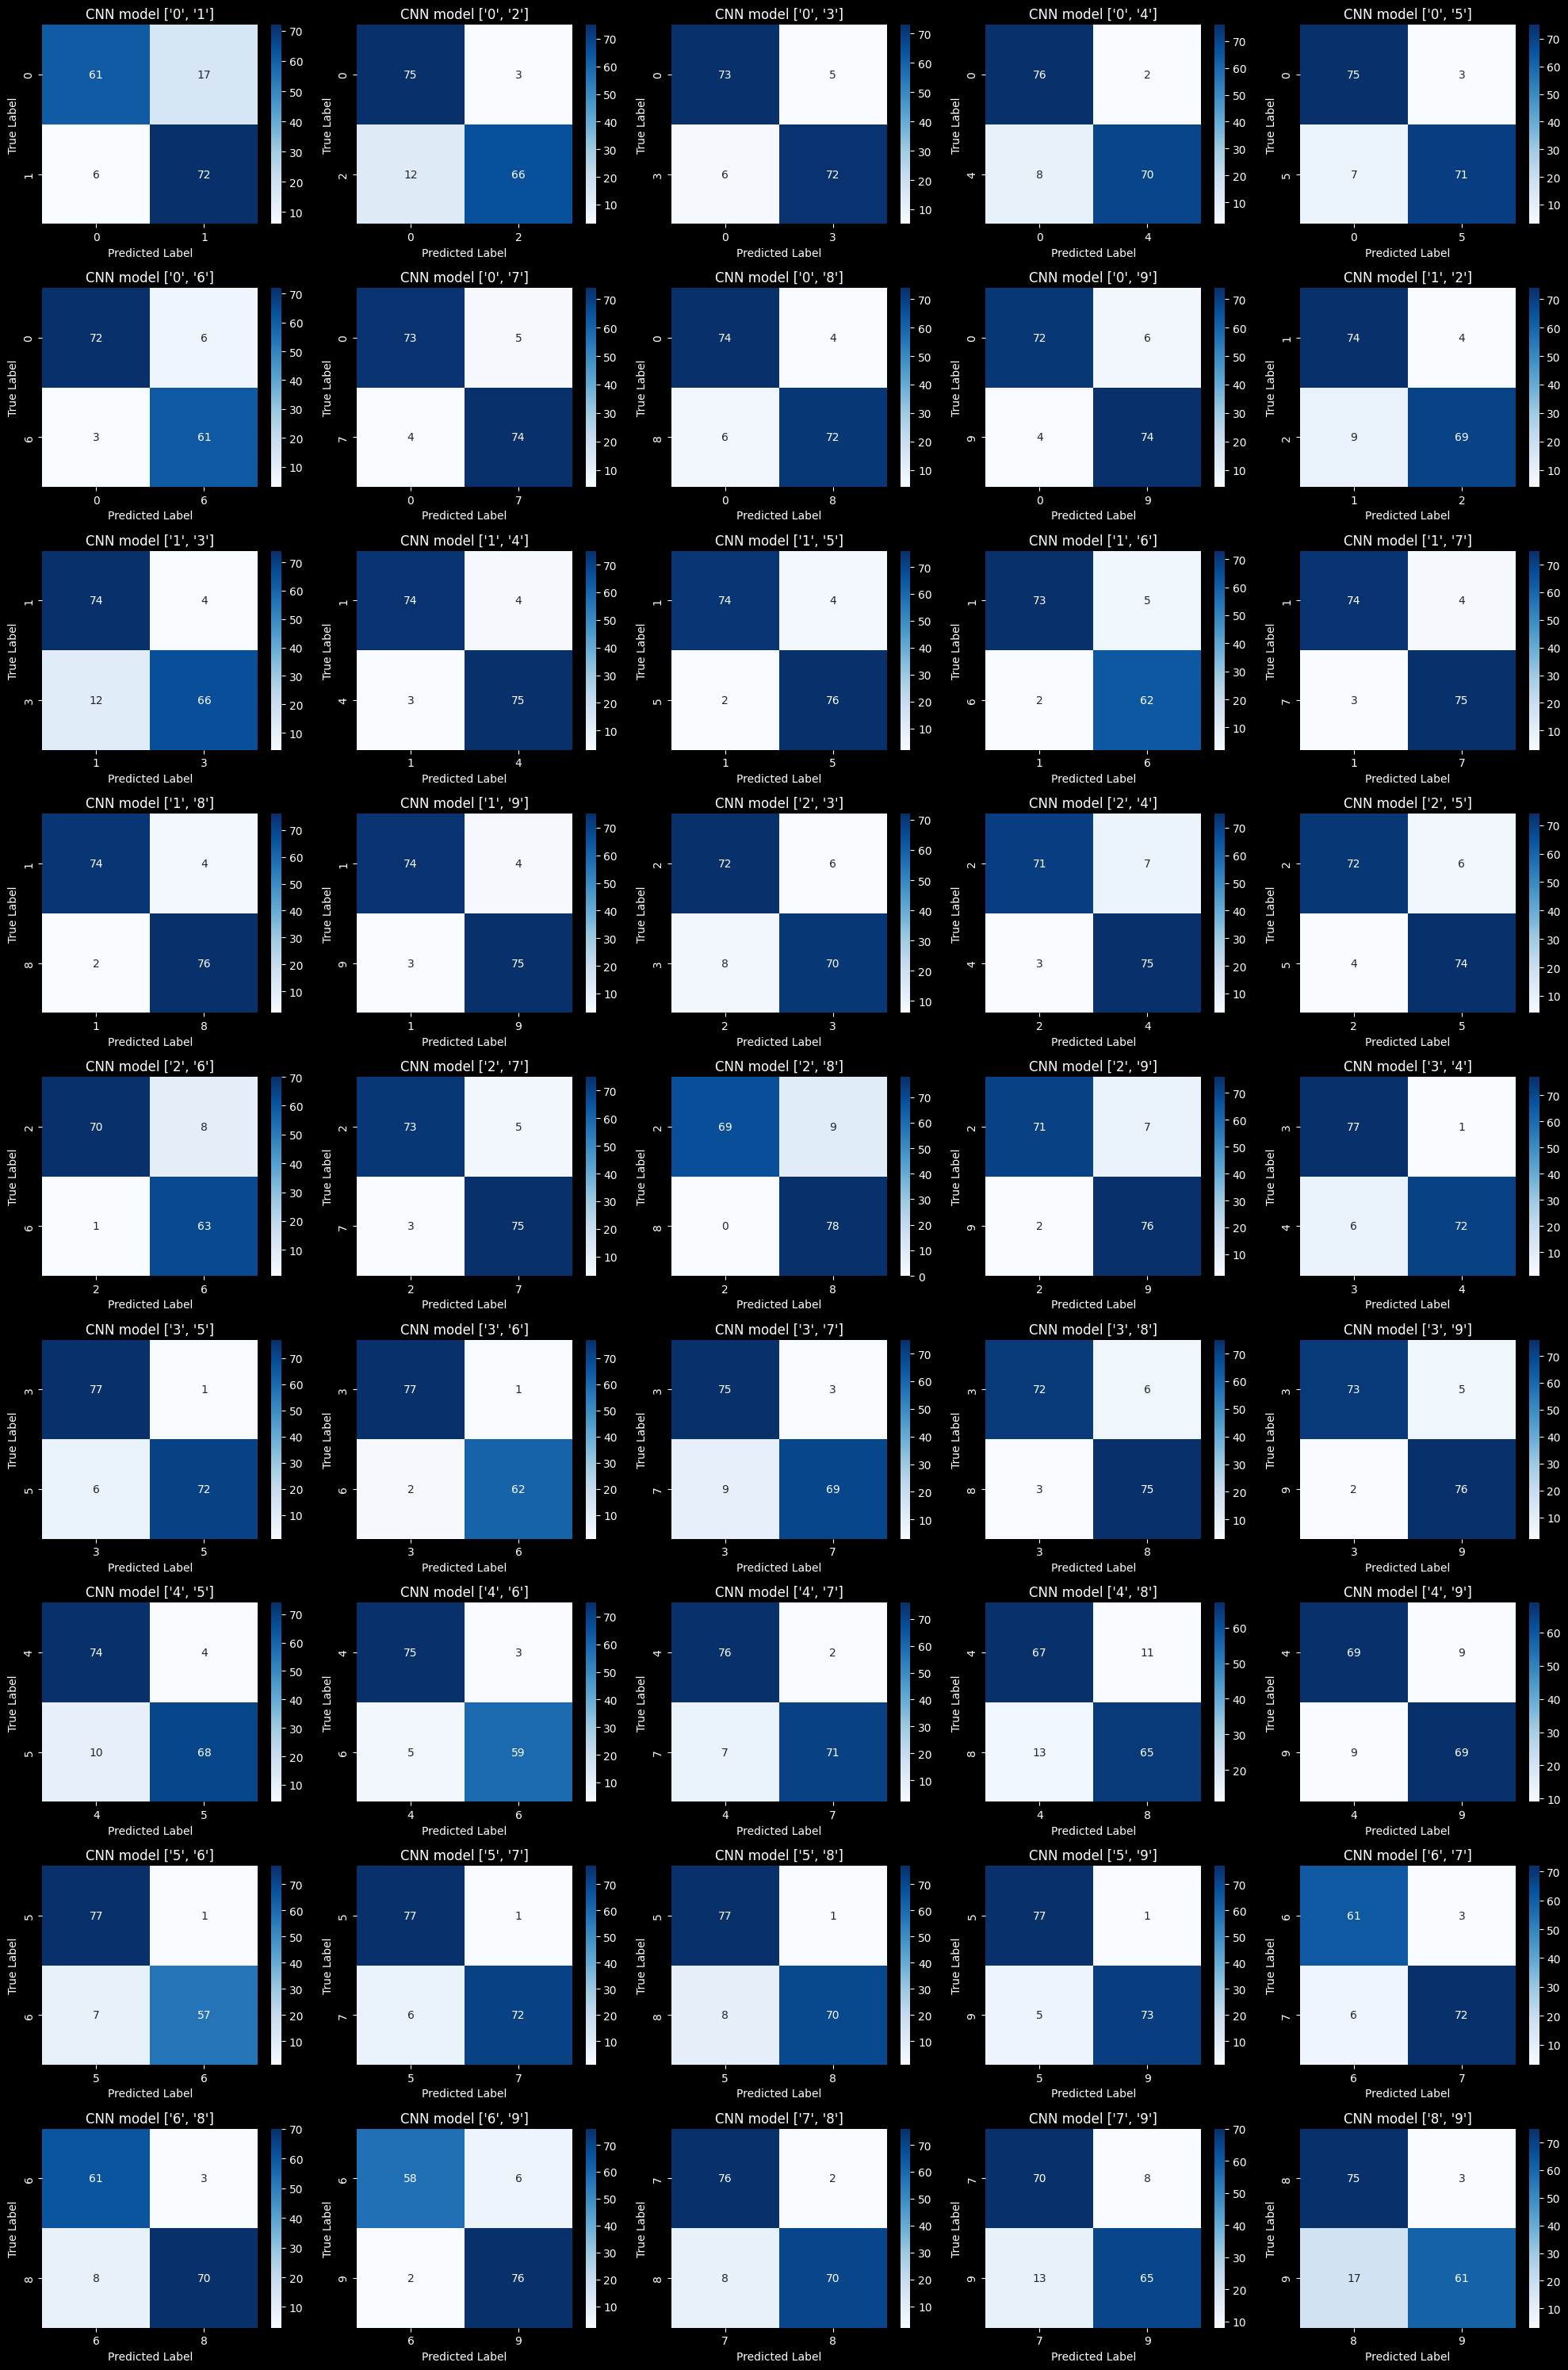

In [96]:
### START CODE HERE ###
model_folder = 'checkpoints/cnn_model'  # หรือ 'checkpoints\\cnn_model' สำหรับ Windows
model_paths = [os.path.join(model_folder, f) 
               for f in os.listdir(model_folder) 
               if f.endswith('.pth')]

loaded_models = []

for path in model_paths:
    print(f"📥 Loading model from: {path}")
    model_instance = CNN()  
    model_instance.load_state_dict(torch.load(path, weights_only=True))
    model_instance.eval()
    loaded_models.append(model_instance)

plot_confusion_matrix(loaded_models,'CNN model',cn_and_loader, 'cpu')
### END CODE HERE ###

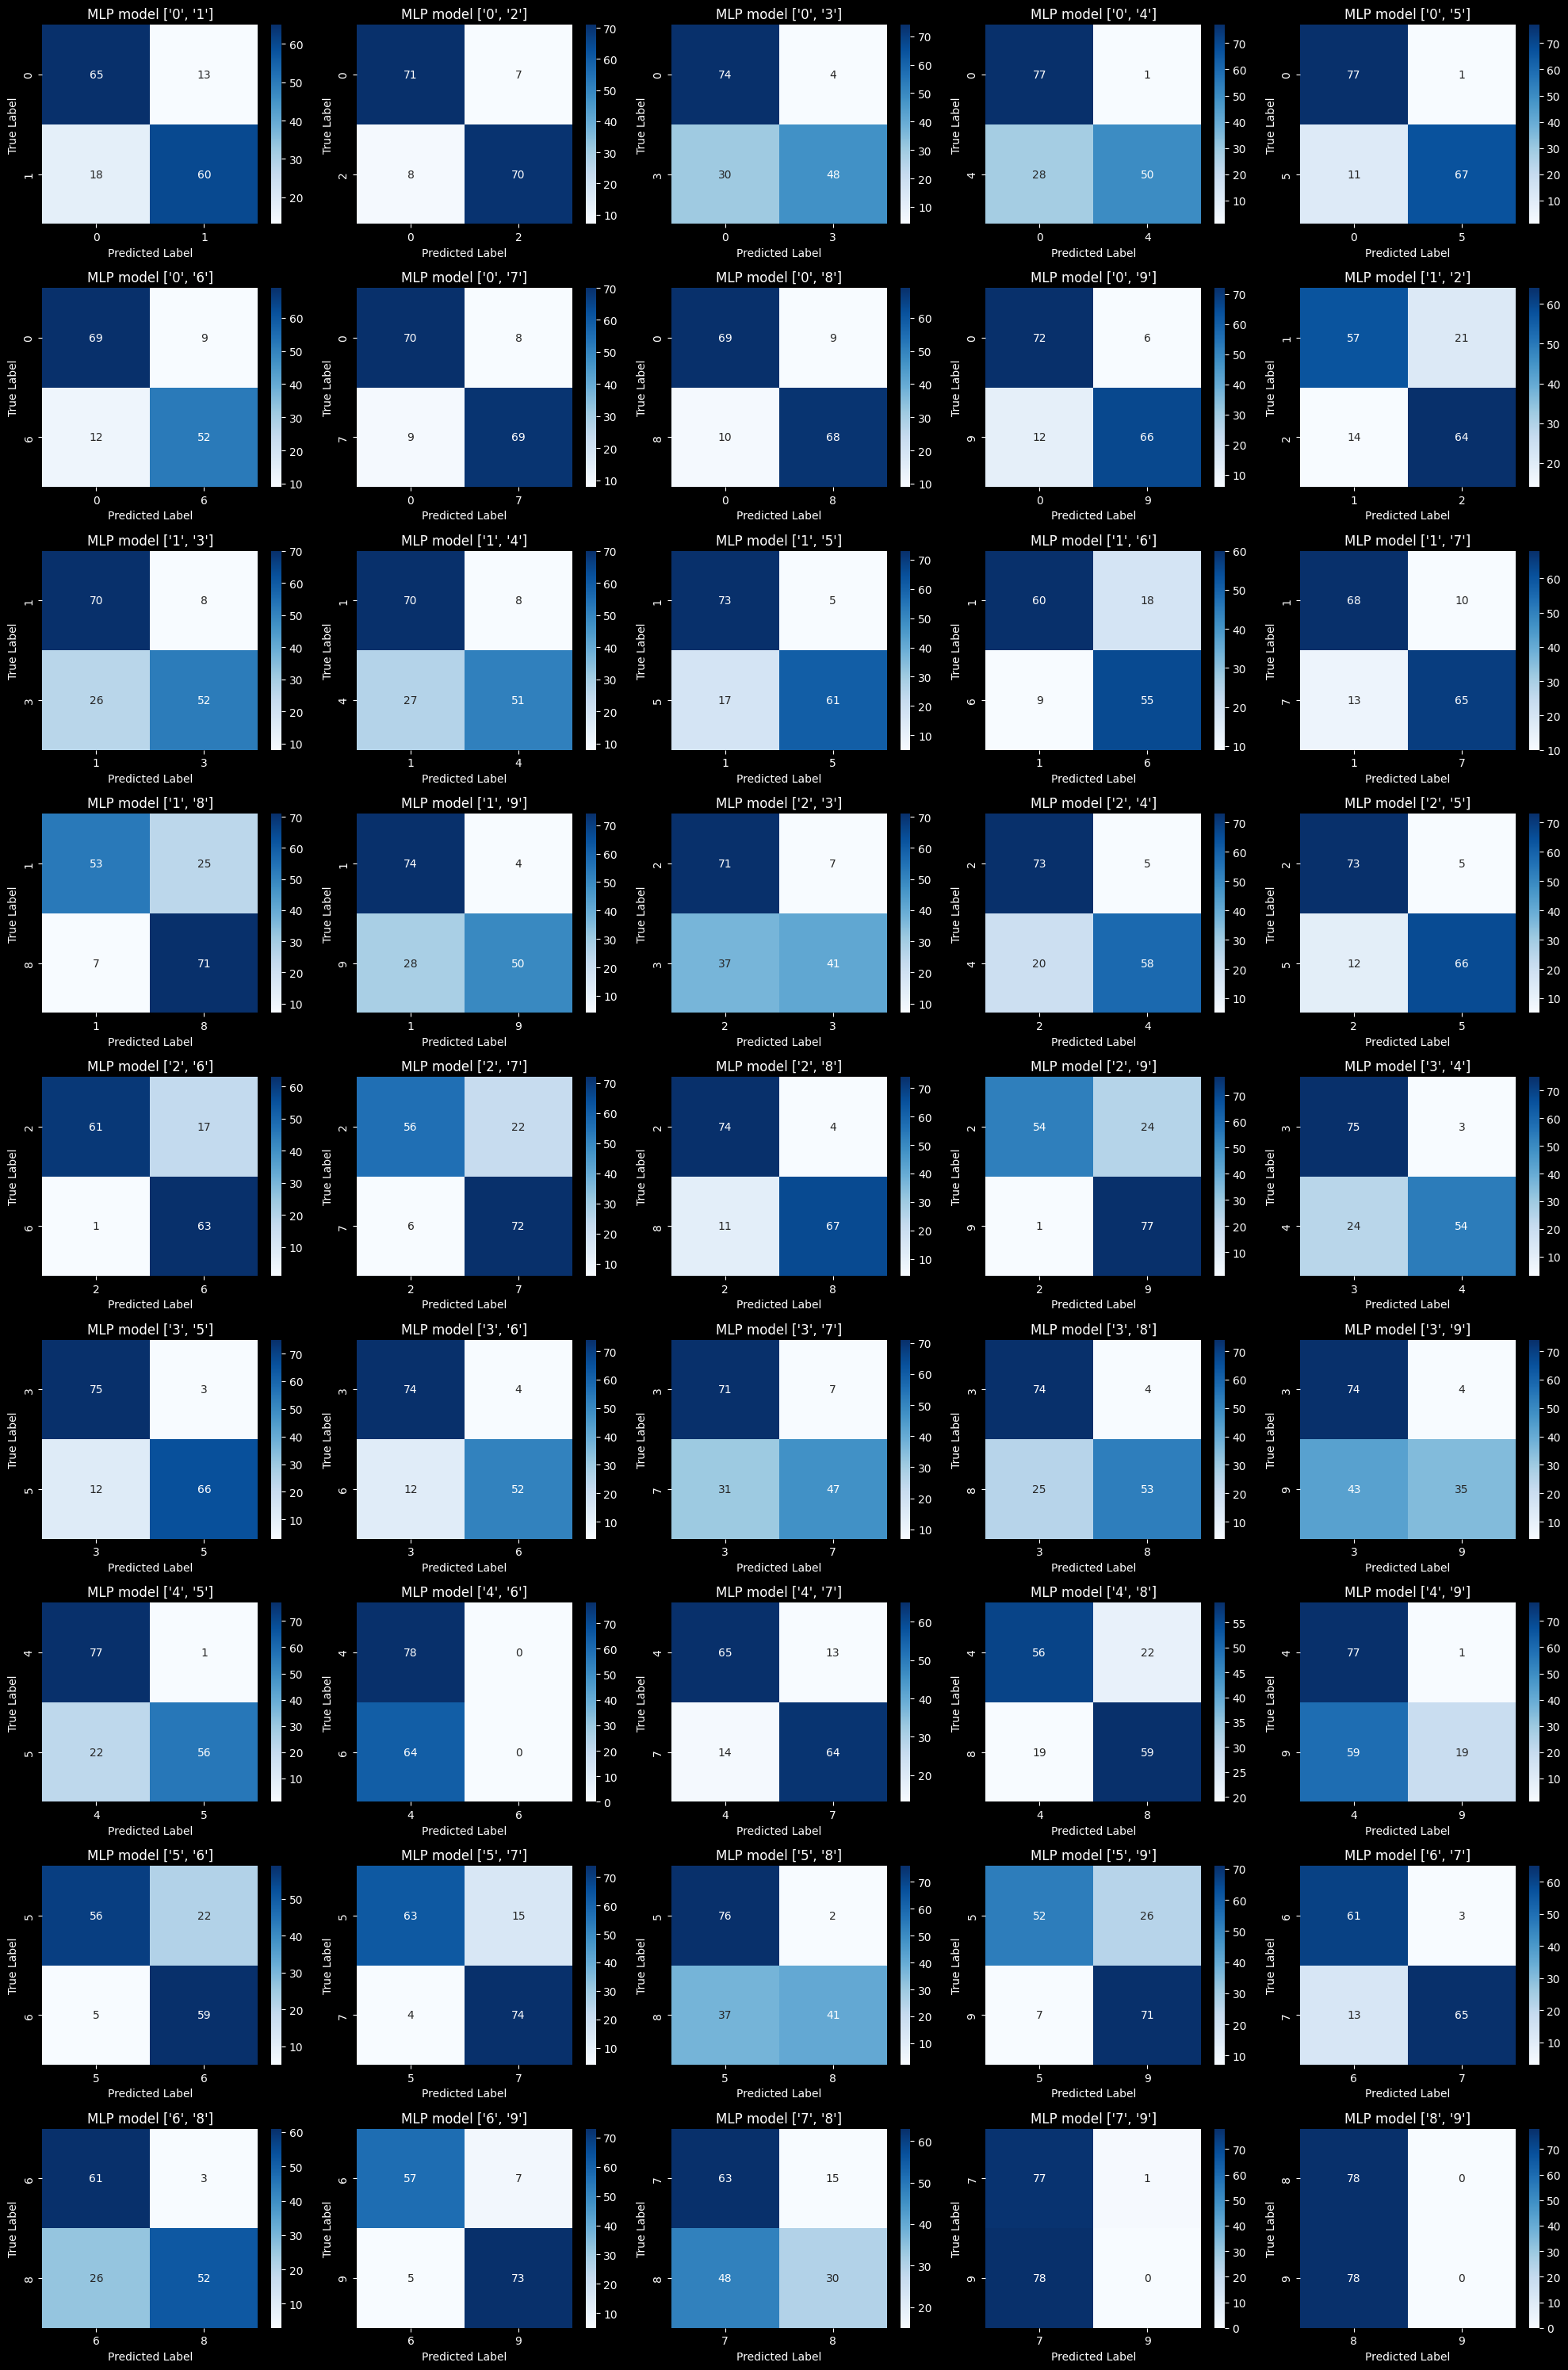

In [110]:
model_folder = 'checkpoints/mlp_model' 
model_paths = [os.path.join(model_folder, f) 
               for f in os.listdir(model_folder) 
               if f.endswith('.pth')]

loaded_models = []

for path in model_paths:
    model_instance = MLP()  
    model_instance.load_state_dict(torch.load(path, weights_only=True))
    model_instance.eval()
    loaded_models.append(model_instance)

plot_confusion_matrix(loaded_models,'MLP model',cn_and_loader, 'cpu')

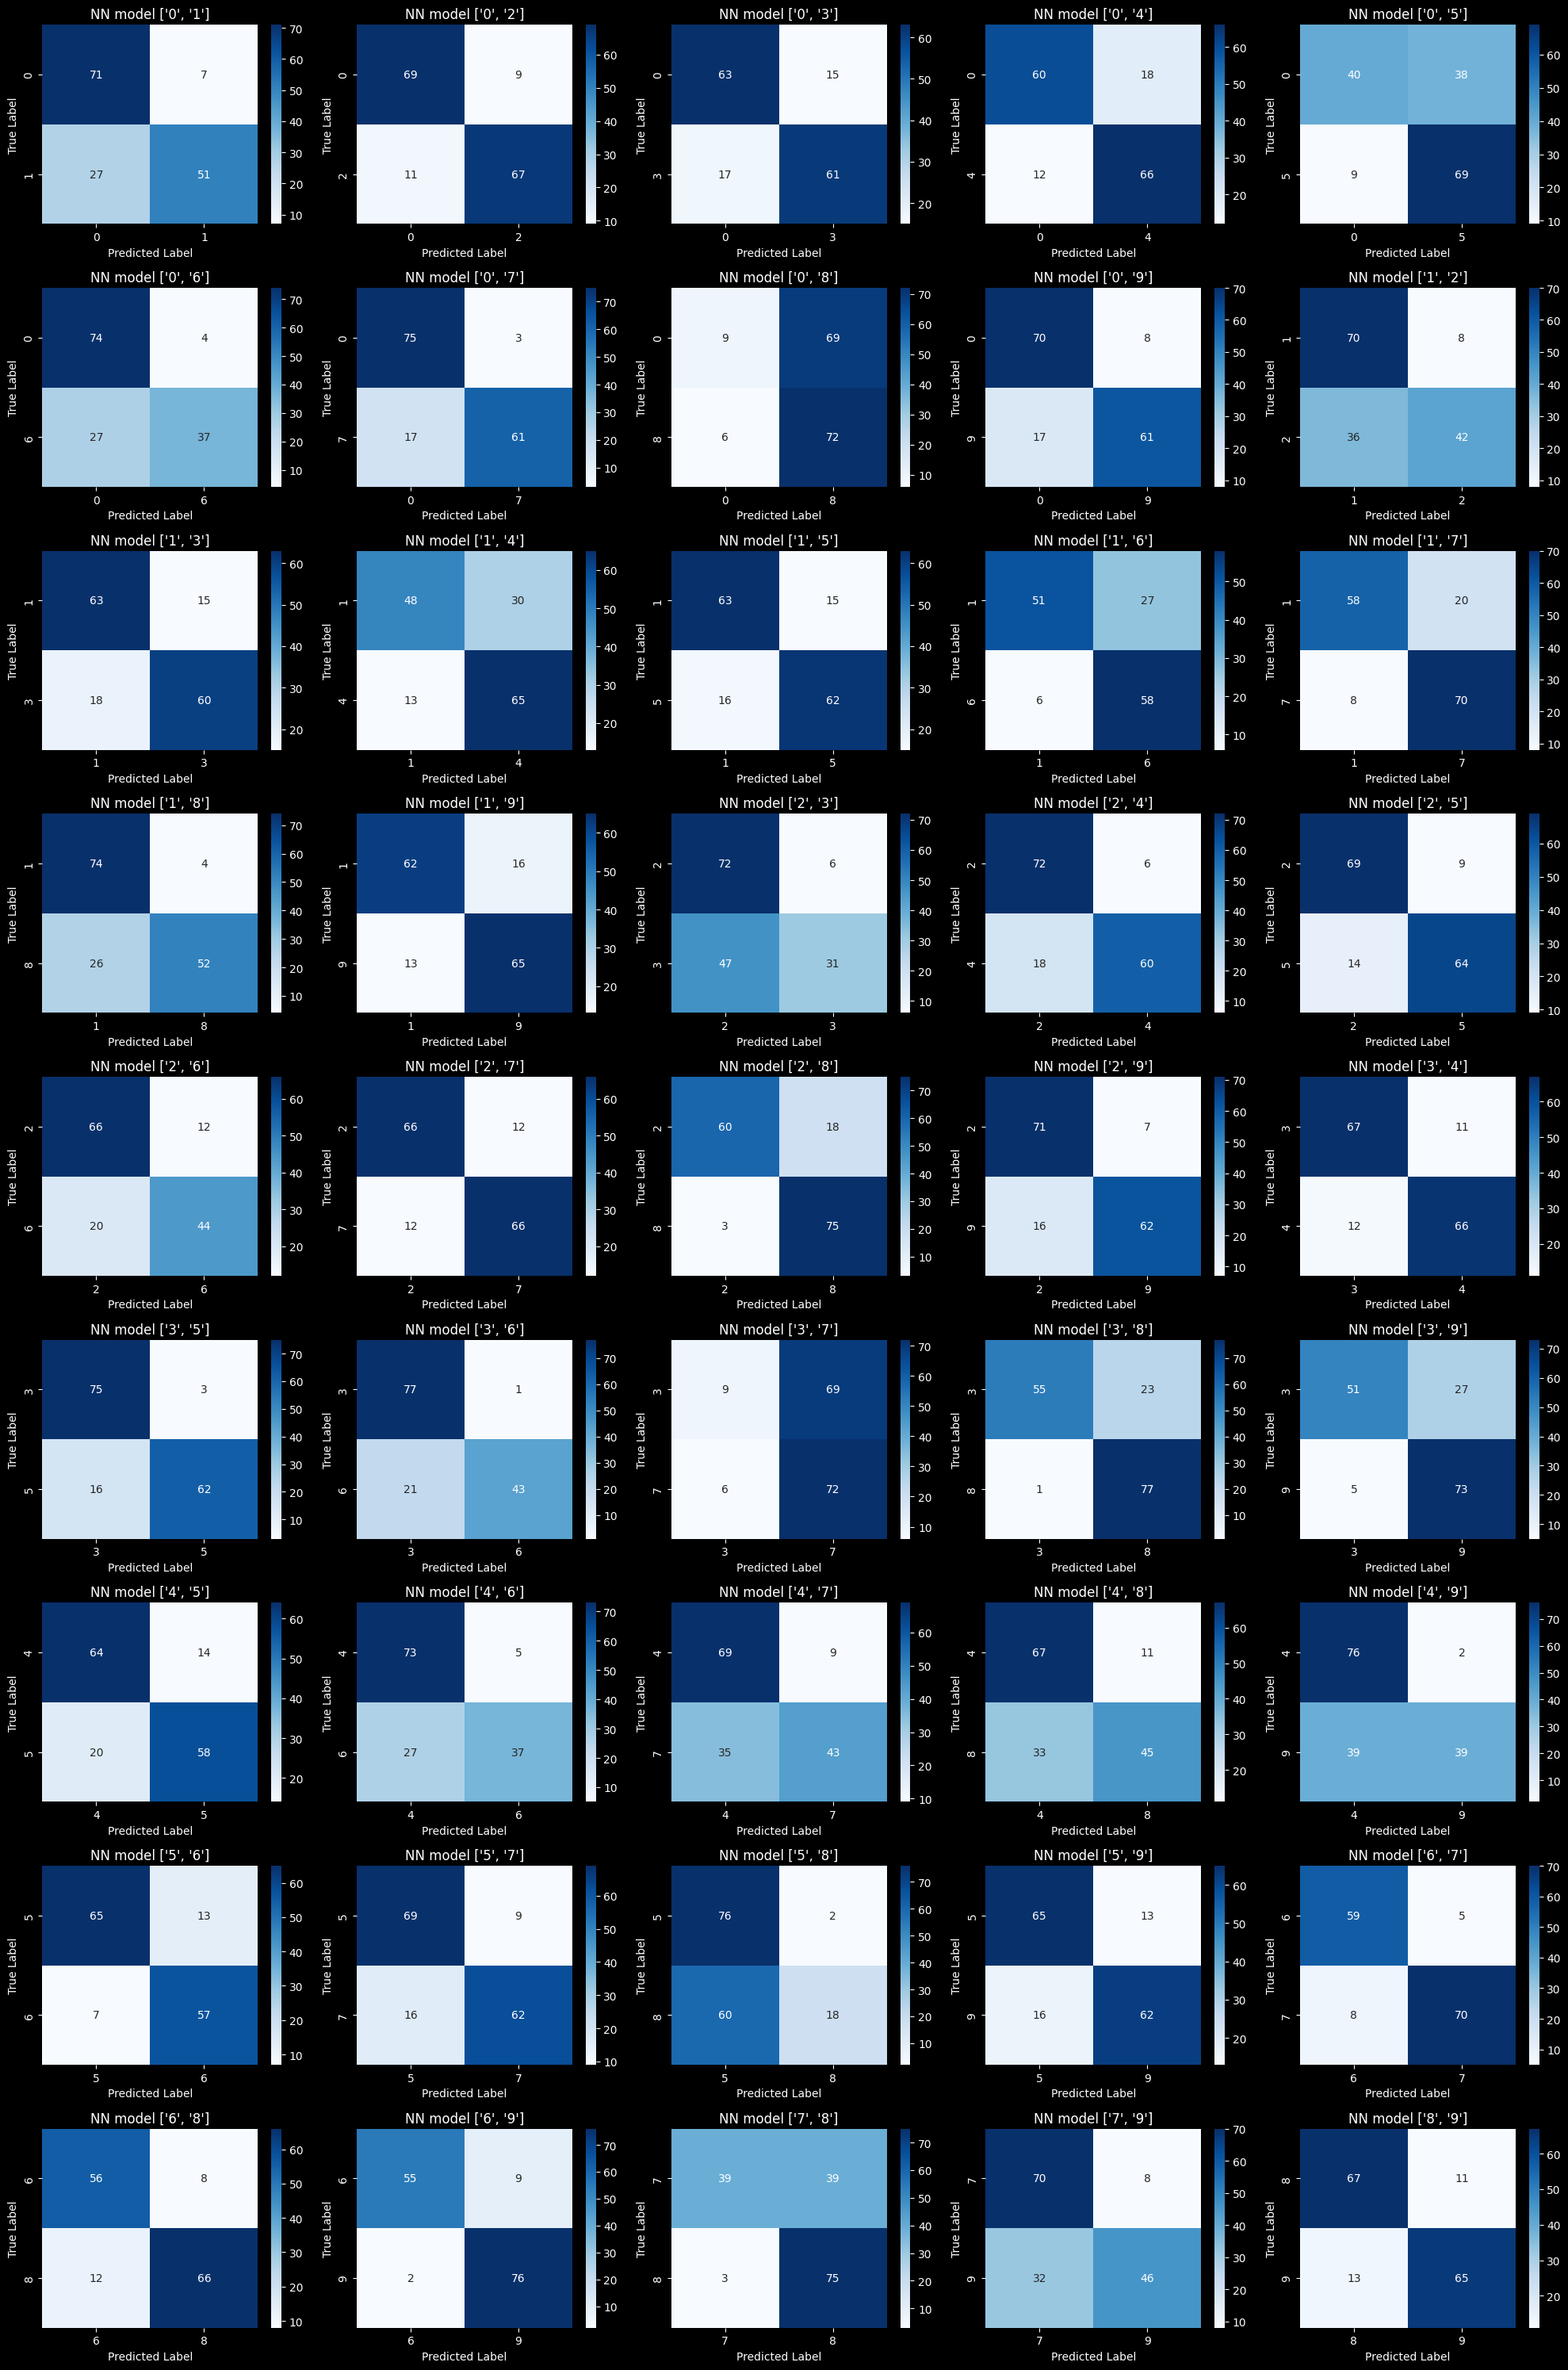

In [115]:
model_folder = 'checkpoints/nn_model' 
model_paths = [os.path.join(model_folder, f) 
               for f in os.listdir(model_folder) 
               if f.endswith('.pth')]

loaded_models = []

for path in model_paths:
    model_instance = NN()  
    model_instance.load_state_dict(torch.load(path, weights_only=True))
    model_instance.eval()
    loaded_models.append(model_instance)

plot_confusion_matrix(loaded_models,'NN model',cn_and_loader, 'cpu')

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.
